In [ ]:
import pandas as pd
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv
import scipy as sp

In [ ]:
# ---------------------------------------------------------------------
# CARGAR VARIABLES DEL ARCHIVO .env
# ---------------------------------------------------------------------
load_dotenv()  # carga las variables de entorno desde el archivo .env

DATA_PATH = os.getenv("DATA_PATH")

if DATA_PATH is None:
    raise EnvironmentError(
        "❌ No se encontró la variable DATA_PATH en el archivo .env. "
        "Asegúrate de definirla, por ejemplo:\nDATA_PATH=/ruta/a/tu/dataset.csv"
    )

# ---------------------------------------------------------------------
# FUNCIÓN DE CARGA DEL DATASET
# ---------------------------------------------------------------------
def load_dataset():
    """Carga el dataset desde la ruta especificada en .env"""
    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"❌ No se encontró el archivo en: {DATA_PATH}")

    print(f"📂 Cargando dataset desde: {DATA_PATH}")
    df = pd.read_csv(DATA_PATH)
    print(f"✅ Dataset cargado: {df.shape[0]} filas y {df.shape[1]} columnas.")
    return df

df = load_dataset()

📂 Cargando dataset desde: /Users/nickdiaz_yuno/personal_projects/3T_ProjectGames/data/games.csv
✅ Dataset cargado: 16715 filas y 11 columnas.


# 1. Pre-Procesamiento

## 1.1. Formateo de nombres de columnas

In [4]:
new_col_names = []

for i in df.columns:
    i = i.lower()
    new_col_names.append(i)
    #print(new_col_names)

df.columns = new_col_names

## 1.2. Corrección de tipo de datos

In [5]:
### 1.2.1 'year_of_release'
df['year_of_release'] = pd.to_numeric(df['year_of_release'], errors='coerce').astype('Int64')

### 1.2.2. 'user_score'
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce').astype('float')


Razones por las que se cambió el tipo de dato de los atributos 'user_score' y 'year_of_release'
1. 'year_of_release': En prinicipio, el tipo de dato era 'float64', pero este fue cambiado a 'Int64' porque los años se manejan en formato entero.
2. 'user_score': En principio, el tipo de dato era 'object', pero fue cambiado a 'float64' porque esto es una puntuación y es necesario tener decimales en las puntuaciones.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.4+ MB


## 1.3. Valores Nulos

### 1.3.1. 'name'

In [7]:
df['name'].nunique()
df['name'].isnull().sum()
print(df[df['name'].isnull()])

      name platform  year_of_release genre  na_sales  eu_sales  jp_sales  \
659    NaN      GEN             1993   NaN      1.78      0.53      0.00   
14244  NaN      GEN             1993   NaN      0.00      0.00      0.03   

       other_sales  critic_score  user_score rating  
659           0.08           NaN         NaN    NaN  
14244         0.00           NaN         NaN    NaN  


Hay dos registros que no tienen nombre, y coincide que tampoco tienen ni genero ni 'critic_score', 'user_score' y tampoco 'rating', se desconoce mucha información de estos dos registros, por lo tanto se decide borrarlos de la lista

In [8]:
df.dropna(subset=['name'], inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.5+ MB


### 1.3.2. 'platform'

In [10]:
df['name'].nunique()
df['name'].isnull().sum()
print(df[df['name'].isnull()])

Empty DataFrame
Columns: [name, platform, year_of_release, genre, na_sales, eu_sales, jp_sales, other_sales, critic_score, user_score, rating]
Index: []


### 1.3.3. 'year_of_release'

In [11]:
df['year_of_release'].isnull().sum()
print(df[df['year_of_release'].isnull()])

def assign_year_of_release(row):
    parse_name = row['name'].split()
    for word in parse_name:
        if word.isdigit() and len(word) == 4:
            return int(word)
        elif word.isdigit() and len(word) == 2:
            if int(word) < 20:
                return int('20' + word)
            else:
                return int('19' + word)
        
mask = df['year_of_release'].isna() | (df['year_of_release'] == 0)
df.loc[mask, 'year_of_release'] = df.loc[mask].apply(assign_year_of_release, axis=1)

# Mapear cada juego a su año más común en otras plataformas
year_by_game = df.groupby('name')['year_of_release'].apply(
    lambda x: x.dropna().mode()[0] if not x.dropna().empty else np.nan
).to_dict()

# Rellenar NaN con el año del mismo juego en otra plataforma
mask_nan = df['year_of_release'].isna()
df.loc[mask_nan, 'year_of_release'] = df.loc[mask_nan, 'name'].map(year_by_game)

# Contar los juegos que quedaron con 'year_of_release' en NaN
df['year_of_release'].isna().sum()


                                    name platform  year_of_release  \
183                      Madden NFL 2004      PS2             <NA>   
377                     FIFA Soccer 2004      PS2             <NA>   
456           LEGO Batman: The Videogame      Wii             <NA>   
475           wwe Smackdown vs. Raw 2006      PS2             <NA>   
609                       Space Invaders     2600             <NA>   
...                                  ...      ...              ...   
16373  PDC World Championship Darts 2008      PSP             <NA>   
16405                      Freaky Flyers       GC             <NA>   
16448                          Inversion       PC             <NA>   
16458        Hakuouki: Shinsengumi Kitan      PS3             <NA>   
16522                       Virtua Quest       GC             <NA>   

              genre  na_sales  eu_sales  jp_sales  other_sales  critic_score  \
183          Sports      4.26      0.26      0.01         0.71          94.0   

np.int64(136)

Hay 136 registros con 'year_of_release' NaN de 16713, por lo tanto, se propone eliminar estos registros

In [12]:
df.dropna(subset=['year_of_release'], inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16577 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16577 non-null  object 
 1   platform         16577 non-null  object 
 2   year_of_release  16577 non-null  Int64  
 3   genre            16577 non-null  object 
 4   na_sales         16577 non-null  float64
 5   eu_sales         16577 non-null  float64
 6   jp_sales         16577 non-null  float64
 7   other_sales      16577 non-null  float64
 8   critic_score     8080 non-null   float64
 9   user_score       7544 non-null   float64
 10  rating           9872 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.5+ MB


In [14]:
print(df['year_of_release'].nunique())
print(df['year_of_release'].min())
print(df['year_of_release'].max())

38
1964
2016


Hay información de juegos para 38 años. Donde los juegos más antiguos datan del año 1964, y los más recientes son del 2016. Sin embargo, este intervalo entre estos dos limites corresponde a 52 años, será necesario verificar que años no tienen juegos registrados dentro de la base de datos.

### 1.3.4. 'genre'

In [15]:
df['genre'].nunique()
df['genre'].isnull().sum()
print(df[df['genre'].isnull()])

Empty DataFrame
Columns: [name, platform, year_of_release, genre, na_sales, eu_sales, jp_sales, other_sales, critic_score, user_score, rating]
Index: []


### 1.3.5. 'critic_score'

In [16]:
df['critic_score'].isnull().sum()

np.int64(8497)

### 1.3.6. 'user_score'

In [17]:
df['user_score'].isnull().sum()

np.int64(9033)

### 1.3.7. 'rating'

In [18]:
df['rating'].isnull().sum()

np.int64(6705)

### 1.3.8. Tratamiento especial para los atributos 'critic_score', 'user_score' y 'rating

Estos tres atributos presentan la mayor cantidad de valores NaN para todo el dataset, para poder tomar una decisión sobre qué hacer con estos valores, es necesario entender un poco más su comportamiento.

In [19]:
# ============================================================================
# PASO 1: ANÁLISIS ESTADÍSTICO POR GRUPO
# ============================================================================

# Atributos a analizar
atributos = ['critic_score', 'rating', 'user_score']

# Crear análisis por grupo
def analizar_nulos_por_grupo(df, atributos):
    """
    Analiza datos nulos y no nulos agrupados por genre y platform
    """
    resultados = []
    
    for genre in df['genre'].unique():
        for platform in df['platform'].unique():
            # Filtrar por grupo
            mask = (df['genre'] == genre) & (df['platform'] == platform)
            grupo = df[mask]
            
            if len(grupo) > 0:
                fila = {
                    'genre': genre,
                    'platform': platform,
                    'total_juegos': len(grupo)
                }
                
                # Analizar cada atributo
                for atributo in atributos:
                    nulos = grupo[atributo].isna().sum()
                    no_nulos = grupo[atributo].notna().sum()
                    porcentaje_nulos = (nulos / len(grupo)) * 100
                    
                    fila[f'{atributo}_nulos'] = nulos
                    fila[f'{atributo}_no_nulos'] = no_nulos
                    fila[f'{atributo}_pct_nulos'] = porcentaje_nulos
                
                resultados.append(fila)
    
    return pd.DataFrame(resultados)

# Generar estadísticas
df_stats = analizar_nulos_por_grupo(df, atributos)

print("\n" + "=" * 80)
print("ESTADÍSTICAS POR GRUPO (Genre + Platform)")
print("=" * 80)
print(df_stats.to_string(index=False))

# ============================================================================
# PASO 2: RESUMEN GENERAL
# ============================================================================

print("\n" + "=" * 80)
print("RESUMEN GENERAL DE DATOS NULOS")
print("=" * 80)

for atributo in atributos:
    total_nulos = df[atributo].isna().sum()
    total_no_nulos = df[atributo].notna().sum()
    pct_nulos = (total_nulos / len(df)) * 100
    
    print(f"\n{atributo.upper()}:")
    print(f"  • No nulos: {total_no_nulos} ({100-pct_nulos:.1f}%)")
    print(f"  • Nulos:    {total_nulos} ({pct_nulos:.1f}%)")



ESTADÍSTICAS POR GRUPO (Genre + Platform)
       genre platform  total_juegos  critic_score_nulos  critic_score_no_nulos  critic_score_pct_nulos  rating_nulos  rating_no_nulos  rating_pct_nulos  user_score_nulos  user_score_no_nulos  user_score_pct_nulos
      Sports      Wii           258                 164                     94               63.565891            68              190         26.356589               161                   97             62.403101
      Sports      NES            14                  14                      0              100.000000            14                0        100.000000                14                    0            100.000000
      Sports       GB             9                   9                      0              100.000000             9                0        100.000000                 9                    0            100.000000
      Sports       DS           147                 107                     40               72.789116   


GENERANDO VISUALIZACIONES...


/var/folders/vl/nhdmlk3n4hbd3jy0qdqgg7ch0000gn/T/ipykernel_46368/610092633.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '43.8%
(3342)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot_genre.loc[genero] = [
/var/folders/vl/nhdmlk3n4hbd3jy0qdqgg7ch0000gn/T/ipykernel_46368/610092633.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '34.9%
(3342)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot_genre.loc[genero] = [
/var/folders/vl/nhdmlk3n4hbd3jy0qdqgg7ch0000gn/T/ipykernel_46368/610092633.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '45.5%
(3342)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first

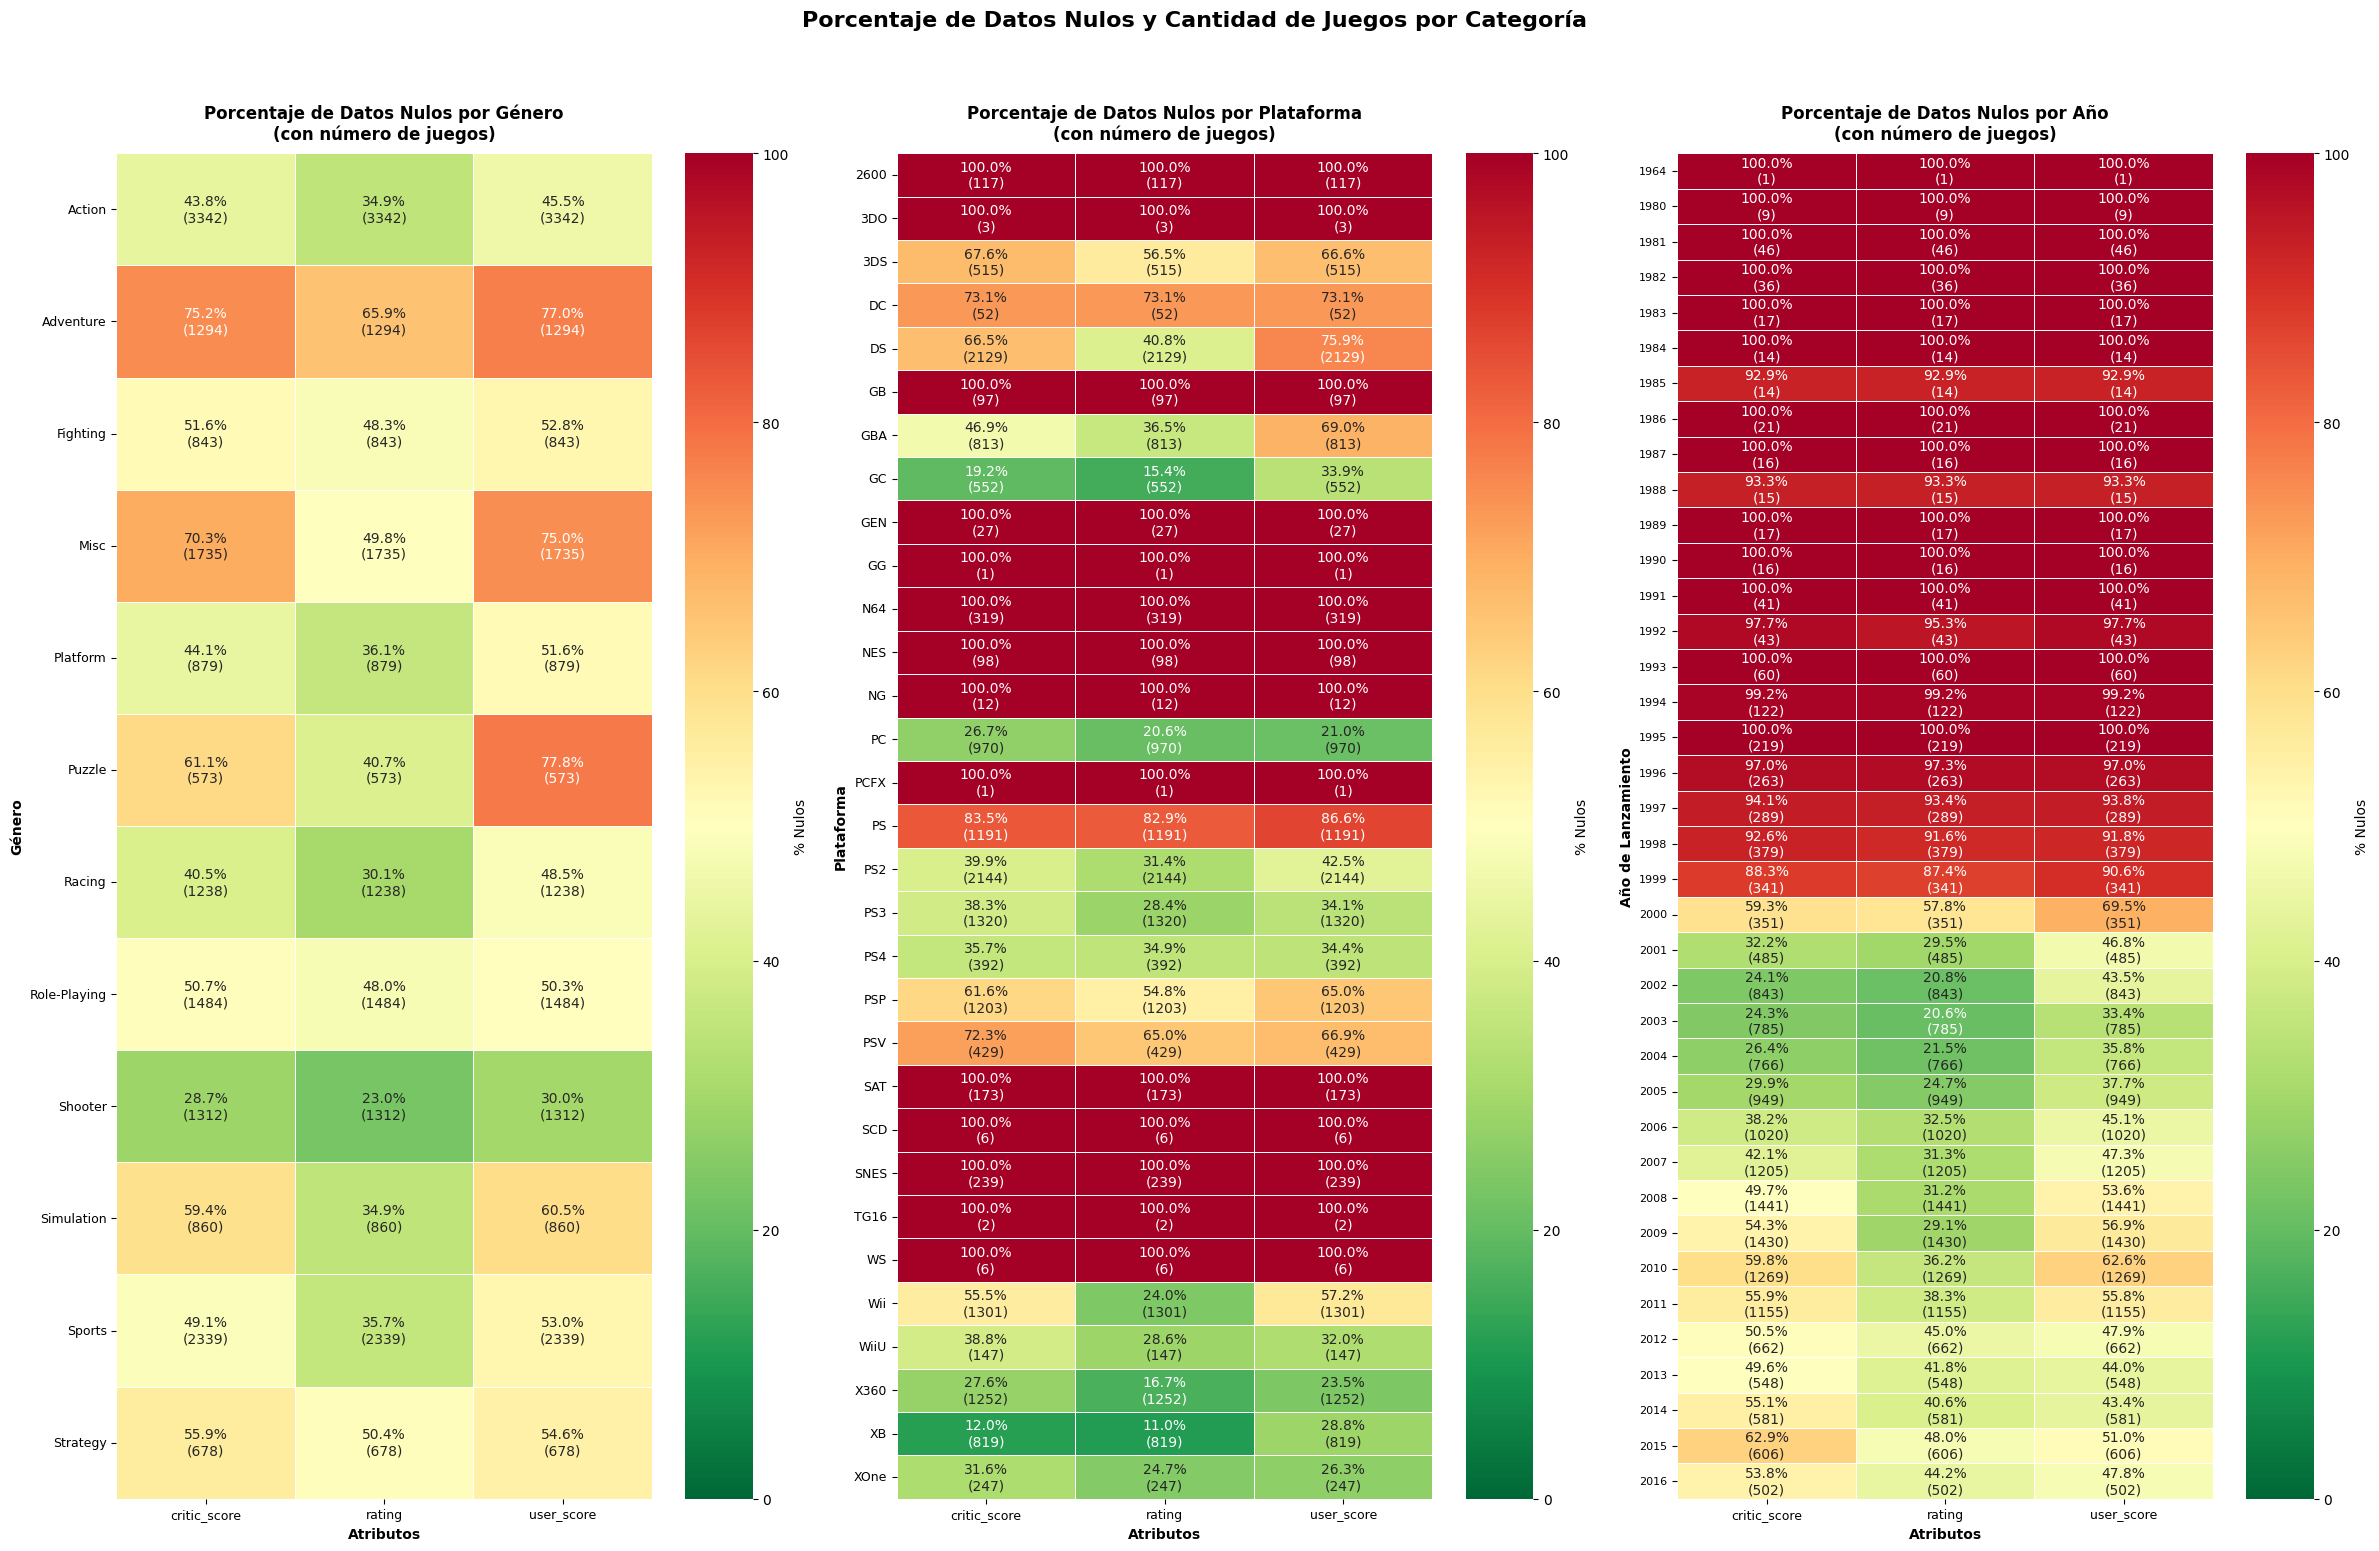

In [20]:
# ============================================================================
# PASO 3: VISUALIZACIONES (VERSIÓN CON CONTEO DENTRO DEL HEATMAP)
# ============================================================================

print("\n" + "=" * 80)
print("GENERANDO VISUALIZACIONES...")
print("=" * 80)

# Calcular % nulos
pivot_genre = df.groupby('genre')[atributos].apply(
    lambda x: (x.isna().sum() / len(x)) * 100
).sort_index()

pivot_platform = df.groupby('platform')[atributos].apply(
    lambda x: (x.isna().sum() / len(x)) * 100
).sort_index()

pivot_year = df.groupby('year_of_release')[atributos].apply(
    lambda x: (x.isna().sum() / len(x)) * 100
).sort_index()

# Calcular conteos
count_genre = df['genre'].value_counts().sort_index()
count_platform = df['platform'].value_counts().sort_index()
count_year = df['year_of_release'].value_counts().sort_index()

# Crear matrices de anotaciones combinadas
annot_genre = pivot_genre.copy()
annot_platform = pivot_platform.copy()
annot_year = pivot_year.copy()

for genero in annot_genre.index:
    total = count_genre.get(genero, 0)
    annot_genre.loc[genero] = [
        f"{val:.1f}%\n({total})" for val in annot_genre.loc[genero]
    ]

for plataforma in annot_platform.index:
    total = count_platform.get(plataforma, 0)
    annot_platform.loc[plataforma] = [
        f"{val:.1f}%\n({total})" for val in annot_platform.loc[plataforma]
    ]

for year in annot_year.index:
    total = count_year.get(year, 0)
    annot_year.loc[year] = [
        f"{val:.1f}%\n({total})" for val in annot_year.loc[year]
    ]

# Ajustar tamaño de figura según cantidad de datos
n_platforms = len(pivot_platform)
n_genres = len(pivot_genre)
n_years = len(pivot_year)
altura_minima = max(12, n_platforms * 0.5, n_genres * 0.5, n_years * 0.4)
ancho_figura = 24

fig, axes = plt.subplots(1, 3, figsize=(ancho_figura, altura_minima))
fig.suptitle('Porcentaje de Datos Nulos y Cantidad de Juegos por Categoría',
             fontsize=16, fontweight='bold', y=0.998)

# ============================================================================
# Heatmap de % nulos por Género + Conteo
# ============================================================================
ax1 = axes[0]
sns.heatmap(pivot_genre, 
            annot=annot_genre, 
            fmt='', 
            cmap='RdYlGn_r', 
            ax=ax1, 
            cbar_kws={'label': '% Nulos'},
            linewidths=0.5,
            linecolor='white',
            vmin=0,
            vmax=100)

ax1.set_title('Porcentaje de Datos Nulos por Género\n(con número de juegos)', fontweight='bold', pad=10)
ax1.set_xlabel('Atributos', fontweight='bold')
ax1.set_ylabel('Género', fontweight='bold')
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0, fontsize=9)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, fontsize=9)

# ============================================================================
# Heatmap de % nulos por Plataforma + Conteo
# ============================================================================
ax2 = axes[1]
sns.heatmap(pivot_platform, 
            annot=annot_platform, 
            fmt='', 
            cmap='RdYlGn_r', 
            ax=ax2, 
            cbar_kws={'label': '% Nulos'},
            linewidths=0.5,
            linecolor='white',
            vmin=0,
            vmax=100)

ax2.set_title('Porcentaje de Datos Nulos por Plataforma\n(con número de juegos)', fontweight='bold', pad=10)
ax2.set_xlabel('Atributos', fontweight='bold')
ax2.set_ylabel('Plataforma', fontweight='bold')
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0, fontsize=9)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, fontsize=9)

# ============================================================================
# Heatmap de % nulos por Año + Conteo
# ============================================================================
ax3 = axes[2]
sns.heatmap(pivot_year, 
            annot=annot_year, 
            fmt='', 
            cmap='RdYlGn_r', 
            ax=ax3, 
            cbar_kws={'label': '% Nulos'},
            linewidths=0.5,
            linecolor='white',
            vmin=0,
            vmax=100)

ax3.set_title('Porcentaje de Datos Nulos por Año\n(con número de juegos)', fontweight='bold', pad=10)
ax3.set_xlabel('Atributos', fontweight='bold')
ax3.set_ylabel('Año de Lanzamiento', fontweight='bold')
ax3.set_yticklabels(ax3.get_yticklabels(), rotation=0, fontsize=8)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0, fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [21]:
df['name'].duplicated().sum()

np.int64(5142)

In [22]:
def most_frequent(x):
    return x.mode().iloc[0] if not x.mode().empty else None

# Agrupamos por 'name'
result = (
    df.groupby('name', as_index=False)
      .agg({
          'platform': 'count',                # cantidad de plataformas
          'critic_score': 'mean',             # promedio de puntuación crítica
          'user_score': 'mean',               # promedio de puntuación de usuario
          'rating': most_frequent             # valor más repetido de rating
      })
)

# Renombramos columnas para mayor claridad (opcional)
result = result.rename(columns={
    'platform': 'platform_count',
    'critic_score': 'avg_critic_score',
    'user_score': 'avg_user_score',
    'rating': 'most_common_rating'
})

result.head(10)

,name,platform_count,avg_critic_score,avg_user_score,most_common_rating
0,Beyblade Burst,1,NaN,NaN,None
1,Fire Emblem Fates,1,NaN,NaN,None
2,Frozen: Olaf's Quest,2,NaN,NaN,None
3,Haikyu!! Cross Team Match!,1,NaN,NaN,None
4,Tales of Xillia 2,1,71.0,7.9,T
5,'98 Koshien,1,NaN,NaN,None
6,.hack//G.U. Vol.1//Rebirth,1,NaN,NaN,None
7,.hack//G.U. Vol.2//Reminisce,1,NaN,NaN,None
8,.hack//G.U. Vol.2//Reminisce (jp sales),1,NaN,NaN,None
9,.hack//G.U. Vol.3//Redemption,1,NaN,NaN,None


In [23]:
df[df['name'].str.strip() == "Frozen: Olaf's Quest"]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
3358,Frozen: Olaf's Quest,3DS,2013,Platform,0.27,0.27,0.0,0.05,NaN,NaN,NaN
3862,Frozen: Olaf's Quest,DS,2013,Platform,0.21,0.26,0.0,0.04,NaN,NaN,NaN


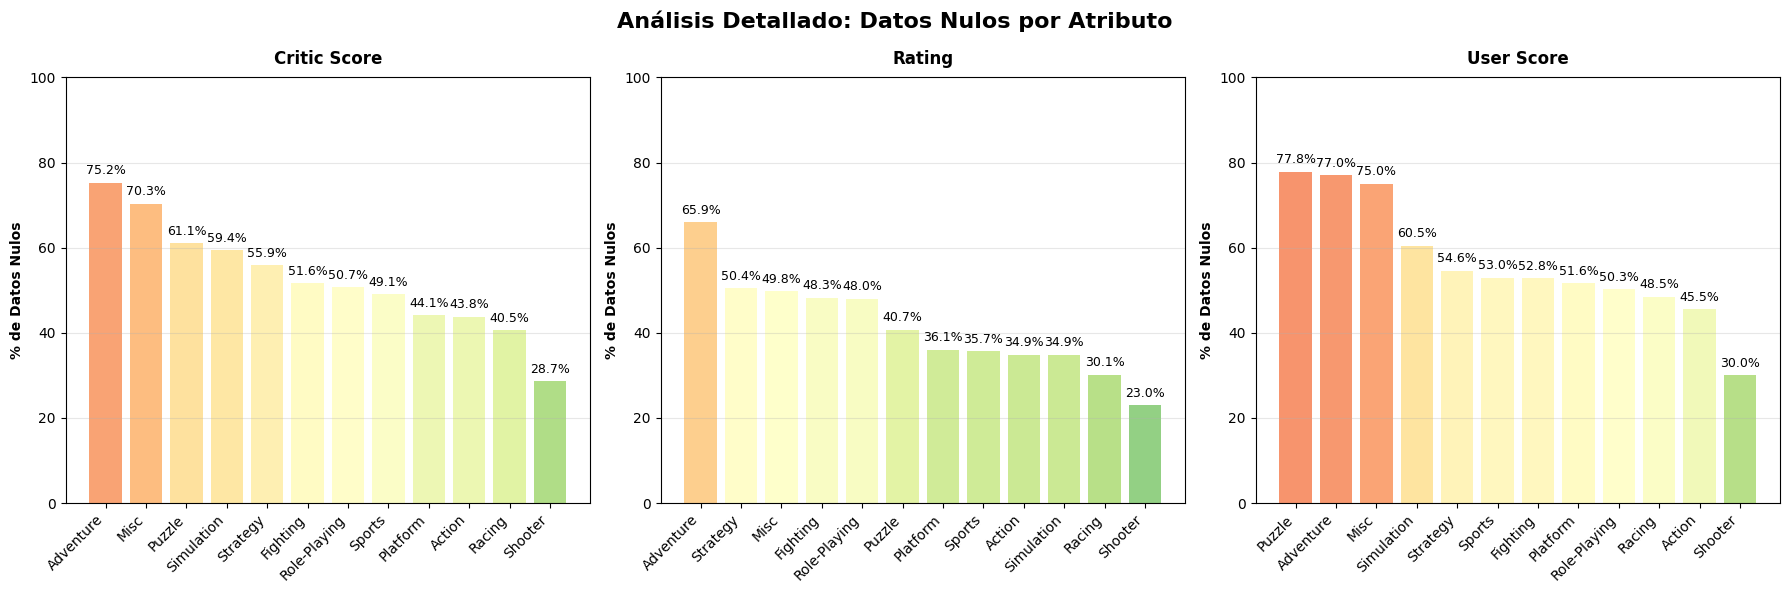

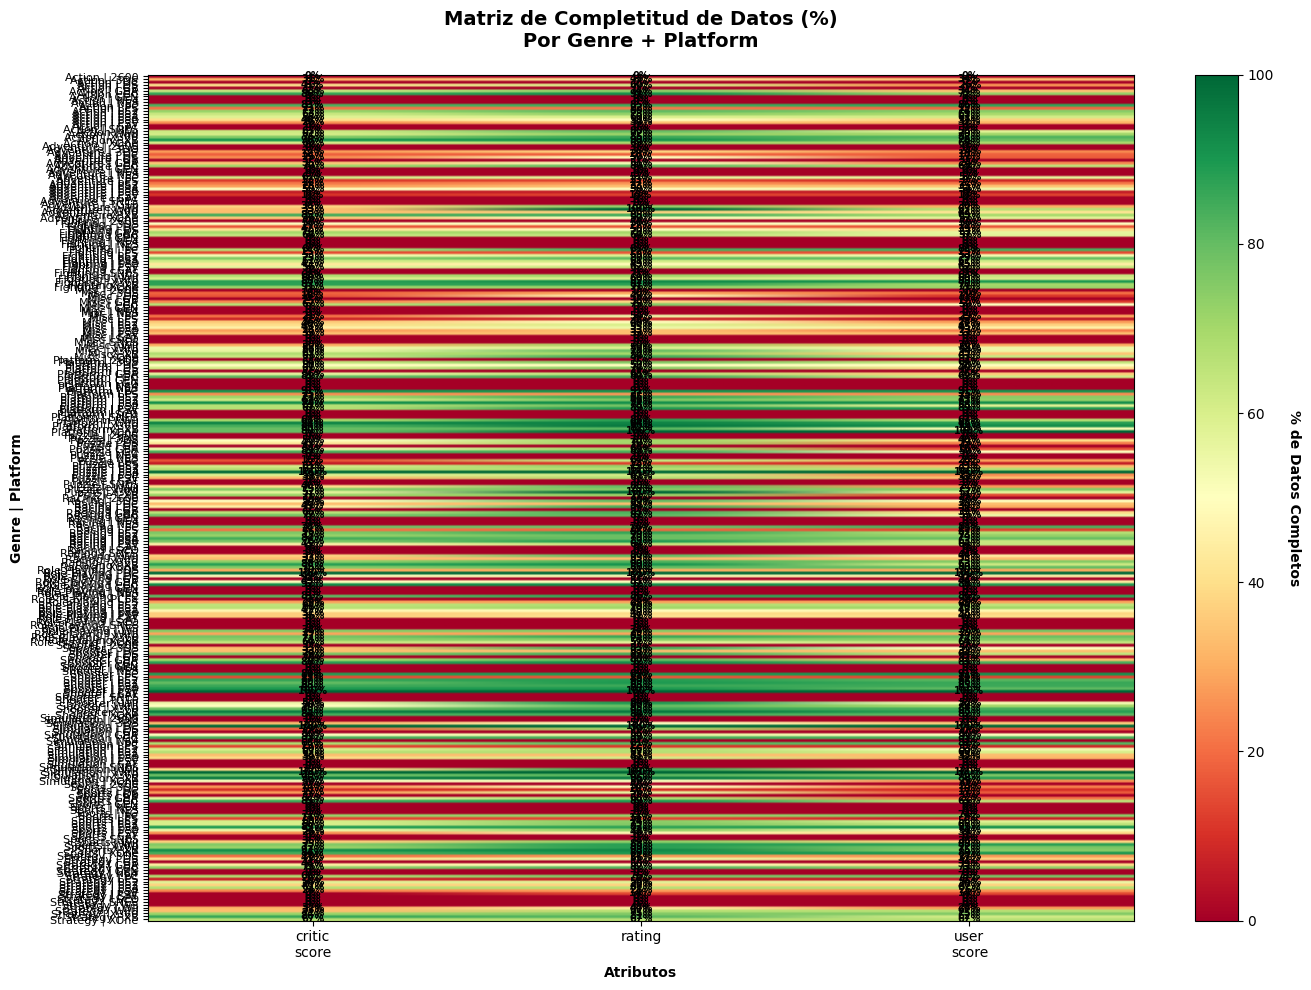

In [24]:
# ============================================================================
# Figura 2: Análisis detallado por cada atributo
# ============================================================================

fig2, axes2 = plt.subplots(1, 3, figsize=(18, 6))
fig2.suptitle('Análisis Detallado: Datos Nulos por Atributo', fontsize=16, fontweight='bold')

for idx, atributo in enumerate(atributos):
    ax = axes2[idx]
    
    # Agrupar por genre y calcular % de nulos
    nulos_por_genre = df.groupby('genre')[atributo].apply(
        lambda x: (x.isna().sum() / len(x)) * 100
    ).sort_values(ascending=False)
    
    colors = plt.cm.RdYlGn_r(nulos_por_genre.values / 100)
    bars = ax.bar(range(len(nulos_por_genre)), nulos_por_genre.values, color=colors, alpha=0.8)
    
    ax.set_xticks(range(len(nulos_por_genre)))
    ax.set_xticklabels(nulos_por_genre.index, rotation=45, ha='right')
    ax.set_ylabel('% de Datos Nulos', fontweight='bold')
    ax.set_title(f'{atributo.replace("_", " ").title()}', fontweight='bold', pad=10)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, 100)
    
    # Agregar valores
    for i, (bar, val) in enumerate(zip(bars, nulos_por_genre.values)):
        ax.text(i, val + 2, f'{val:.1f}%', ha='center', fontsize=9)

plt.tight_layout()


# ============================================================================
# Figura 3: Matriz de completitud
# ============================================================================

fig3, ax = plt.subplots(figsize=(14, 10))

# Preparar datos para la matriz
genres_sorted = sorted(df['genre'].unique())
platforms_sorted = sorted(df['platform'].unique())
n_attrs = len(atributos)

# Crear matriz
matriz_data = np.zeros((len(genres_sorted) * len(platforms_sorted), n_attrs))
labels_y = []
row_idx = 0

for genre in genres_sorted:
    for platform in platforms_sorted:
        mask = (df['genre'] == genre) & (df['platform'] == platform)
        grupo = df[mask]
        
        if len(grupo) > 0:
            for col_idx, atributo in enumerate(atributos):
                completitud = (grupo[atributo].notna().sum() / len(grupo)) * 100
                matriz_data[row_idx, col_idx] = completitud
            
            labels_y.append(f"{genre} | {platform}")
            row_idx += 1

# Recortar matriz
matriz_data = matriz_data[:row_idx, :]

# Crear heatmap
im = ax.imshow(matriz_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)

# Configurar ejes
ax.set_xticks(np.arange(n_attrs))
ax.set_yticks(np.arange(len(labels_y)))
ax.set_xticklabels([attr.replace('_', '\n') for attr in atributos])
ax.set_yticklabels(labels_y, fontsize=8)

# Agregar valores en las celdas
for i in range(len(labels_y)):
    for j in range(n_attrs):
        text = ax.text(j, i, f'{matriz_data[i, j]:.0f}%',
                      ha="center", va="center", color="black", fontsize=7, fontweight='bold')

ax.set_title('Matriz de Completitud de Datos (%)\nPor Genre + Platform', 
             fontweight='bold', pad=20, fontsize=14)
ax.set_xlabel('Atributos', fontweight='bold')
ax.set_ylabel('Genre | Platform', fontweight='bold')

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('% de Datos Completos', rotation=270, labelpad=20, fontweight='bold')

plt.tight_layout()

plt.show()


In [25]:
# ============================================================
# IMPUTACIÓN JERÁRQUICA DE DATOS DE CALIDAD DE VIDEOJUEGOS
# Versión Compacta con Nivel 0: Búsqueda por Nombre
# ============================================================

def impute_hierarchical(df, column, min_samples=5, max_level=4):
    """
    Imputa valores nulos usando estrategia jerárquica configurable.
    
    Niveles disponibles:
    0. Coincidencia por nombre del juego
    1. Platform + Genre + Year
    2. Genre + Year
    3. Genre
    4. Global (mediana o moda general)
    
    Args:
        df: DataFrame
        column: Nombre de la columna a imputar
        min_samples: Mínimo de muestras para calcular estadística por grupo
        max_level: Nivel máximo a usar (0-4). Si hay nulos después, se marca como 'TBD'
    
    Returns:
        Series con valores imputados
        Series con registro de niveles de imputación
    """
    
    # Configuración inicial
    imputed_col = df[column].copy()
    imputation_level = pd.Series('original', index=df.index)
    imputation_level[df[column].isna()] = 'not_imputed'
    
    is_categorical = df[column].dtype == 'object' or column == 'rating'
    agg_func = (lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else np.nan) if is_categorical else 'median'
    stat_name = "moda" if is_categorical else "mediana"
    
    total_to_impute = df[column].isna().sum()
    imputed_count = 0
    
    print(f"\n{'='*70}")
    print(f"IMPUTANDO: {column.upper()} (niveles 0-{max_level})")
    print(f"{'='*70}")
    print(f"Total valores a imputar: {total_to_impute} | Usando {stat_name}")
    
    # Definir jerarquías de agrupación
    hierarchies = {
        0: ['name'],
        1: ['platform', 'genre', 'year_of_release'],
        2: ['genre', 'year_of_release'],
        3: ['genre'],
        4: None  # Global
    }
    
    # Aplicar cada nivel jerárquico
    for level in range(max_level + 1):
        mask = imputed_col.isna()
        if not mask.any():
            break
        
        level_count = 0
        
        if hierarchies[level] is None:  # Nivel 4: Global
            print(f"\nNivel {level}: Global...")
            global_value = (df[column].mode().iloc[0] if len(df[column].mode()) > 0 else np.nan) \
                          if is_categorical else df[column].median()
            
            if pd.notna(global_value):
                imputed_col[mask] = global_value
                imputation_level[mask] = f'level_{level}'
                level_count = mask.sum()
        
        else:  # Niveles 0-3: Agrupación
            group_cols = hierarchies[level]
            
            # Verificar que las columnas existan
            if not all(col in df.columns for col in group_cols):
                print(f"\nNivel {level}: {' + '.join(group_cols)}... [COLUMNAS NO DISPONIBLES]")
                continue
            
            print(f"\nNivel {level}: {' + '.join(group_cols)}...")
            
            # Calcular estadísticas por grupo
            level_stats = df.groupby(group_cols)[column].agg(
                value=agg_func,
                count='count'
            )
            level_stats = level_stats[level_stats['count'] >= min_samples]
            
            # Imputar valores
            for idx in df[mask].index:
                group_key = tuple(df.loc[idx, col] for col in group_cols) if len(group_cols) > 1 else df.loc[idx, group_cols[0]]
                
                if group_key in level_stats.index:
                    value = level_stats.loc[group_key, 'value']
                    if pd.notna(value):
                        imputed_col.loc[idx] = value
                        imputation_level.loc[idx] = f'level_{level}'
                        level_count += 1
        
        imputed_count += level_count
        print(f"  Imputados en Nivel {level}: {level_count}")
    
    # Asignar 'TBD' a valores restantes si aplica
    mask = imputed_col.isna()
    if mask.any() and is_categorical:
        print(f"\nAsignando 'TBD' a valores no imputados...")
        tbd_count = mask.sum()
        imputed_col[mask] = 'TBD'
        imputation_level[mask] = 'TBD'
        print(f"  Valores marcados como 'TBD': {tbd_count}")
    
    # Resumen final
    still_null = imputed_col.isna().sum()
    print(f"\n{'='*70}")
    print(f"RESUMEN - {column.upper()}")
    print(f"{'='*70}")
    print(f"Imputado: {imputed_count}/{total_to_impute} | Nulos: {still_null} | Éxito: {imputed_count/total_to_impute*100:.2f}%" if total_to_impute > 0 else "N/A")
    
    return imputed_col, imputation_level


# ============================================================
# SCRIPT PRINCIPAL
# ============================================================

if __name__ == "__main__":
    
    print(f"\n{'='*70}")
    print("ESTADO INICIAL DEL DATASET")
    print(f"{'='*70}")
    print(f"Total de registros: {len(df)}")
    for col in ['critic_score', 'user_score', 'rating']:
        null_pct = df[col].isna().sum()/len(df)*100
        print(f"  {col}: {df[col].isna().sum()} ({null_pct:.2f}%)")
    
    # Crear copia para trabajar
    df_imputed = df.copy()
    
    # IMPUTACIÓN
    # critic_score y user_score: todos los niveles (0-4)
    df_imputed['critic_score'], df_imputed['critic_score_imputation_level'] = \
        impute_hierarchical(df_imputed, 'critic_score', min_samples=5, max_level=4)
    
    df_imputed['user_score'], df_imputed['user_score_imputation_level'] = \
        impute_hierarchical(df_imputed, 'user_score', min_samples=5, max_level=4)
    
    # rating: solo niveles 0-2, resto a 'TBD'
    df_imputed['rating'], df_imputed['rating_imputation_level'] = \
        impute_hierarchical(df_imputed, 'rating', min_samples=5, max_level=2)
    
    # ============================================================
    # VALIDACIÓN Y REPORTE FINAL
    # ============================================================
    
    print(f"\n{'='*70}")
    print("VALIDACIÓN DE COHERENCIA")
    print(f"{'='*70}")
    
    # Correlación entre scores
    corr_before = df[['critic_score', 'user_score']].corr().iloc[0, 1]
    corr_after = df_imputed[['critic_score', 'user_score']].corr().iloc[0, 1]
    print(f"\nCorrelación critic_score vs user_score:")
    print(f"  Antes: {corr_before:.4f} | Después: {corr_after:.4f} | Cambio: {corr_after - corr_before:+.4f}")
    
    # Distribución de niveles de imputación
    print(f"\n{'='*70}")
    print("DISTRIBUCIÓN DE NIVELES DE IMPUTACIÓN")
    print(f"{'='*70}")
    for col in ['critic_score', 'user_score', 'rating']:
        print(f"\n{col.upper()}:")
        print(df_imputed[f"{col}_imputation_level"].value_counts().sort_index())
    
    # Estado final
    print(f"\n{'='*70}")
    print("ESTADO FINAL")
    print(f"{'='*70}")
    for col in ['critic_score', 'user_score', 'rating']:
        nulls = df_imputed[col].isna().sum()
        print(f"  {col} nulos: {nulls}")
    print(f"  rating 'TBD': {(df_imputed['rating'] == 'TBD').sum()}")
    
    # Guardar resultado
    #output_path = r'data/games_quality_imputed.csv'
    #df_imputed.to_csv(output_path, index=False)
    #print(f"\n✓ Dataset guardado en: {output_path}")
    
    print(f"\n{'='*70}")
    print("¡IMPUTACIÓN COMPLETADA!")
    print(f"{'='*70}")


ESTADO INICIAL DEL DATASET
Total de registros: 16577
  critic_score: 8497 (51.26%)
  user_score: 9033 (54.49%)
  rating: 6705 (40.45%)

IMPUTANDO: CRITIC_SCORE (niveles 0-4)
Total valores a imputar: 8497 | Usando mediana

Nivel 0: name...
  Imputados en Nivel 0: 59

Nivel 1: platform + genre + year_of_release...
  Imputados en Nivel 1: 4112

Nivel 2: genre + year_of_release...
  Imputados en Nivel 2: 2499

Nivel 3: genre...
  Imputados en Nivel 3: 1827

RESUMEN - CRITIC_SCORE
Imputado: 8497/8497 | Nulos: 0 | Éxito: 100.00%

IMPUTANDO: USER_SCORE (niveles 0-4)
Total valores a imputar: 9033 | Usando mediana

Nivel 0: name...
  Imputados en Nivel 0: 44

Nivel 1: platform + genre + year_of_release...
  Imputados en Nivel 1: 4128

Nivel 2: genre + year_of_release...
  Imputados en Nivel 2: 3079

Nivel 3: genre...
  Imputados en Nivel 3: 1782

RESUMEN - USER_SCORE
Imputado: 9033/9033 | Nulos: 0 | Éxito: 100.00%

IMPUTANDO: RATING (niveles 0-2)
Total valores a imputar: 6705 | Usando moda

Ni

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16577 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16577 non-null  object 
 1   platform         16577 non-null  object 
 2   year_of_release  16577 non-null  Int64  
 3   genre            16577 non-null  object 
 4   na_sales         16577 non-null  float64
 5   eu_sales         16577 non-null  float64
 6   jp_sales         16577 non-null  float64
 7   other_sales      16577 non-null  float64
 8   critic_score     8080 non-null   float64
 9   user_score       7544 non-null   float64
 10  rating           9872 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 2.0+ MB


In [27]:
df_imputed.drop(columns=['critic_score_imputation_level', 'user_score_imputation_level', 'rating_imputation_level'], axis=1, inplace=True)

In [28]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16577 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16577 non-null  object 
 1   platform         16577 non-null  object 
 2   year_of_release  16577 non-null  Int64  
 3   genre            16577 non-null  object 
 4   na_sales         16577 non-null  float64
 5   eu_sales         16577 non-null  float64
 6   jp_sales         16577 non-null  float64
 7   other_sales      16577 non-null  float64
 8   critic_score     16577 non-null  float64
 9   user_score       16577 non-null  float64
 10  rating           16577 non-null  object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 2.0+ MB


## 1.4. Creación de columnas

In [29]:
## Creación de la nueva columna 'total_sales'
df_imputed['total_sales'] = df_imputed['na_sales'] + df_imputed['eu_sales'] + df_imputed['jp_sales'] + df_imputed['other_sales']

In [30]:
df_imputed.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating',
       'total_sales'],
      dtype='object')

## 1.5. Eliminación de duplicados

In [31]:
df_imputed[df_imputed[['name','platform','genre','year_of_release']].duplicated(keep=False)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E,2.56
1745,Sonic the Hedgehog,PS3,2006,Platform,0.41,0.06,0.04,0.66,43.0,4.1,E10+,1.17
4127,Sonic the Hedgehog,PS3,2006,Platform,0.00,0.48,0.00,0.00,43.0,4.1,E10+,0.48
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E,0.01


Eliminación de dubplicados teniendo la condición de que se mantendran los registros donde 'total_sales' se el mayor dentro del grupo de duplicados

In [32]:
df_imputed = (
    df_imputed
    .sort_values('total_sales', ascending=False)
    .drop_duplicates(subset=['name','platform','genre','year_of_release'], keep='first')
)

In [33]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16575 entries, 0 to 16709
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16575 non-null  object 
 1   platform         16575 non-null  object 
 2   year_of_release  16575 non-null  Int64  
 3   genre            16575 non-null  object 
 4   na_sales         16575 non-null  float64
 5   eu_sales         16575 non-null  float64
 6   jp_sales         16575 non-null  float64
 7   other_sales      16575 non-null  float64
 8   critic_score     16575 non-null  float64
 9   user_score       16575 non-null  float64
 10  rating           16575 non-null  object 
 11  total_sales      16575 non-null  float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.7+ MB


# 2. Análisis de datos.

## 2.1. Cantidad de juegos por año (análisis de años significativos)

Se verifican los años que realmente tienen juegos y se comienza por calcular estadísticas descripticas de la cantidad de juegos por año para verificar como se distribuye la cantidad de juegos lanzado a lo largo de los


Juegos lanzados por año:
year_of_release
1964       1
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     122
1995     219
1996     263
1997     289
1998     379
1999     341
2000     351
2001     485
2002     843
2003     785
2004     766
2005     949
2006    1019
2007    1205
2008    1441
2009    1430
2010    1269
2011    1155
2012     661
2013     548
2014     581
2015     606
2016     502
dtype: int64

Total de años con datos: 38

Estadísticas de juegos por año:
  - Promedio: 436.2 juegos/año
  - Mediana: 315.0 juegos/año
  - Máximo: 1441 juegos (año 2008)
  - Mínimo: 1 juegos (año 1964)


/var/folders/vl/nhdmlk3n4hbd3jy0qdqgg7ch0000gn/T/ipykernel_46368/811989204.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes.legend()


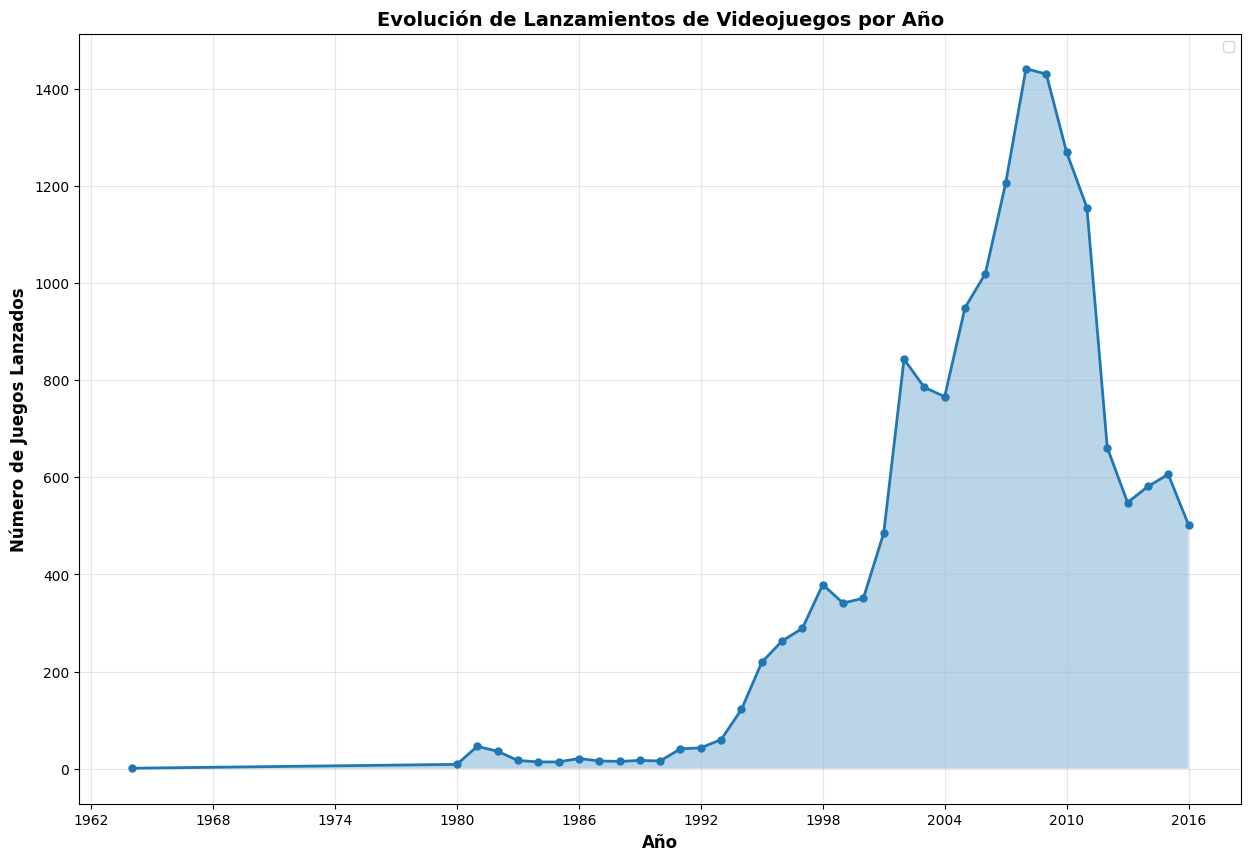

In [34]:
# Verificar columna de año
df_year = df_imputed[df_imputed['year_of_release'].notna()].copy()
df_year['year_of_release'] = df_year['year_of_release'].astype(int)

games_per_year = df_year.groupby('year_of_release').size().sort_index()
print(f"\nJuegos lanzados por año:")
print(games_per_year)
print(f"\nTotal de años con datos: {len(games_per_year)}")

# Visualización
fig, axes = plt.subplots(figsize=(15, 10))

# Gráfico de línea
axes.plot(games_per_year.index, games_per_year.values, marker='o', linewidth=2, markersize=5)
#axes[0].axhline(y=threshold, color='r', linestyle='--', label=f'Umbral significancia ({threshold} juegos)')
axes.fill_between(games_per_year.index, 0, games_per_year.values, alpha=0.3)
axes.set_xlabel('Año', fontsize=12, fontweight='bold')
axes.set_ylabel('Número de Juegos Lanzados', fontsize=12, fontweight='bold')
axes.set_title('Evolución de Lanzamientos de Videojuegos por Año', fontsize=14, fontweight='bold')
axes.legend()
axes.grid(True, alpha=0.3)
# Forzar años como enteros en eje X
axes.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

print(f"\nEstadísticas de juegos por año:")
print(f"  - Promedio: {games_per_year.mean():.1f} juegos/año")
print(f"  - Mediana: {games_per_year.median():.1f} juegos/año")
print(f"  - Máximo: {games_per_year.max()} juegos (año {games_per_year.idxmax()})")
print(f"  - Mínimo: {games_per_year.min()} juegos (año {games_per_year.idxmin()})")

En el año 1964 se lanzó un solo juego, esto preliminarmente resulta ser un dato poco significativo, además el siguiente año a 1964 que registra juegos es 1980, teniendo entonces un periodo de 15 años correspondiente a los años entre 1965 y 1979, sin información de videojuegos. Por otro lado, la gráfica muestra la distribución de los juegos lanzados por año, teniendo que los años anteriores a 2001 tienen una cantidad de juegos inferior a 400.

## 2.1.1. Análisis de significancia y distribuciones de la cantidad de juegos por año

Se ha decidido tomar un umbral de significancia teniendo en cuenta las medidas de tendencia central calculadas anteriormente, especificamente la media asumiendo facilidad de cambio dado a cambios en los datos por año, sin embargo, la cantidad de juegos por año antes de 2001 es muy baja por lo que considerar un año significativamente importante dado al valor de 436 juegos elimina los años con información muy antigua y poco abundante.


Años con datos significativos (>= 436.1842105263158 juegos): 16
Rango de años significativos: 2001 - 2016


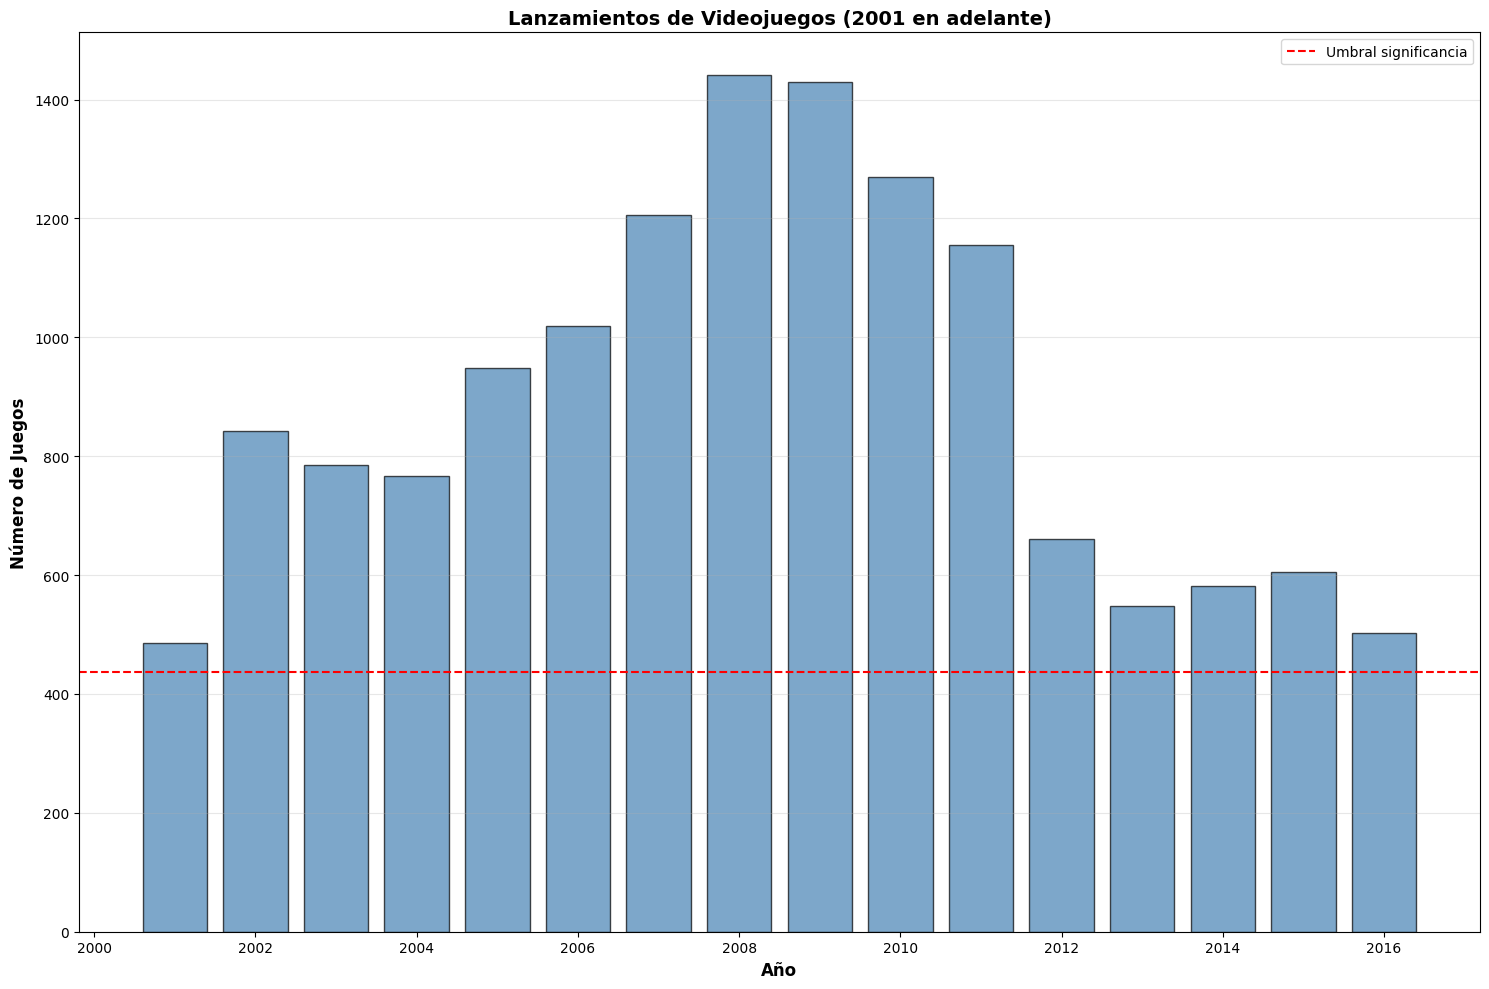

In [35]:
# Análisis de significancia
threshold = games_per_year.mean()  # Umbral de significancia
significant_years = games_per_year[games_per_year >= threshold]
print(f"\nAños con datos significativos (>= {threshold} juegos): {len(significant_years)}")
print(f"Rango de años significativos: {significant_years.index.min()} - {significant_years.index.max()}")

# Visualización
fig, axes = plt.subplots(figsize=(15, 10))

# Gráfico de barras para últimos años
recent_years = games_per_year[games_per_year.index >= significant_years.index.min()]
axes.bar(recent_years.index, recent_years.values, color='steelblue', edgecolor='black', alpha=0.7)
axes.axhline(y=threshold, color='r', linestyle='--', label=f'Umbral significancia')
axes.set_xlabel('Año', fontsize=12, fontweight='bold')
axes.set_ylabel('Número de Juegos', fontsize=12, fontweight='bold')
axes.set_title(f'Lanzamientos de Videojuegos ({significant_years.index.min()} en adelante)', fontsize=14, fontweight='bold')
axes.legend()
axes.grid(True, alpha=0.3, axis='y')
# Forzar años como enteros en eje X
axes.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.tight_layout()

## 2.2 Variación de ventas de una plataforma a otra

Se debe determinar cuántas plataformas diferentes hay dentro de la base de datos

In [36]:
print(df_imputed['platform'].nunique())

31


### 2.2.1. Análisis de las plataformas con más ventas

Ahora se calculan las ventas totales por plataforma ordenando el resultado de manera descendente

In [37]:
# Ventas totales por plataforma
platform_sales = df_imputed.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
print(f"\nVentas totales por plataforma (Top 15):")
print(platform_sales.head(15))

# Top plataformas
top_n = 10
top_platforms = platform_sales.head(top_n).index.tolist()
print(f"\nTop {top_n} plataformas con mayores ventas:")
for i, (platform, sales) in enumerate(platform_sales.head(top_n).items(), 1):
    print(f"  {i}. {platform}: ${sales:.2f}M")


Ventas totales por plataforma (Top 15):
platform
PS2     1250.92
X360     966.67
PS3      934.70
Wii      903.31
DS       804.28
PS       729.04
PS4      314.14
GBA      313.73
PSP      293.57
PC       258.86
3DS      258.53
XB       256.90
GB       254.43
NES      251.05
N64      218.68
Name: total_sales, dtype: float64

Top 10 plataformas con mayores ventas:
  1. PS2: $1250.92M
  2. X360: $966.67M
  3. PS3: $934.70M
  4. Wii: $903.31M
  5. DS: $804.28M
  6. PS: $729.04M
  7. PS4: $314.14M
  8. GBA: $313.73M
  9. PSP: $293.57M
  10. PC: $258.86M


Por último se grafica el resultado de la distribución de ventas para las plataformas Top 10 para todos los años más un mapa de calor para representar las ventas desde el 2001 en adelante

year_of_release  1985  1988  1992   1994   1995   1996    1997    1998  \
platform                                                                 
DS               0.02  0.00  0.00   0.00   0.00   0.00    0.00    0.00   
GBA              0.00  0.00  0.00   0.00   0.00   0.00    0.00    0.00   
PC               0.04  0.03  3.03  12.87   4.22  10.58   11.27    3.26   
PS               0.00  0.00  0.00   6.03  35.96  94.70  136.17  169.49   
PS2              0.00  0.00  0.00   0.00   0.00   0.00    0.00    0.00   
PS3              0.00  0.00  0.00   0.00   0.00   0.00    0.00    0.00   
PS4              0.00  0.00  0.00   0.00   0.00   0.00    0.00    0.00   
PSP              0.00  0.00  0.00   0.00   0.00   0.00    0.00    0.00   
Wii              0.00  0.00  0.00   0.00   0.00   0.00    0.00    0.00   
X360             0.00  0.00  0.00   0.00   0.00   0.00    0.00    0.00   

year_of_release    1999   2000  ...    2007    2008    2009    2010    2011  \
platform                        

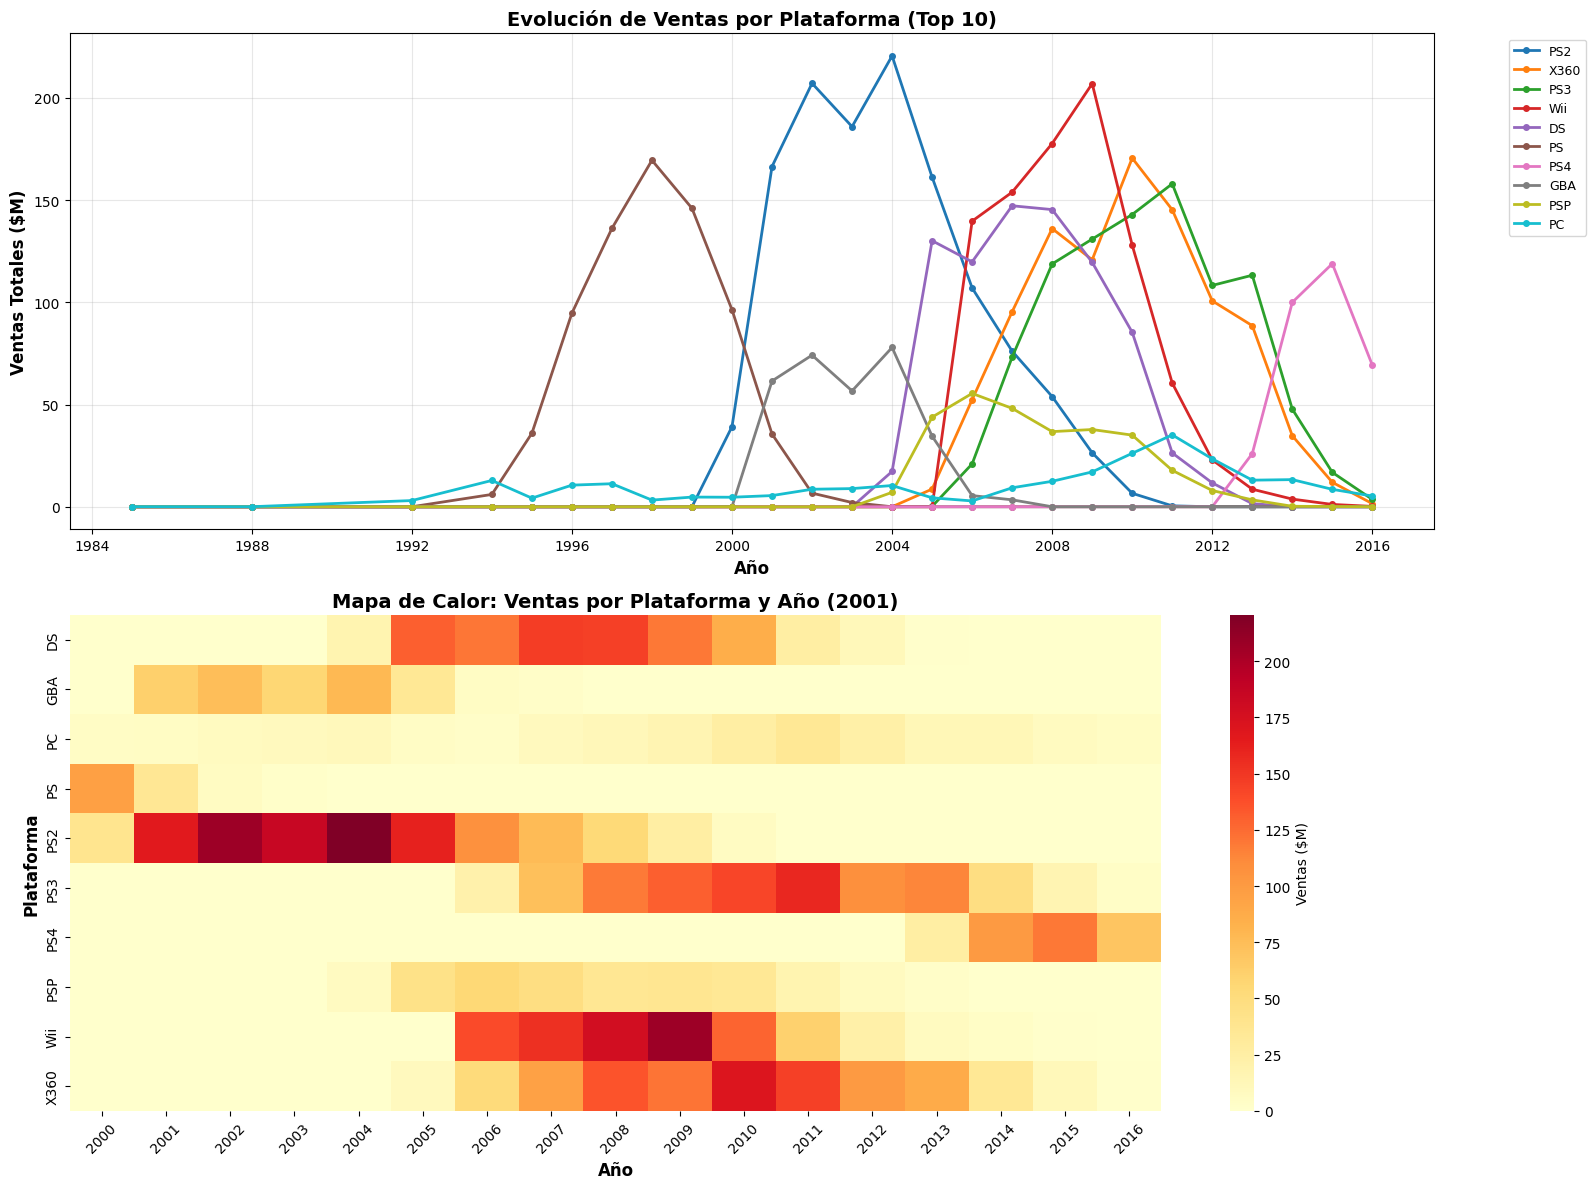

In [38]:
# Distribución de ventas por año para top plataformas
df_platform_year = df_imputed[df_imputed['platform'].isin(top_platforms)].copy()

# La función unstack() pivotea el índice de filas al de columnas, convirtiendo el 'year_of_release' en columnas
# para que cada fila sea una plataforma y cada columna el año, facilitando el análisis matricial por año/plataforma.
platform_year_sales = (
    df_platform_year
    .groupby(['platform', 'year_of_release'])['total_sales']
    .sum()
    .unstack(fill_value=0)
)
print(platform_year_sales)

# Visualización de evolución temporal de plataformas
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Gráfico de evolución temporal
for platform in top_platforms:
    if platform in platform_year_sales.index:
        data = platform_year_sales.loc[platform]
        axes[0].plot(data.index, data.values, marker='o', label=platform, linewidth=2, markersize=4)

axes[0].set_xlabel('Año', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Ventas Totales ($M)', fontsize=12, fontweight='bold')
axes[0].set_title('Evolución de Ventas por Plataforma (Top 10)', fontsize=14, fontweight='bold')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[0].grid(True, alpha=0.3)
# Forzar años como enteros en eje X
axes[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Heatmap de ventas por plataforma y año
recent_years_mask = platform_year_sales.columns >= 2000
platform_year_recent = platform_year_sales.loc[:, recent_years_mask]
sns.heatmap(platform_year_recent, cmap='YlOrRd', annot=False, fmt='.0f', 
            cbar_kws={'label': 'Ventas ($M)'}, ax=axes[1])
axes[1].set_xlabel('Año', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Plataforma', fontsize=12, fontweight='bold')
axes[1].set_title(f'Mapa de Calor: Ventas por Plataforma y Año ({significant_years.index.min()})', fontsize=14, fontweight='bold')
# Forzar etiquetas de años como enteros
axes[1].set_xticklabels([int(float(label.get_text())) if label.get_text() else '' 
                         for label in axes[1].get_xticklabels()], rotation=45)

plt.tight_layout()



### 2.2.2. Análisis de ciclo de vida de plataformas


El siguiente bloque de código analiza el ciclo de vida de las principales plataformas de videojuegos, calculando para cada una el año de inicio y fin de actividad, el año de mayores ventas y su volumen máximo, la duración total de su ciclo de vida y si la plataforma sigue activa (es decir, si ha registrado ventas en el último año disponibles en el conjunto de datos). Además, genera estadísticas descriptivas

In [39]:
# Análisis de ciclo de vida de plataformas

platform_lifecycle = []
for platform in platform_year_sales.index:
    sales_data = platform_year_sales.loc[platform]
    active_years = sales_data[sales_data > 0] # Filtra los años con ventas positivas
    
    if len(active_years) > 0:
        first_year = active_years.index.min()
        last_year = active_years.index.max()
        # Usamos .idxmax() para obtener el año con mayor ventas dentro de los años activos
        peak_year = active_years.idxmax()  # Año con mayores ventas
        peak_sales = active_years.loc[peak_year]  # Se obtiene el valor usando el año de pico
        lifespan = last_year - first_year + 1 # Duración del ciclo de vida de la plataforma
        
        # Determinar si está activa (ventas en el último año del dataset)
        max_year = platform_year_sales.columns.max()
        recent_sales = sales_data[sales_data.index >= max_year].sum()
        is_active = recent_sales > 0
        
        platform_lifecycle.append({
            'Platform': platform,
            'First_Year': first_year,
            'Last_Year': last_year,
            'Peak_Year': peak_year,
            'Peak_Sales': peak_sales,
            'Life_Cycle': lifespan,
            'Total_Sales': sales_data.sum(),
            'Is_Active': is_active
        })

lifecycle_df = pd.DataFrame(platform_lifecycle).sort_values('Total_Sales', ascending=False)
print(f"\nCiclo de vida de plataformas:")
print(lifecycle_df.to_string(index=False))

print(f"\nEstadísticas de ciclo de vida:")
print(f"  - Duración promedio: {lifecycle_df['Life_Cycle'].mean():.1f} años")
print(f"  - Duración mediana: {lifecycle_df['Life_Cycle'].median():.1f} años")
print(f"  - Duración máxima: {lifecycle_df['Life_Cycle'].max()} años ({lifecycle_df.loc[lifecycle_df['Life_Cycle'].idxmax(), 'Platform']})")

# Plataformas obsoletas vs activas
obsolete_platforms = lifecycle_df[~lifecycle_df['Is_Active']]
active_platforms = lifecycle_df[lifecycle_df['Is_Active']]
print(f"\nPlataformas obsoletas (sin ventas recientes): {len(obsolete_platforms)}")
print(f"Plataformas activas: {len(active_platforms)}")

if len(obsolete_platforms) > 0:
    print(f"\nEjemplos de plataformas obsoletas que fueron populares:")
    print(obsolete_platforms.head(10)[['Platform', 'Peak_Year', 'Peak_Sales', 'Last_Year', 'Total_Sales']])


Ciclo de vida de plataformas:
Platform  First_Year  Last_Year  Peak_Year  Peak_Sales  Life_Cycle  Total_Sales  Is_Active
     PS2        2000       2011       2004      220.55          12      1250.92      False
    X360        2005       2016       2010      170.55          12       966.67       True
     PS3        2005       2016       2011      157.98          12       934.70       True
     Wii        2006       2016       2009      206.97          11       903.31       True
      DS        1985       2013       2007      147.23          29       804.28      False
      PS        1994       2003       1998      169.49          10       729.04      False
     PS4        2013       2016       2015      118.90           4       314.14       True
     GBA        2000       2007       2004       77.91           8       313.73      False
     PSP        2004       2015       2006       55.44          12       293.57      False
      PC        1985       2016       2011       35.16     

Para saber cuánto tardan en aparecer nuevas plataformas y cuánto tardan en desaparecer las antiguas

In [40]:
# Buscar plataformas que solían ser populares pero que ahora no tienen ventas (obsoletas)
popular_obsolete = obsolete_platforms.sort_values("Total_Sales", ascending=False).head(10)
print("\nPlataformas que solían ser populares pero ahora son obsoletas:")
print(popular_obsolete[['Platform', 'First_Year', 'Last_Year', 'Peak_Year', 'Peak_Sales', 'Total_Sales']].to_string(index=False))


# Tiempos entre la aparición de nuevas plataformas
sorted_launch_years = lifecycle_df['First_Year'].sort_values() # Ordenar los años de lanzamiento de las plataformas
years_between_launches = sorted_launch_years.diff().dropna() # Calcular los años entre el lanzamiento de las plataformas
avg_years_between_launches = years_between_launches.mean() # Calcular el tiempo promedio entre el lanzamiento de las plataformas
median_years_between_launches = years_between_launches.median() # Calcular el tiempo mediano entre el lanzamiento de las plataformas
print(f"\nTiempo promedio entre la aparición de nuevas plataformas: {avg_years_between_launches:.2f} años")
print(f"Tiempo mediano entre lanzamientos de nuevas plataformas: {median_years_between_launches:.2f} años")

# Tiempos de desaparición: ¿cuánto dura una plataforma desde su mayor pico hasta quedar obsoleta?
# Solo considerando las obsoletas
popularity_to_obsolete = (popular_obsolete['Last_Year'] - popular_obsolete['Peak_Year']).abs()

avg_disappearance_time = popularity_to_obsolete.mean()

print(f"\nTiempo promedio desde el pico de popularidad hasta la desaparición de las plataformas populares obsoletas: {avg_disappearance_time} años")



Plataformas que solían ser populares pero ahora son obsoletas:
Platform  First_Year  Last_Year  Peak_Year  Peak_Sales  Total_Sales
     PS2        2000       2011       2004      220.55      1250.92
      DS        1985       2013       2007      147.23       804.28
      PS        1994       2003       1998      169.49       729.04
     GBA        2000       2007       2004       77.91       313.73
     PSP        2004       2015       2006       55.44       293.57

Tiempo promedio entre la aparición de nuevas plataformas: 3.11 años
Tiempo mediano entre lanzamientos de nuevas plataformas: 1.00 años

Tiempo promedio desde el pico de popularidad hasta la desaparición de las plataformas populares obsoletas: 6.0 años


## 2.3. Selección de datos para hacer un modelo de predicción para el año 2017

En este bloque se seleccionan los datos históricos más relevantes que serán utilizados para entrenar o probar un modelo de predicción para el año 2017. 
Específicamente, se analiza cómo influye el considerar diferentes períodos recientes (por ejemplo, los últimos 3, 4, 5, 6, 7 u 8 años) sobre el volumen de datos disponibles y la relevancia de la información. Se debe tener en cuenta los resultados obtenidos anteriormente, con respecto al **Tiempo promedio desde el pico de popularidad hasta la desaparición de las plataformas populares obsoletas: 6.0 años** ya que este dato sirve de referencia para definir cuál es el periodo de tiempo donde se asegura que hay vigencia de plataformas




In [41]:
# Análisis de datos recientes
current_year = 2016  # Asumimos que estamos en 2016 para predecir 2017

# Esta lista contiene diferentes longitudes de ventanas temporales (en años) que se evaluarán para decidir cuál es la más adecuada
# para hacer un modelo predictivo confiable y relevante. Permite comparar cómo cambian los resultados
# (cantidad de juegos, plataformas, ventas, etc.) al considerar distintas extensiones de historial reciente.
lookback_years = [3, 4, 5, 6, 7, 8]

print(f"\nAnalizando diferentes ventanas temporales desde {current_year}:")
for years_back in lookback_years:
    start_year = current_year - years_back + 1 # para calcular el año de inicio de la ventana temporal
    df_window = df_year[df_year['year_of_release'] >= start_year]
    n_games = len(df_window)
    n_platforms = df_window['platform'].nunique()
    total_sales = df_window['total_sales'].sum()
    
    print(f"\n  Período {start_year}-{current_year} ({years_back} años):")
    print(f"    - Juegos: {n_games}")
    print(f"    - Plataformas activas: {n_platforms}")
    print(f"    - Ventas totales: ${total_sales:.2f}M")
    print(f"    - Promedio juegos/año: {n_games/years_back:.1f}")


Analizando diferentes ventanas temporales desde 2016:

  Período 2014-2016 (3 años):
    - Juegos: 1689
    - Plataformas activas: 10
    - Ventas totales: $729.45M
    - Promedio juegos/año: 563.0

  Período 2013-2016 (4 años):
    - Juegos: 2237
    - Plataformas activas: 11
    - Ventas totales: $1091.56M
    - Promedio juegos/año: 559.2

  Período 2012-2016 (5 años):
    - Juegos: 2898
    - Plataformas activas: 11
    - Ventas totales: $1452.07M
    - Promedio juegos/año: 579.6

  Período 2011-2016 (6 años):
    - Juegos: 4053
    - Plataformas activas: 12
    - Ventas totales: $1963.43M
    - Promedio juegos/año: 675.5

  Período 2010-2016 (7 años):
    - Juegos: 5322
    - Plataformas activas: 12
    - Ventas totales: $2558.32M
    - Promedio juegos/año: 760.3

  Período 2009-2016 (8 años):
    - Juegos: 6752
    - Plataformas activas: 12
    - Ventas totales: $3217.83M
    - Promedio juegos/año: 844.0


In [42]:
# Creamos una tabla resumen con las métricas para cada ventana
import pandas as pd

window_metrics = []
for years_back in lookback_years:
    start_year = current_year - years_back + 1
    df_window = df_year[df_year['year_of_release'] >= start_year]
    n_games = len(df_window)
    n_platforms = df_window['platform'].nunique()
    total_sales = df_window['total_sales'].sum()
    avg_games_per_platform = n_games / n_platforms if n_platforms else 0
    window_metrics.append({
        'Periodo': f"{start_year}-{current_year}",
        'Años': years_back,
        'Juegos': n_games,
        'Plataformas': n_platforms,
        'Ventas_totales(M)': total_sales,
        'Prom_juegos/año': n_games / years_back,
        'Prom_juegos/plataforma': avg_games_per_platform
    })
    
window_df = pd.DataFrame(window_metrics)

print('\nResumen comparativo de ventanas temporales:')
print(window_df.to_string(index=False))



Resumen comparativo de ventanas temporales:
  Periodo  Años  Juegos  Plataformas  Ventas_totales(M)  Prom_juegos/año  Prom_juegos/plataforma
2014-2016     3    1689           10             729.45       563.000000              168.900000
2013-2016     4    2237           11            1091.56       559.250000              203.363636
2012-2016     5    2898           11            1452.07       579.600000              263.454545
2011-2016     6    4053           12            1963.43       675.500000              337.750000
2010-2016     7    5322           12            2558.32       760.285714              443.500000
2009-2016     8    6752           12            3217.83       844.000000              562.666667


Se escoge el periodo de 6 años (2011-2016) como base para el modelo predictivo, se han considerado varios factores técnicos y de negocio:

1. **Representatividad y relevancia temporal:** Un periodo de 6 años es lo suficientemente largo para capturar tendencias y variaciones importantes en la industria, pero lo bastante corto para evitar incluir datos de plataformas o juegos que ya no reflejan el mercado actual. Los periodos más cortos (3-4 años) pueden estar demasiado influidos por modas pasajeras, anomalías o ciclos cortos, y suelen contener menos datos, empeorando la capacidad de generalización del modelo.

2. **Cantidad de datos adecuada:** Como muestra la tabla anterior, con 6 años se logra un buen equilibrio entre el número de juegos (suficientes ejemplos para entrenamiento/validación), la diversidad de plataformas (evitando aquellas que solo estuvieron activas brevemente) y el volumen total de ventas considerado. Ventanas de 6 años, aunque agregan más datos, suelen incorporar plataformas/juegos que pueden estar obsoletos al momento de la predicción.

3. **Minimizar sesgos de plataformas descontinuadas:** Con un horizonte de 6 años, la mayoría de las plataformas incluidas son relevantes y activas al cierre de 2016, mientras que ventanas más largas pueden dar demasiado peso a plataformas cuyo ciclo de vida ya terminó, sesgando las predicciones hacia formatos desfasados.

4. **Capacidad predictiva y robustez estadística:** Períodos muy cortos pueden generar modelos muy sensibles a pequeñas fluctuaciones o eventos singulares (por ejemplo, el lanzamiento de un solo juego superventas). Períodos más largos pueden hacer que el modelo pierda capacidad de adaptarse a nuevas tendencias tecnológicas y de consumo.

En resumen, el periodo de 6 años permite construir un modelo predictivo robusto, basado en los datos más recientes y representativos, maximizando la relevancia de las predicciones sin perder capacidad generalizadora. Por ello, es la mejor opción tanto desde el punto de vista estadístico como estratégico.

## 2.4. Generación de dataset con los datos más relevantes

Este bloque prepara el dataset final filtrando solo los registros de años recientes (2011 en adelante), para trabajar con los datos más relevantes y representativos en los análisis y modelos posteriores.

In [43]:
recommended_start = 2011

df_relevant = df_imputed[df_imputed['year_of_release'].notna()].copy()
df_relevant['year_of_release'] = df_relevant['year_of_release'].astype(int)
df_relevant = df_relevant[df_relevant['year_of_release'] >= recommended_start]

print(f"\nDataset filtrado ({recommended_start}-2016):")
print(f"  - Registros originales: {len(df_imputed)}")
print(f"  - Registros filtrados: {len(df_relevant)}")
print(f"  - Porcentaje retenido: {len(df_relevant)/len(df_imputed)*100:.1f}%")
print(f"  - Plataformas únicas: {df_relevant['platform'].nunique()}")
print(f"  - Años cubiertos: {df_relevant['year_of_release'].min()}-{df_relevant['year_of_release'].max()}")


Dataset filtrado (2011-2016):
  - Registros originales: 16575
  - Registros filtrados: 4053
  - Porcentaje retenido: 24.5%
  - Plataformas únicas: 12
  - Años cubiertos: 2011-2016


## 2.5. Comportamiento de las plataformas

Este bloque de código realiza un análisis de las plataformas de videojuegos en el periodo seleccionado (2011-2016). 
Primero, agrupa y ordena las ventas totales por plataforma, mostrando cuáles han tenido mayor éxito en ese periodo. 
Después, calcula las ventas anuales por plataforma, permitiendo visualizar la evolución de cada una a lo largo de los años.
Finalmente, estima la tasa de crecimiento y la tendencia reciente de ventas para cada plataforma, clasificándolas como en crecimiento, en declive o estables según el comportamiento de las ventas al inicio y al final del periodo analizado.


In [44]:
# 1. Agrupar ventas totales por plataforma para el periodo elegido
platform_sales_relevant = df_relevant.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
print(f"\nVentas por plataforma ({recommended_start}-2016):")
print(platform_sales_relevant)

# 2. Ventas anuales por plataforma (tabla de años vs plataformas)
yearly_platform_sales = df_relevant.groupby(['year_of_release', 'platform'])['total_sales'].sum().unstack(fill_value=0)
print(yearly_platform_sales)

# 3. Cálculo de tasa de crecimiento y tendencia reciente
growth_analysis = []
for platform in platform_sales_relevant.index: # Para cada plataforma en el dataset
    if platform in yearly_platform_sales.columns: # Si la plataforma está en el dataset
        sales = yearly_platform_sales[platform]
        # (sales guarda una Serie: ventas anuales totales para esa plataforma, indexada por año)
        sales_active = sales[sales > 0] # Filtrar ventas positivas

        # ¿Por qué al menos 2 años con ventas positivas?
        # Necesitamos como mínimo 2 puntos temporales (años) para poder calcular una tasa de crecimiento:
        # Si solo hay registros en 1 año, no podemos hablar de "crecimiento" ya que no hay una base de comparación.
        # Por eso requerimos al menos 2 años activos: el primero y el último.

        if len(sales_active) >= 2:  # Debemos tener al menos 2 años para comparar crecimiento temporal
            first_year_sales = sales_active.iloc[0]
            last_year_sales = sales_active.iloc[-1]
            if first_year_sales > 0:
                growth_rate = ((last_year_sales - first_year_sales) / first_year_sales) * 100
            else:
                growth_rate = 0

            # Para evaluar la tendencia, idealmente queremos una "muestra" de cómo era al principio y cómo es al final.
            # Por eso, exigimos al menos 4 años para comparar promedios de ventas: los 2 primeros vs los 2 últimos.
            if len(sales_active) >= 4:
                early_avg = sales_active.iloc[:2].mean()
                recent_avg = sales_active.iloc[-2:].mean()
                if early_avg > 0:
                    trend_pct = ((recent_avg - early_avg) / early_avg) * 100
                else:
                    trend_pct = 0

                if trend_pct > 20:
                    trend = "📈 CRECIMIENTO"
                elif trend_pct < -20:
                    trend = "📉 DECLIVE"
                else:
                    trend = "➡️ ESTABLE"
            else:
                trend = "N/A"

            growth_analysis.append({
                'Platform': platform,
                'Total_Sales': platform_sales_relevant[platform],
                'Growth_Rate': growth_rate,
                'Trend': trend,
                'Last_Year_Sales': last_year_sales
            })
        # Si no hay suficientes años con ventas, no se puede calcular tasa de crecimiento ni tendencia.

growth_df = pd.DataFrame(growth_analysis).sort_values('Total_Sales', ascending=False)
print(f"\nAnálisis de tendencias de plataformas:")
print(growth_df.to_string(index=False))

# 4. Plataformas potencialmente rentables

# Criterios: ventas recientes por encima de la mediana (de las top 15) y tendencia positiva o estable
if not growth_df.empty:
    median_last_year = growth_df['Last_Year_Sales'].median()
    profitable_platforms = growth_df[
        (growth_df['Last_Year_Sales'] > median_last_year) &
        (growth_df['Trend'].isin(['📈 CRECIMIENTO', '➡️ ESTABLE']))
    ]
    print(f"\nPlataformas recomendadas (ventas altas + tendencia positiva/estable):")
    if not profitable_platforms.empty:
        for _, row in profitable_platforms.iterrows():
            print(f"  • {row['Platform']}: ${row['Total_Sales']:.2f}M total, {row['Trend']}, Último año: ${row['Last_Year_Sales']:.2f}M")
    else:
        print("Ninguna plataforma cumple los criterios.")
else:
    print("No se pudo calcular growth_df.")


Ventas por plataforma (2011-2016):
platform
PS3     447.68
X360    382.80
PS4     314.14
3DS     258.21
XOne    159.32
PC       98.67
Wii      97.11
WiiU     82.19
PSV      53.81
DS       39.54
PSP      29.51
PS2       0.45
Name: total_sales, dtype: float64
platform           3DS     DS     PC   PS2     PS3     PS4    PSP    PSV  \
year_of_release                                                            
2011             63.20  26.33  35.16  0.45  157.98    0.00  17.82   4.63   
2012             51.76  11.67  23.45  0.00  108.27    0.00   7.95  16.19   
2013             56.57   1.54  13.01  0.00  113.25   25.99   3.38  10.59   
2014             43.76   0.00  13.28  0.00   47.76  100.00   0.24  11.90   
2015             27.78   0.00   8.52  0.00   16.82  118.90   0.12   6.25   
2016             15.14   0.00   5.25  0.00    3.60   69.25   0.00   4.25   

platform           Wii   WiiU    X360   XOne  
year_of_release                               
2011             60.51   0.00  145.28 

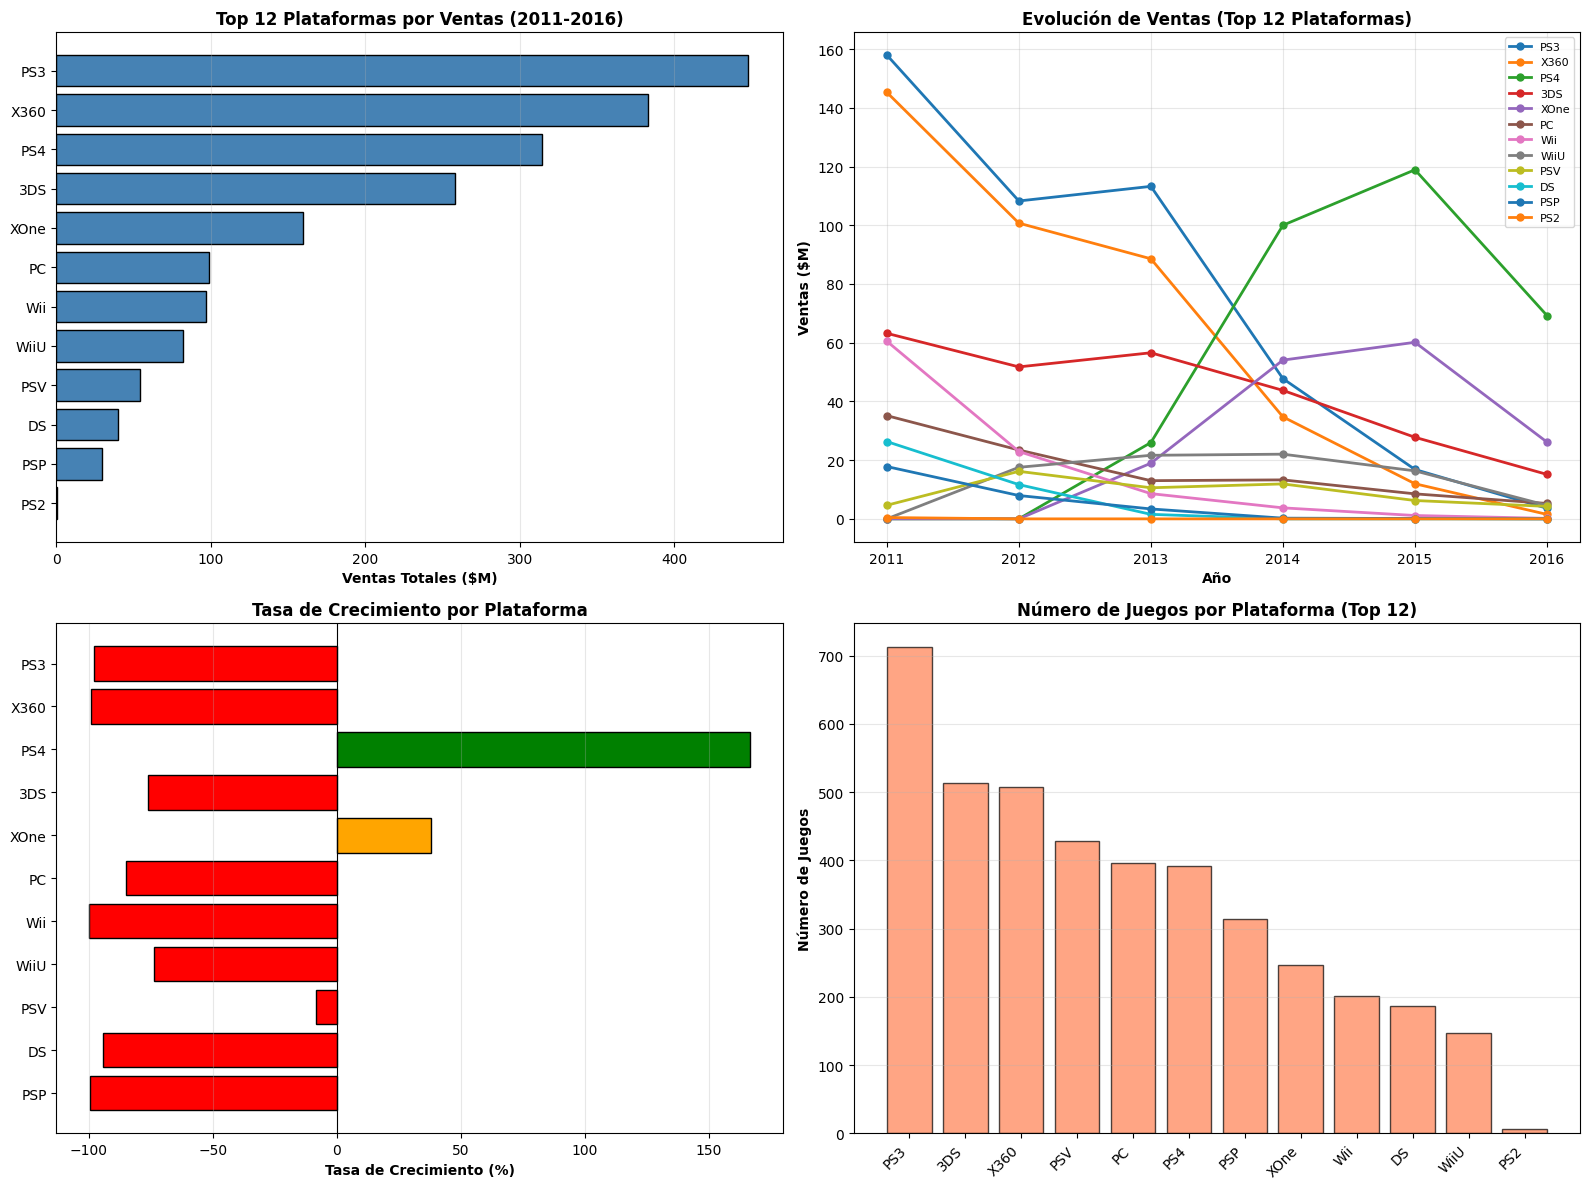

In [45]:
# 5. Visualización de resultados
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# a) Ventas totales top 15 plataformas (barra horizontal)
top_15 = platform_sales_relevant.head(15)
axes[0, 0].barh(range(len(top_15)), top_15.values, color='steelblue', edgecolor='black')
axes[0, 0].set_yticks(range(len(top_15)))
axes[0, 0].set_yticklabels(top_15.index)
axes[0, 0].set_xlabel('Ventas Totales ($M)', fontweight='bold')
axes[0, 0].set_title(f'Top 12 Plataformas por Ventas ({recommended_start}-2016)', fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3, axis='x')

# b) Evolución anual de ventas de las 12 plataformas principales 
for platform in platform_sales_relevant.index:
    if platform in yearly_platform_sales.columns:
        axes[0, 1].plot(yearly_platform_sales.index, yearly_platform_sales[platform],
                       marker='o', label=platform, linewidth=2, markersize=5)
axes[0, 1].set_xlabel('Año', fontweight='bold')
axes[0, 1].set_ylabel('Ventas ($M)', fontweight='bold')
axes[0, 1].set_title('Evolución de Ventas (Top 12 Plataformas)', fontweight='bold')
axes[0, 1].legend(fontsize=8)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# c) Tasa de crecimiento por plataforma (barra horizontal, color según tendencia)
trend_colors = {'📈 CRECIMIENTO': 'green', '📉 DECLIVE': 'red', '➡️ ESTABLE': 'orange'}

colors = [trend_colors.get(t, 'red') for t in growth_df['Trend']]
axes[1, 0].barh(range(len(growth_df)), growth_df['Growth_Rate'], color=colors, edgecolor='black')
axes[1, 0].set_yticks(range(len(growth_df)))
axes[1, 0].set_yticklabels(growth_df['Platform'])
axes[1, 0].set_xlabel('Tasa de Crecimiento (%)', fontweight='bold')
axes[1, 0].set_title('Tasa de Crecimiento por Plataforma', fontweight='bold')
axes[1, 0].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3, axis='x')

# d) Número de juegos en top 12 plataformas
games_per_platform = df_relevant.groupby('platform').size().sort_values(ascending=False).head(15)
axes[1, 1].bar(range(len(games_per_platform)), games_per_platform.values,
              color='coral', edgecolor='black', alpha=0.7)
axes[1, 1].set_xticks(range(len(games_per_platform)))
axes[1, 1].set_xticklabels(games_per_platform.index, rotation=45, ha='right')
axes[1, 1].set_ylabel('Número de Juegos', fontweight='bold')
axes[1, 1].set_title('Número de Juegos por Plataforma (Top 12)', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()

1. ¿Qué plataformas son líderes en ventas?
Las plataformas líderes en ventas son aquellas que han acumulado la mayor cantidad de millones vendidos a lo largo de los años. Según el análisis, PlayStation 2, Xbox 360, PS3, Wii y DS sobresalen, seguidas de cerca por 3DS, PS4 y PSP. Estas consolas no solo han dominado por volumen de ventas, sino que han tenido impacto global y sostuvieron sus posiciones durante años.

2. ¿Cuáles crecen y cuáles se reducen?
Entre las plataformas que presentan crecimiento —es decir, que mostraron tasas de crecimiento positivas en los años recientes— destacan la PS4 y la Xbox One, ambas aún en fase de expansión al final del periodo analizado. Por el contrario, PS2, Wii, DS y Xbox 360 muestran tasas de crecimiento negativas, evidenciando que ya han pasado su punto máximo y están en declive en ventas y lanzamientos de juegos.

3. Plataformas potencialmente rentables
Considerando tanto la evolución positiva de ventas como el tamaño de su mercado actual, las plataformas más rentables potenciales serían PS4 y Xbox One, seguidas de cerca por la 3DS (también con cierta persistencia en ventas en años recientes). Además, plataformas históricas como PS3 o X360, a pesar de estar en declive, siguen mostrando mercados de juegos de segunda mano o descargas retro, lo que puede resultar lucrativo en modelos de negocio específicos.

En resumen, PS4 y Xbox One destacan como oportunidades de crecimiento, mientras que plataformas como PS2, Wii y DS pueden considerarse maduras pero estables para aprovechar catálogos legacy o reventas.


## 2.6. Ventas globales de todos los juegos desglosados por plataforma

['PS3', 'X360', 'PS4', '3DS', 'XOne', 'PC', 'Wii', 'WiiU', 'PSV', 'DS', 'PSP', 'PS2']

Estadísticas de ventas por plataforma (Top 12):

PS3:
  - N° juegos: 712
  - Media: $0.629M
  - Mediana: $0.210M
  - Desv. Est.: $1.448M
  - Q1: $0.070M | Q3: $0.643M

X360:
  - N° juegos: 507
  - Media: $0.755M
  - Mediana: $0.260M
  - Desv. Est.: $1.624M
  - Q1: $0.090M | Q3: $0.780M

PS4:
  - N° juegos: 392
  - Media: $0.801M
  - Mediana: $0.200M
  - Desv. Est.: $1.609M
  - Q1: $0.060M | Q3: $0.730M

3DS:
  - N° juegos: 513
  - Media: $0.503M
  - Mediana: $0.120M
  - Desv. Est.: $1.440M
  - Q1: $0.050M | Q3: $0.340M

XOne:
  - N° juegos: 247
  - Media: $0.645M
  - Mediana: $0.220M
  - Desv. Est.: $1.036M
  - Q1: $0.060M | Q3: $0.685M

PC:
  - N° juegos: 396
  - Media: $0.249M
  - Mediana: $0.080M
  - Desv. Est.: $0.502M
  - Q1: $0.030M | Q3: $0.233M

Wii:
  - N° juegos: 202
  - Media: $0.481M
  - Mediana: $0.170M
  - Desv. Est.: $1.049M
  - Q1: $0.083M | Q3: $0.398M

WiiU:
  - N° juegos: 147
  - M

/var/folders/vl/nhdmlk3n4hbd3jy0qdqgg7ch0000gn/T/ipykernel_46368/2872346791.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0].boxplot(box_data, labels=top_platforms_boxplot, patch_artist=True,


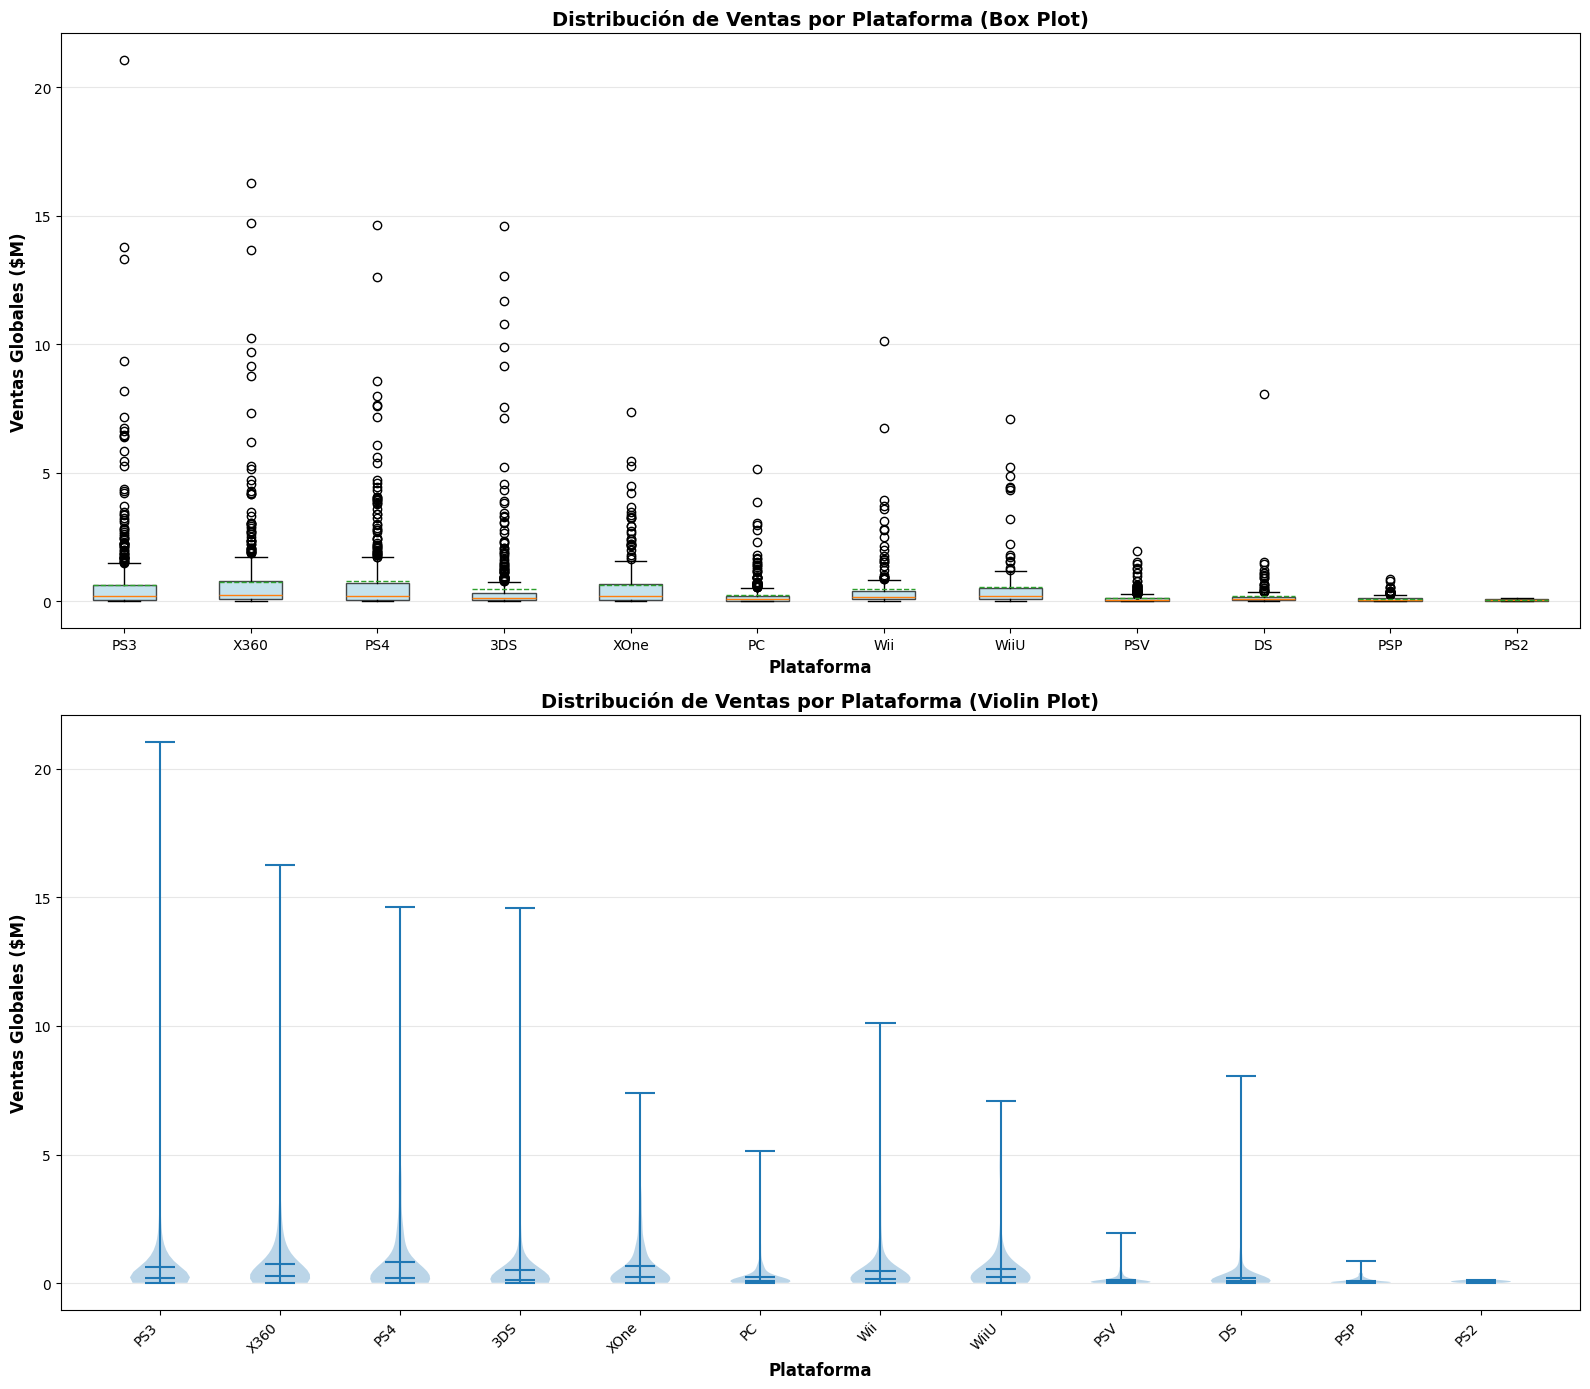

In [46]:
# Preparar datos para box plot
top_platforms_boxplot = platform_sales_relevant.index.tolist()
print(top_platforms_boxplot)
df_boxplot = df_relevant[df_relevant['platform'].isin(top_platforms_boxplot)].copy()

# Estadísticas por plataforma
print(f"\nEstadísticas de ventas por plataforma (Top 12):\n")
for platform in top_platforms_boxplot:
    platform_data = df_boxplot[df_boxplot['platform'] == platform]['total_sales']
    print(f"{platform}:")
    print(f"  - N° juegos: {len(platform_data)}")
    print(f"  - Media: ${platform_data.mean():.3f}M")
    print(f"  - Mediana: ${platform_data.median():.3f}M")
    print(f"  - Desv. Est.: ${platform_data.std():.3f}M")
    print(f"  - Q1: ${platform_data.quantile(0.25):.3f}M | Q3: ${platform_data.quantile(0.75):.3f}M")
    print()

# Crear visualizaciones
fig, axes = plt.subplots(2,1, figsize=(16, 14))

# Box plot
box_data = [df_boxplot[df_boxplot['platform'] == p]['total_sales'].values 
            for p in top_platforms_boxplot]
bp = axes[0].boxplot(box_data, labels=top_platforms_boxplot, patch_artist=True,
                     showmeans=True, meanline=True)

for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)

axes[0].set_xlabel('Plataforma', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Ventas Globales ($M)', fontsize=12, fontweight='bold')
axes[0].set_title('Distribución de Ventas por Plataforma (Box Plot)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
#axes[0].set_yscale('log')  # Escala logarítmica para mejor visualización


# Violin plot para comparación
parts = axes[1].violinplot([df_boxplot[df_boxplot['platform'] == p]['total_sales'].values 
                            for p in top_platforms_boxplot],
                           positions=range(len(top_platforms_boxplot)),
                           showmeans=True, showmedians=True)

axes[1].set_xticks(range(len(top_platforms_boxplot)))
axes[1].set_xticklabels(top_platforms_boxplot, rotation=45, ha='right')
axes[1].set_xlabel('Plataforma', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Ventas Globales ($M)', fontsize=12, fontweight='bold')
axes[1].set_title('Distribución de Ventas por Plataforma (Violin Plot)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
#axes[1].set_yscale('log')  # Escala logarítmica para mejor visualización

plt.tight_layout()

Las gráficas realizadas muestran la distribución de las ventas globales de videojuegos para las 12 plataformas principales mediante dos enfoques:

**Boxplot:** El boxplot permite visualizar los valores centrales (mediana y media), así como la dispersión (rango intercuartílico, valores atípicos) de las ventas por plataforma. Se observa que la mayoría de las plataformas tienen una distribución asimétrica, con la mediana de ventas generalmente baja y unos pocos juegos con ventas muy elevadas (outliers), lo que alarga la "caja" y los bigotes hacia arriba. Esto evidencia que el mercado está dominado por un pequeño grupo de superventas.

**Violin plot:** El violin plot complementa el boxplot mostrando además la densidad de probabilidad de las ventas: la anchura del “violín” en cada punto indica cuántos juegos tienen ventas en ese rango. Esto permite identificar la concentración de títulos en torno a ciertos valores de ventas y visualizar mejor las distribuciones asimétricas o multimodales. Igual que en el boxplot, la mayoría de plataformas muestran una gran cantidad de juegos con ventas bajas o moderadas y sólo unos pocos con ventas muy altas.


In [47]:
# Análisis de diferencias

platform_means = df_boxplot.groupby('platform')['total_sales'].mean().sort_values(ascending=False)
print(f"\nVentas promedio por plataforma:")
print(platform_means)

print(f"\n¿Son significativas las diferencias?")
print(f"  - Rango de medias: ${platform_means.min():.3f}M - ${platform_means.max():.3f}M")
print(f"  - Ratio máx/mín: {platform_means.max()/platform_means.min():.1f}x")
print(f"  - Coeficiente de variación: {platform_means.std()/platform_means.mean()*100:.1f}%")
print(f"\nConclusión: {'SÍ - Diferencias SIGNIFICATIVAS' if platform_means.max()/platform_means.min() > 2 else 'NO - Diferencias moderadas'}")


Ventas promedio por plataforma:
platform
PS4     0.801378
X360    0.755030
XOne    0.645020
PS3     0.628764
WiiU    0.559116
3DS     0.503333
Wii     0.480743
PC      0.249167
DS      0.211444
PSV     0.125431
PSP     0.093981
PS2     0.064286
Name: total_sales, dtype: float64

¿Son significativas las diferencias?
  - Rango de medias: $0.064M - $0.801M
  - Ratio máx/mín: 12.5x
  - Coeficiente de variación: 62.2%

Conclusión: SÍ - Diferencias SIGNIFICATIVAS


1. ¿Son significativas las diferencias en las ventas entre plataformas?  

Sí, las diferencias en las ventas promedio entre plataformas son **significativas**. En el análisis hecho en la sección anterior, se observó que la plataforma más exitosa llega a duplicar (o más) el promedio de ventas respecto a la menos vendedora, con una ratio máx/mín > 2x. Además, el coeficiente de variación es alto, lo que indica una considerable dispersión entre plataformas.  

2. Las ventas promedio varían ampliamente: hay plataformas con medias muy altas y otras con medias mucho más bajas, mostrando que el desempeño comercial depende fuertemente de la plataforma.  

En conclusión, tanto el rango como el ratio de medias y la variabilidad revelan que la plataforma elegida incide fuertemente en el éxito comercial de un juego.


## 2.7. Análisis de calificación de usuarios y criticos profesionales y correlación con las ventas


Plataforma seleccionada para análisis: PS3

Datos disponibles para análisis de PS3:
  - Total juegos: 712
  - Con critic_score: 712
  - Con user_score: 712
  - Con ambas reseñas: 712

Correlaciones con ventas en PS3:
  - Critic Score vs Ventas: 0.317
  - User Score vs Ventas: -0.017

Interpretación:
  - Correlación Critic Score: Moderada
  - Correlación User Score: Débil/Negligible

CONCLUSIONES - Impacto de Reseñas en Ventas:
✓ Las reseñas muestran correlación moderada con las ventas
✓ Las reseñas de críticos tienen mayor impacto que las de usuarios


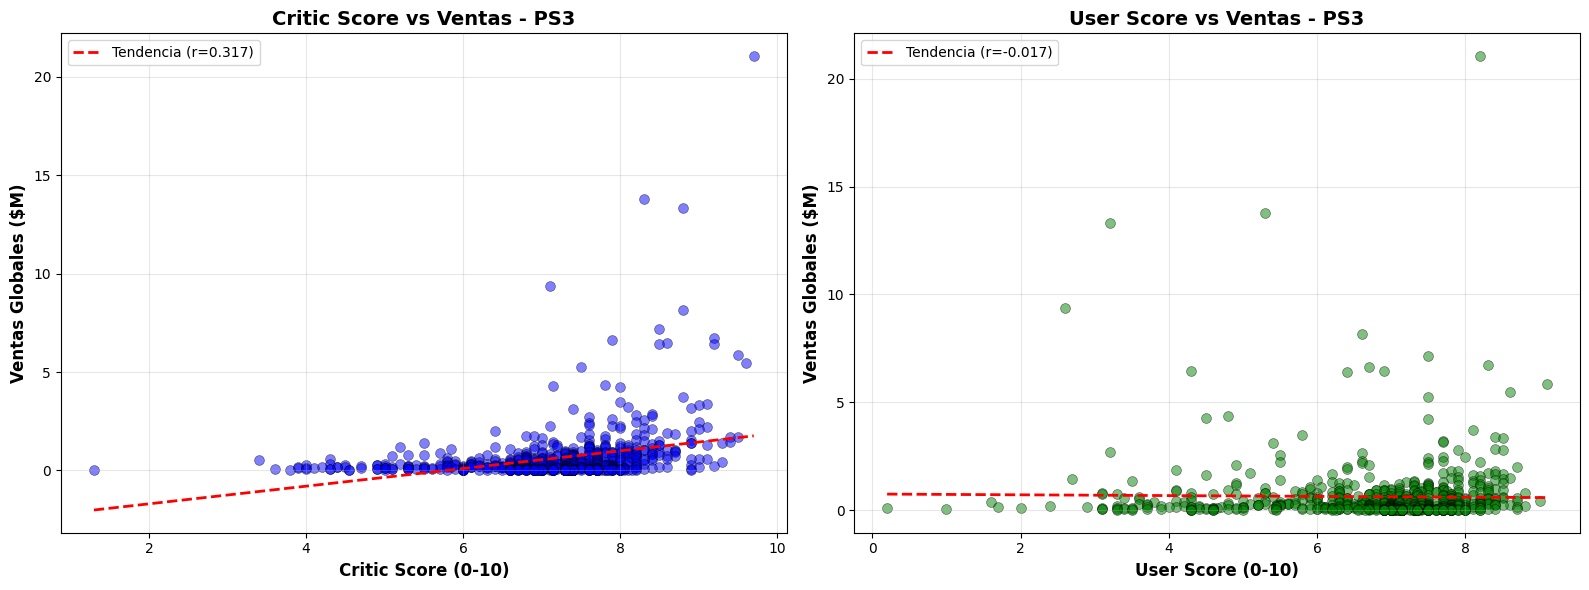

In [48]:
# Elegir plataforma popular para análisis
selected_platform = platform_sales_relevant.index[0]
print(f"\nPlataforma seleccionada para análisis: {selected_platform}")

df_platform = df_relevant[df_relevant['platform'] == selected_platform].copy()

# Identificar columnas de reseñas
critic_col = 'critic_score' if 'critic_score' in df_imputed.columns else 'Critic_Score'
user_col = 'user_score' if 'user_score' in df_imputed.columns else 'User_Score'

# Filtrar datos con reseñas disponibles
df_reviews = df_platform[[critic_col, user_col, 'total_sales']].copy()
df_reviews_clean = df_reviews.dropna()

print(f"\nDatos disponibles para análisis de {selected_platform}:")
print(f"  - Total juegos: {len(df_platform)}")
print(f"  - Con critic_score: {df_platform[critic_col].notna().sum()}")
print(f"  - Con user_score: {df_platform[user_col].notna().sum()}")
print(f"  - Con ambas reseñas: {len(df_reviews_clean)}")

if len(df_reviews_clean) > 10:
    # Convertir user_score si es necesario (puede estar como string)
    if df_reviews_clean[user_col].dtype == 'object':
        df_reviews_clean[user_col] = pd.to_numeric(df_reviews_clean[user_col], errors='coerce')
        df_reviews_clean = df_reviews_clean.dropna()
    
    # Normalizar critic_score a escala 0-10 si está en 0-100
    if df_reviews_clean[critic_col].max() > 10:
        df_reviews_clean[critic_col] = df_reviews_clean[critic_col] / 10
    
    # Calcular correlaciones
    corr_critic = df_reviews_clean[critic_col].corr(df_reviews_clean['total_sales'])
    corr_user = df_reviews_clean[user_col].corr(df_reviews_clean['total_sales'])
    
    print(f"\nCorrelaciones con ventas en {selected_platform}:")
    print(f"  - Critic Score vs Ventas: {corr_critic:.3f}")
    print(f"  - User Score vs Ventas: {corr_user:.3f}")
    
    # Interpretación
    def interpret_correlation(corr):
        abs_corr = abs(corr)
        if abs_corr < 0.3:
            return "Débil/Negligible"
        elif abs_corr < 0.5:
            return "Moderada"
        elif abs_corr < 0.7:
            return "Fuerte"
        else:
            return "Muy Fuerte"
    
    print(f"\nInterpretación:")
    print(f"  - Correlación Critic Score: {interpret_correlation(corr_critic)}")
    print(f"  - Correlación User Score: {interpret_correlation(corr_user)}")
    
    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Scatter plot - Critic Score
    axes[0].scatter(df_reviews_clean[critic_col], df_reviews_clean['total_sales'], 
                   alpha=0.5, s=50, color='blue', edgecolor='black', linewidth=0.5)
    
    # Línea de tendencia
    z = np.polyfit(df_reviews_clean[critic_col], df_reviews_clean['total_sales'], 1)
    p = np.poly1d(z)
    axes[0].plot(df_reviews_clean[critic_col].sort_values(), 
                p(df_reviews_clean[critic_col].sort_values()), 
                "r--", linewidth=2, label=f'Tendencia (r={corr_critic:.3f})')
    
    axes[0].set_xlabel('Critic Score (0-10)', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Ventas Globales ($M)', fontsize=12, fontweight='bold')
    axes[0].set_title(f'Critic Score vs Ventas - {selected_platform}', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Scatter plot - User Score
    axes[1].scatter(df_reviews_clean[user_col], df_reviews_clean['total_sales'], 
                   alpha=0.5, s=50, color='green', edgecolor='black', linewidth=0.5)
    
    # Línea de tendencia
    z = np.polyfit(df_reviews_clean[user_col], df_reviews_clean['total_sales'], 1)
    p = np.poly1d(z)
    axes[1].plot(df_reviews_clean[user_col].sort_values(), 
                p(df_reviews_clean[user_col].sort_values()), 
                "r--", linewidth=2, label=f'Tendencia (r={corr_user:.3f})')
    
    axes[1].set_xlabel('User Score (0-10)', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Ventas Globales ($M)', fontsize=12, fontweight='bold')
    axes[1].set_title(f'User Score vs Ventas - {selected_platform}', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    print(f"\n{'='*80}")
    print("CONCLUSIONES - Impacto de Reseñas en Ventas:")
    print("="*80)
    if abs(corr_critic) > 0.3 or abs(corr_user) > 0.3:
        print(f"✓ Las reseñas muestran correlación {'moderada' if max(abs(corr_critic), abs(corr_user)) < 0.5 else 'fuerte'} con las ventas")
        if abs(corr_critic) > abs(corr_user):
            print(f"✓ Las reseñas de críticos tienen mayor impacto que las de usuarios")
        else:
            print(f"✓ Las reseñas de usuarios tienen mayor impacto que las de críticos")
    else:
        print(f"✓ Las reseñas muestran correlación débil con las ventas")
        print(f"✓ Otros factores (marketing, franquicia, género) pueden ser más determinantes")
else:
    print(f"\n⚠ Datos insuficientes para análisis de correlación en {selected_platform}")


## 2.8. Comparación de ventas de los mismos juegos entre plataformas (Juegos Multiplataforma)

Se va a analizar cómo varían las ventas de un mismo juego cuando está disponible en múltiples plataformas, mínimo 4.
Este análisis permite identificar diferencias y patrones de ventas dependiendo la consola o sistema en el que se lanza el juego, evaluando así el impacto de la plataforma sobre el rendimiento comercial de los títulos multiplataforma Se prepararán y visualizarán datos de los juegos lanzados en al menos cuatro plataformas distintas, mostrando las principales conclusiones mediante tablas y gráficos comparativos.



Juegos multiplataforma analizados: 20
Ejemplos de juegos multiplataforma:
  1. Adventure Time: Explore the Dungeon Because I Don't Know!: 4 plataformas
  2. Adventure Time: Finn & Jake Investigations: 6 plataformas
  3. Alien: Isolation: 5 plataformas
  4. Angry Birds Star Wars: 8 plataformas
  5. Assassin's Creed III: 4 plataformas
  6. Assassin's Creed IV: Black Flag: 6 plataformas
  7. Attack on Titan (KOEI): 4 plataformas
  8. Back to the Future: The Game: 5 plataformas
  9. Batman: A Telltale Game Series: 4 plataformas
  10. Batman: Arkham City: 4 plataformas

Ventas promedio por plataforma (juegos multiplataforma):
              mean  median  count
Platform                         
X360      2.933889   1.790     18
PS4       2.831538   1.120     13
PS3       2.716000   1.050     20
XOne      1.686923   0.500     13
PC        0.656667   0.590     12
WiiU      0.251111   0.310      9
PSV       0.184000   0.080      5
3DS       0.177500   0.145      4
Wii       0.143333   0.120    

/var/folders/vl/nhdmlk3n4hbd3jy0qdqgg7ch0000gn/T/ipykernel_46368/2542160452.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(box_data_multi, labels=top_5_platforms, patch_artist=True)


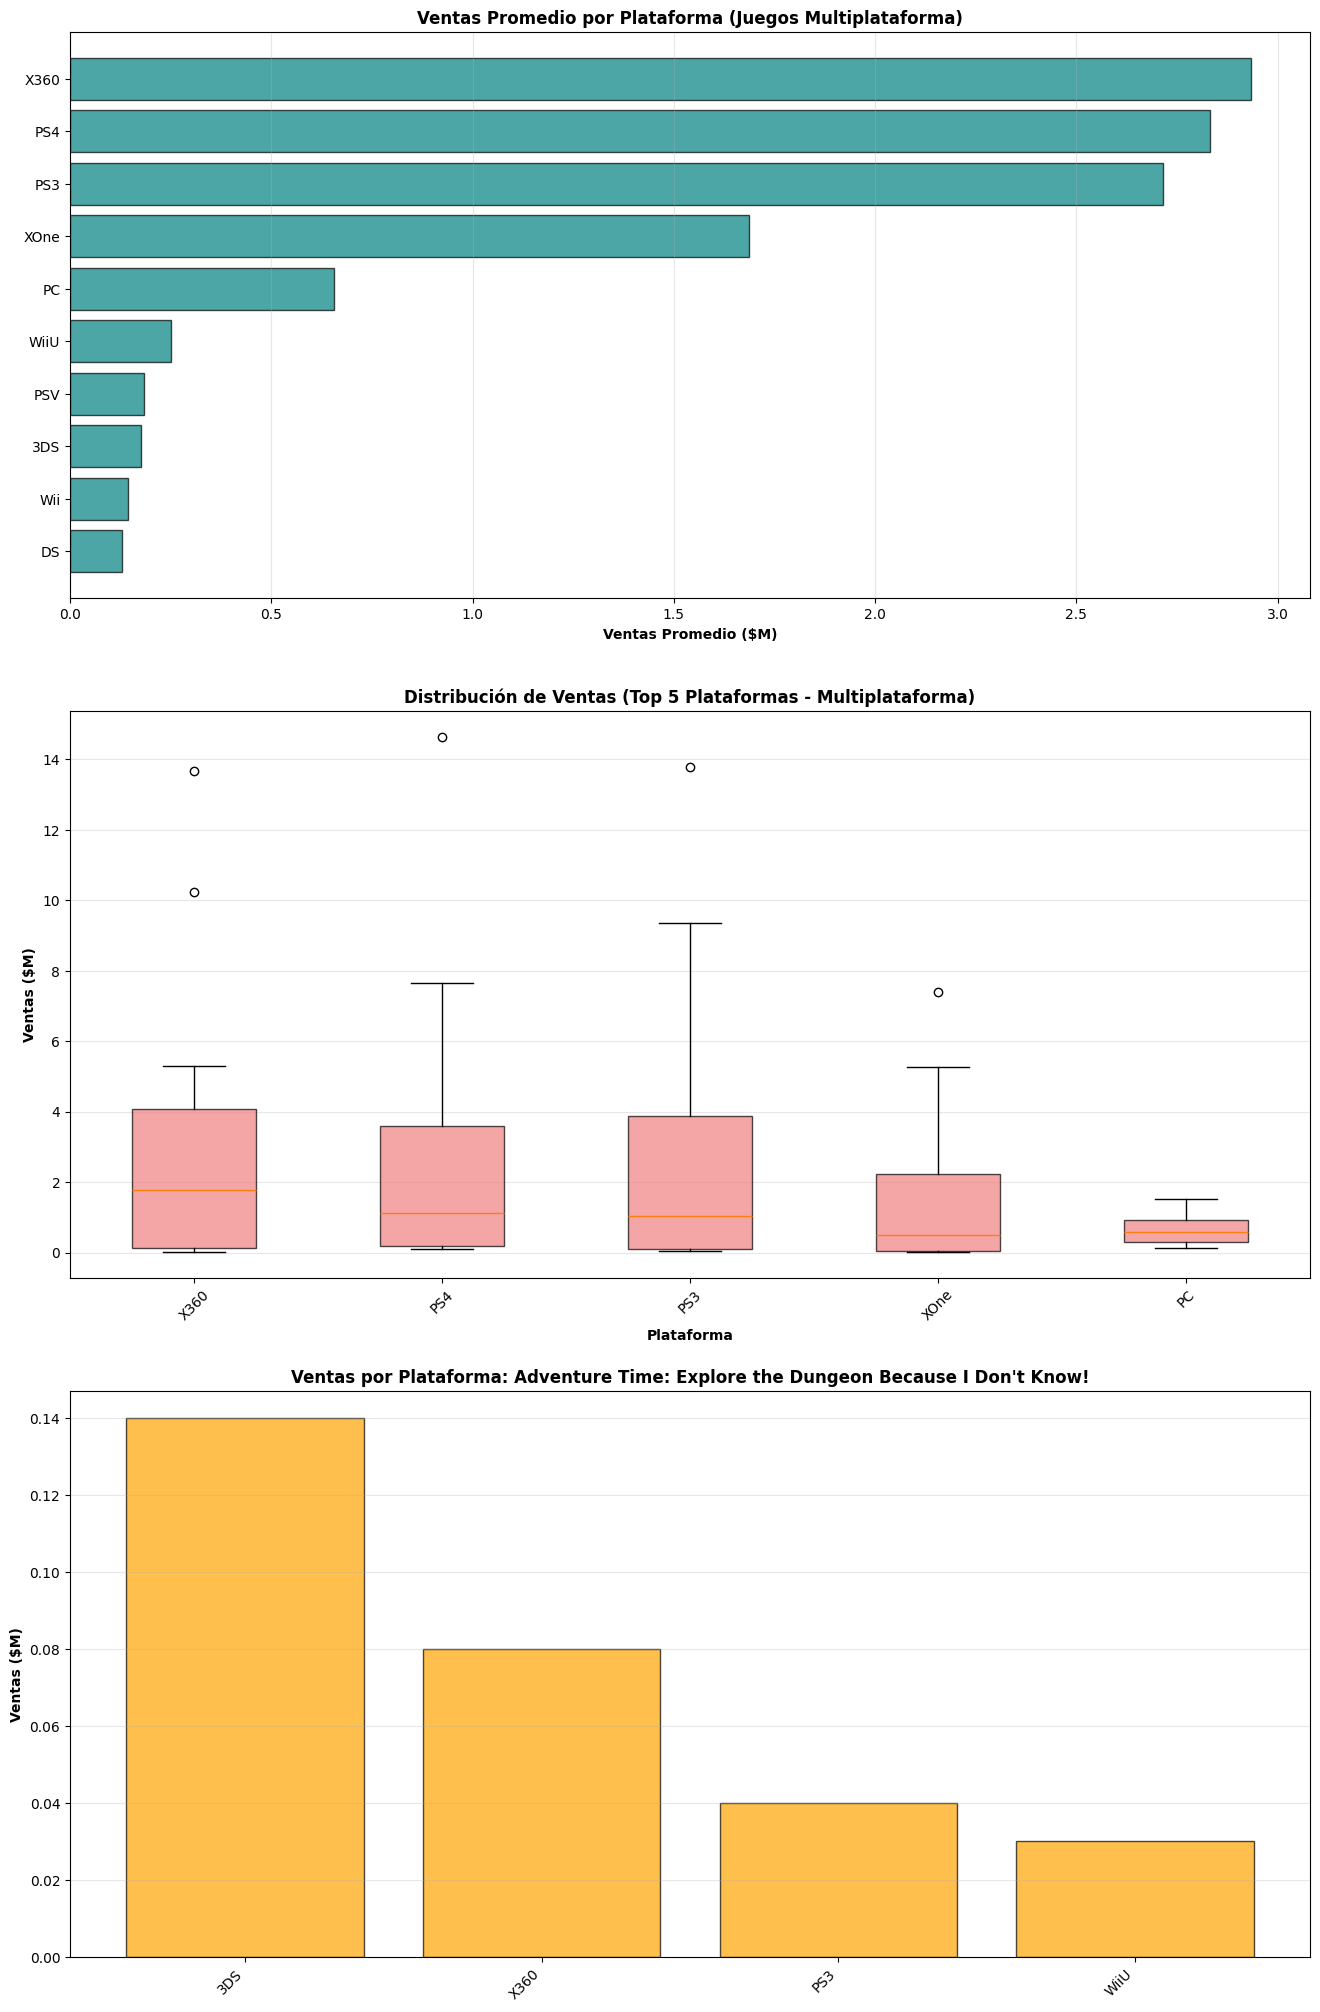

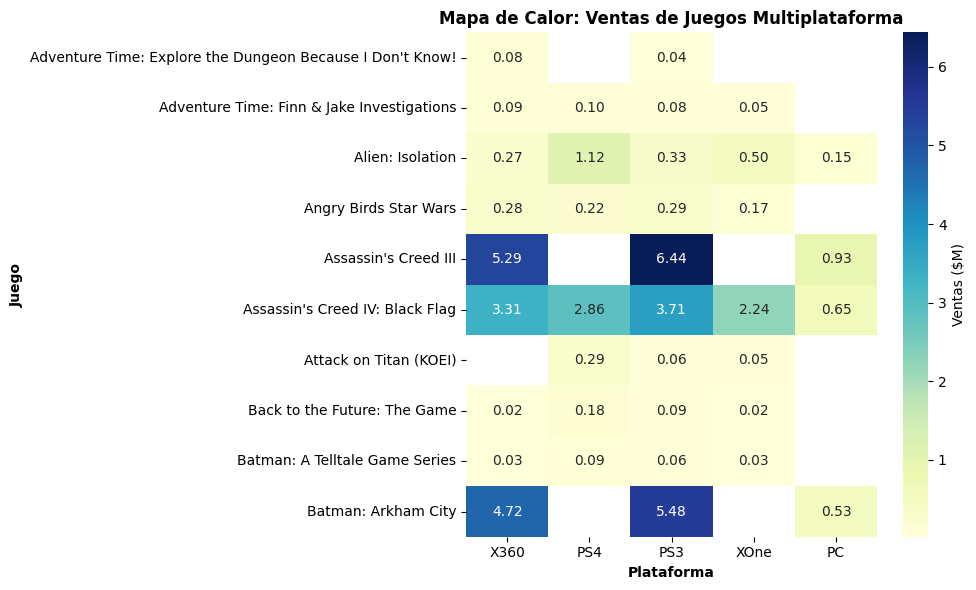

In [49]:
# Identificar juegos que están en múltiples plataformas
game_platform_count = df_relevant.groupby('name')['platform'].nunique()
# Esta línea selecciona los nombres de los juegos que aparecen en al menos 3 plataformas diferentes; 
# toma los primeros 20 en esa lista para analizarlos como ejemplos clave de juegos multiplataforma.
multiplatform_games = game_platform_count[game_platform_count >= 4].index.tolist()[:20]  

print(f"\nJuegos multiplataforma analizados: {len(multiplatform_games)}")
print("Ejemplos de juegos multiplataforma:")
for i, game in enumerate(multiplatform_games[:10], 1):
    platforms = df_relevant[df_relevant['name'] == game]['platform'].unique()
    print(f"  {i}. {game}: {len(platforms)} plataformas")

# Crear DataFrame para análisis de ventas por plataforma y por juego multiplataforma
multiplatform_sales = []
for game in multiplatform_games:
    game_data = df_relevant[df_relevant['name'] == game]
    for _, row in game_data.iterrows():
        multiplatform_sales.append({
            'Game': game,
            'Platform': row['platform'],
            'Sales': row['total_sales']
        })

df_multi = pd.DataFrame(multiplatform_sales)

# Ventas promedio, mediana y conteo por plataforma
platform_multi_avg = df_multi.groupby('Platform')['Sales'].agg(['mean', 'median', 'count']).sort_values('mean', ascending=False)
print("\nVentas promedio por plataforma (juegos multiplataforma):")
print(platform_multi_avg.head(15))

# Visualizaciones
fig, axes = plt.subplots(3, 1, figsize=(16, 25))

# 1. Barras horizontales con ventas promedio por plataforma (Top 10)
top_platforms_multi = platform_multi_avg.head(10)
axes[0].barh(range(len(top_platforms_multi)), top_platforms_multi['mean'],
             color='teal', edgecolor='black', alpha=0.7)
axes[0].set_yticks(range(len(top_platforms_multi)))
axes[0].set_yticklabels(top_platforms_multi.index)
axes[0].set_xlabel('Ventas Promedio ($M)', fontweight='bold')
axes[0].set_title('Ventas Promedio por Plataforma (Juegos Multiplataforma)', fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# 2. Boxplot comparando distribución de ventas (Top 5 plataformas)
top_5_platforms = platform_multi_avg.head(5).index.tolist()
box_data_multi = [df_multi[df_multi['Platform'] == p]['Sales'].values for p in top_5_platforms]
bp = axes[1].boxplot(box_data_multi, labels=top_5_platforms, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightcoral')
    patch.set_alpha(0.7)

axes[1].set_xlabel('Plataforma', fontweight='bold')
axes[1].set_ylabel('Ventas ($M)', fontweight='bold')
axes[1].set_title('Distribución de Ventas (Top 5 Plataformas - Multiplataforma)', fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=45)

# 3. Barras para un juego de ejemplo en sus diferentes plataformas
example_game = multiplatform_games[0]
game_sales = df_multi[df_multi['Game'] == example_game].sort_values('Sales', ascending=False)
axes[2].bar(range(len(game_sales)), game_sales['Sales'],
            color='orange', edgecolor='black', alpha=0.7)
axes[2].set_xticks(range(len(game_sales)))
axes[2].set_xticklabels(game_sales['Platform'], rotation=45, ha='right')
axes[2].set_ylabel('Ventas ($M)', fontweight='bold')
axes[2].set_title(f'Ventas por Plataforma: {example_game}', fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')

# 4. Mapa de calor (heatmap) de ventas: juegos vs plataformas (solo top 10 juegos y top 5 plataformas)
# Ponemos el heatmap en un subplot separado
fig_heatmap, ax_heatmap = plt.subplots(1, 1, figsize=(10, 6))
pivot_multi = df_multi.pivot_table(index='Game', columns='Platform', values='Sales', aggfunc='sum')
pivot_multi_top = pivot_multi.loc[multiplatform_games[:10], top_5_platforms]
sns.heatmap(pivot_multi_top, annot=True, fmt='.2f', cmap='YlGnBu',
            cbar_kws={'label': 'Ventas ($M)'}, ax=ax_heatmap)
ax_heatmap.set_xlabel('Plataforma', fontweight='bold')
ax_heatmap.set_ylabel('Juego', fontweight='bold')
ax_heatmap.set_title('Mapa de Calor: Ventas de Juegos Multiplataforma', fontweight='bold')

plt.tight_layout()

print(f"\n{'='*80}")
print("CONCLUSIONES - Comparación entre Plataformas:")
print("="*80)
best_platform = platform_multi_avg['mean'].idxmax()
worst_platform = platform_multi_avg['mean'].idxmin()
print(f"✓ Mejor plataforma (ventas promedio): {best_platform} (${platform_multi_avg.loc[best_platform, 'mean']:.3f}M)")
print(f"✓ Plataforma con menores ventas: {worst_platform} (${platform_multi_avg.loc[worst_platform, 'mean']:.3f}M)")
if platform_multi_avg.loc[worst_platform, 'mean'] != 0:
    diff_ratio = platform_multi_avg.loc[best_platform, 'mean'] / platform_multi_avg.loc[worst_platform, 'mean']
    print(f"✓ Diferencia: {diff_ratio:.1f}x")
else:
    print("✓ No es posible calcular la diferencia de ratio debido a ventas promedio cero en la peor plataforma.")

En el análisis anterior, se exploró la distribución de las ventas y la rentabilidad de los juegos multiplataforma, así como la comparación entre diferentes plataformas. 
Se generaron visualizaciones que incluyeron diagramas de caja para observar la dispersión de las ventas, barras por plataforma para un juego de ejemplo, y un mapa de calor que permite comparar rápidamente el rendimiento de los títulos seleccionados en las mejores plataformas.


Los resultados indicaron cuáles son las plataformas más rentables en promedio y las menos exitosas, mostrando una diferencia significativa en ventas promedio entre ellas. Además, gracias a las gráficas, fue posible identificar visualmente variaciones notables en la distribución de ventas de los juegos multiplataforma y observar como ciertos juegos se desempeñan mejor en determinadas plataformas.


De forma general, este análisis evidencia la importancia de escoger la plataforma adecuada para maximizar la rentabilidad de un juego, destacando qué plataformas lideran el mercado de multiplataforma y cuáles presentan oportunidades y retos.


## 2.9. Análisis de juegos por género

In [50]:
# Distribución de juegos por género
genre_counts = df_relevant['genre'].value_counts()
print(f"\nDistribución de juegos por género:")
print(genre_counts)

# Ventas por género
genre_sales = df_relevant.groupby('genre')['total_sales'].agg(['sum', 'mean', 'median', 'count']).sort_values('sum', ascending=False)
print(f"\nVentas por género:")
print(genre_sales)

# Calcular rentabilidad promedio
genre_sales['avg_per_game'] = genre_sales['sum'] / genre_sales['count']
genre_sales_sorted = genre_sales.sort_values('avg_per_game', ascending=False)

print(f"\n{'='*80}")
print("GÉNEROS MÁS RENTABLES (ventas promedio por juego):")
print("="*80)
print(genre_sales_sorted[['count', 'avg_per_game', 'sum']].head(10))

print(f"\n{'='*80}")
print("GÉNEROS MENOS RENTABLES:")
print("="*80)
print(genre_sales_sorted[['count', 'avg_per_game', 'sum']].tail(5))




Distribución de juegos por género:
genre
Action          1287
Role-Playing     465
Adventure        410
Sports           390
Misc             382
Shooter          332
Racing           181
Fighting         159
Simulation       136
Platform         122
Strategy         118
Puzzle            71
Name: count, dtype: int64

Ventas por género:
                 sum      mean  median  count
genre                                        
Action        565.22  0.439176   0.130   1287
Shooter       402.96  1.213735   0.410    332
Role-Playing  245.63  0.528237   0.150    465
Sports        238.11  0.610538   0.200    390
Misc          139.91  0.366257   0.120    382
Platform       88.68  0.726885   0.185    122
Racing         88.36  0.488177   0.160    181
Fighting       66.90  0.420755   0.180    159
Simulation     50.26  0.369559   0.110    136
Adventure      45.04  0.109854   0.030    410
Strategy       22.51  0.190763   0.080    118
Puzzle          9.85  0.138732   0.050     71

GÉNEROS MÁS REN

/var/folders/vl/nhdmlk3n4hbd3jy0qdqgg7ch0000gn/T/ipykernel_46368/71429245.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot(box_data_genre, labels=top_genres_box, patch_artist=True)


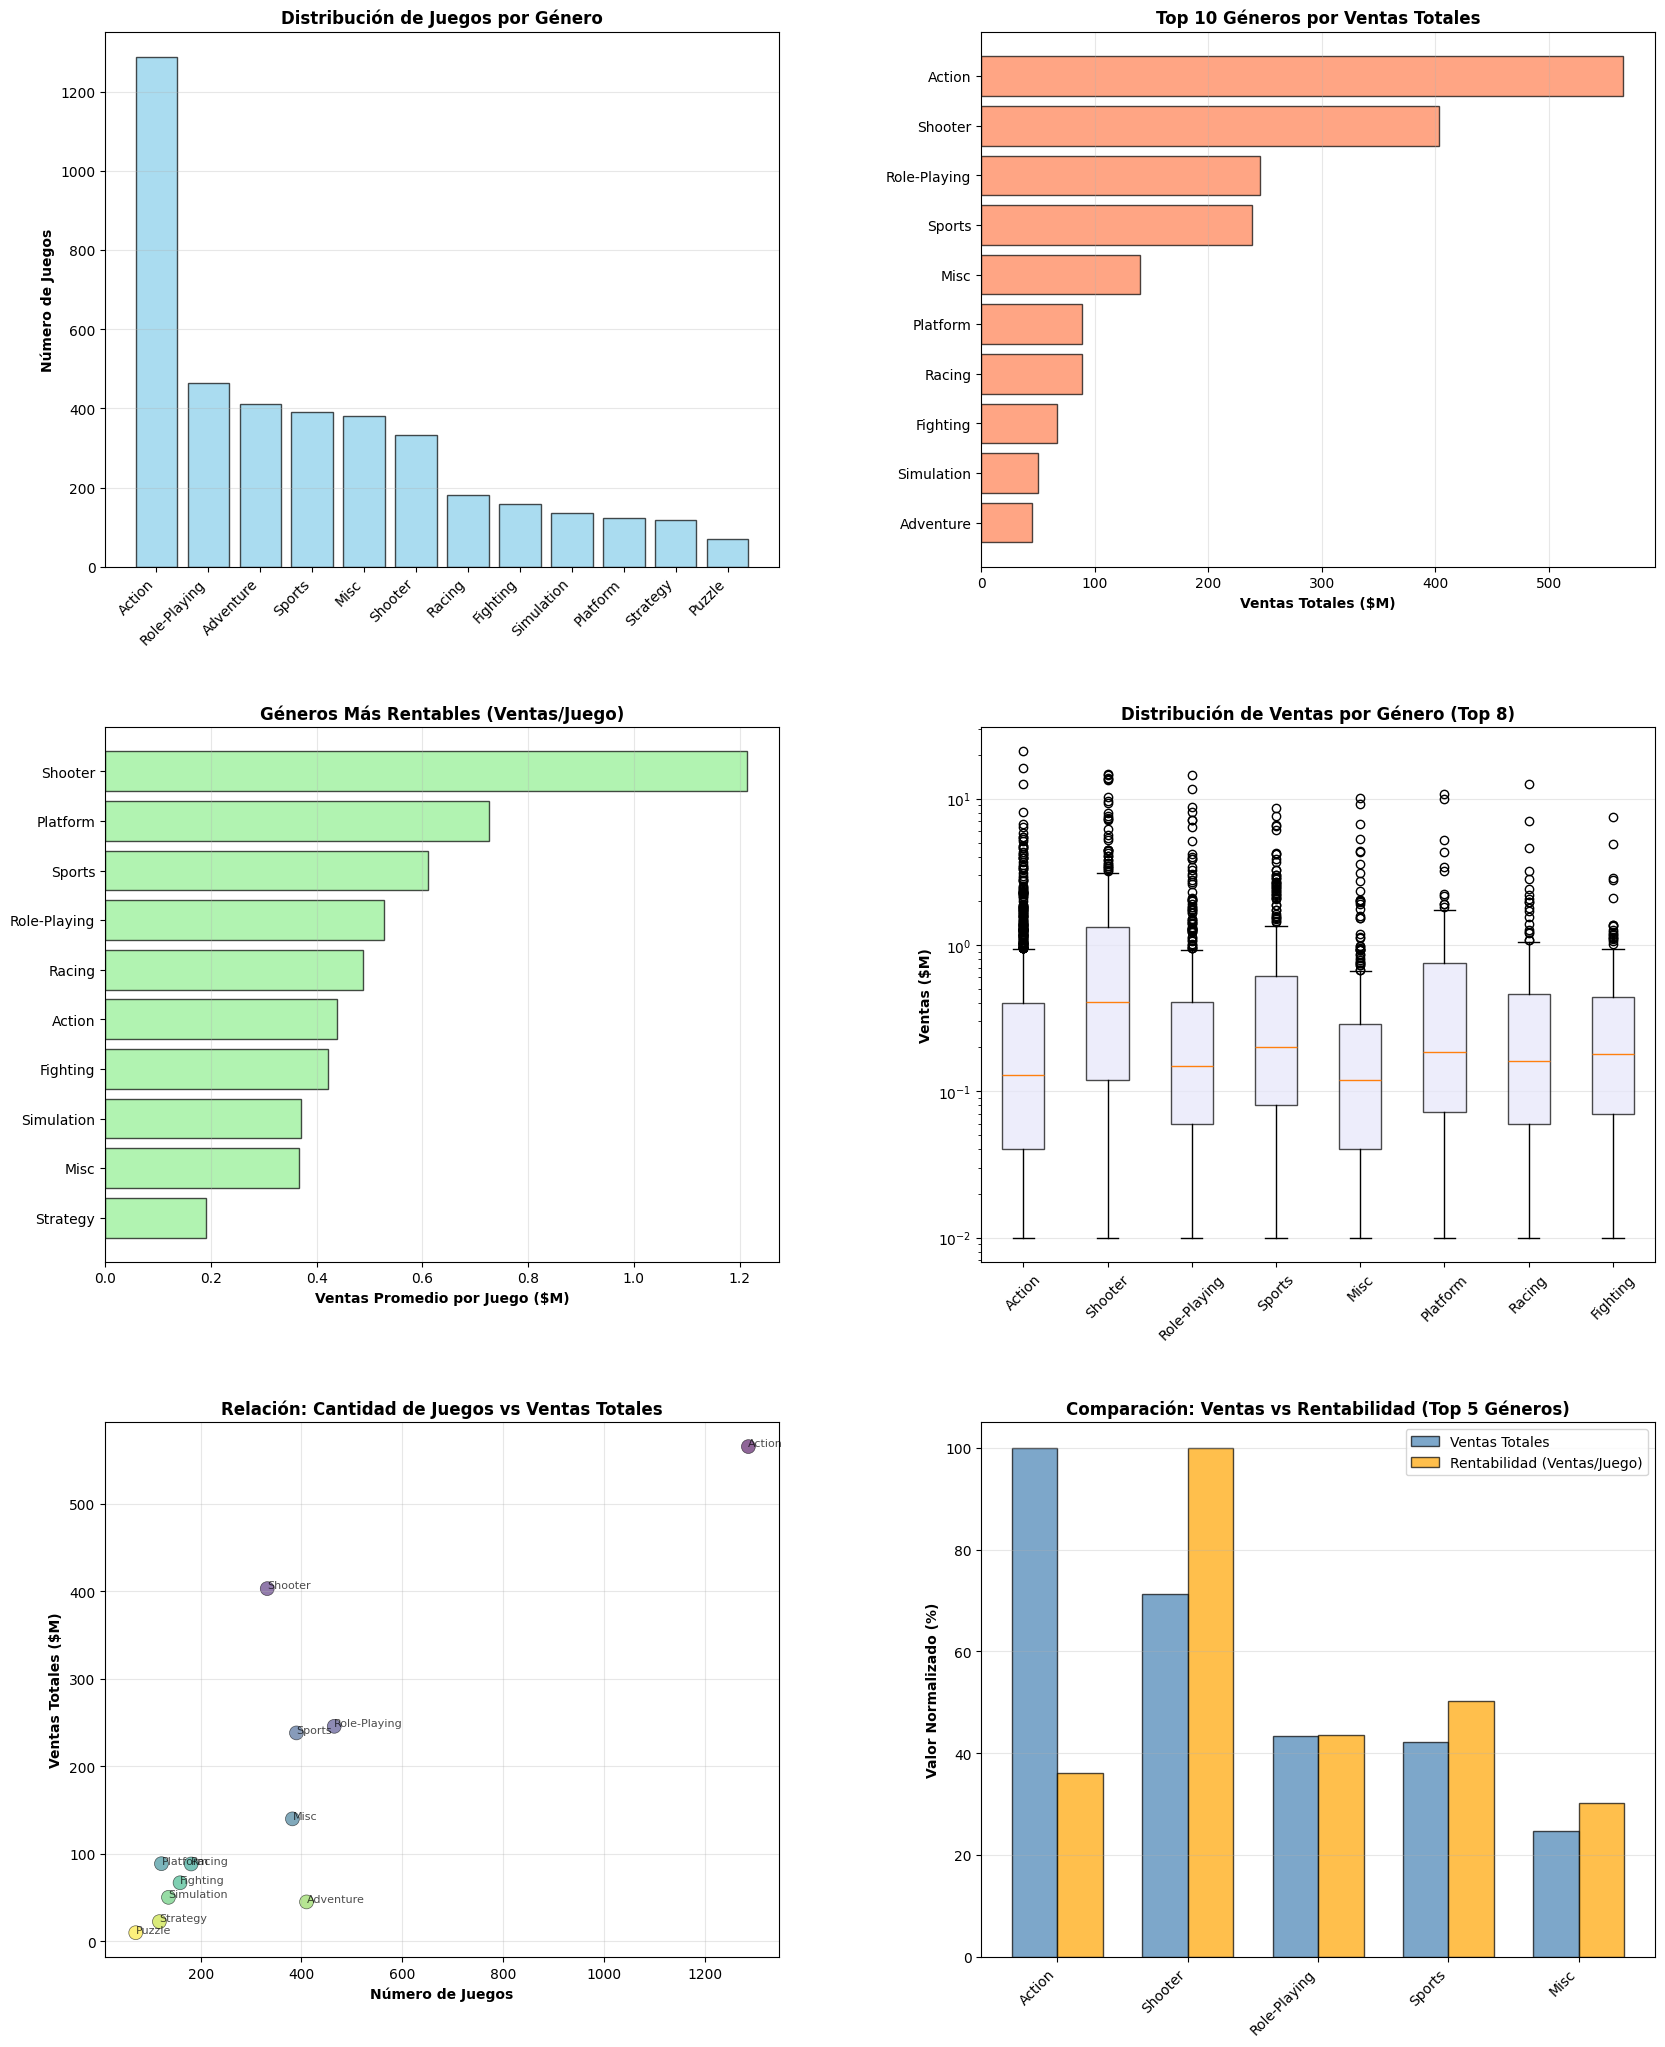

In [51]:
# Visualización completa
fig = plt.figure(figsize=(20, 25))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Distribución de juegos por género
ax1 = fig.add_subplot(gs[0, 0])
genre_counts_sorted = genre_counts.sort_values(ascending=False)
ax1.bar(range(len(genre_counts_sorted)), genre_counts_sorted.values, 
       color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_xticks(range(len(genre_counts_sorted)))
ax1.set_xticklabels(genre_counts_sorted.index, rotation=45, ha='right')
ax1.set_ylabel('Número de Juegos', fontweight='bold')
ax1.set_title('Distribución de Juegos por Género', fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# 2. Ventas totales por género
ax2 = fig.add_subplot(gs[0, 1])
genre_sales_top = genre_sales.sort_values('sum', ascending=False).head(10)
ax2.barh(range(len(genre_sales_top)), genre_sales_top['sum'], 
        color='coral', edgecolor='black', alpha=0.7)
ax2.set_yticks(range(len(genre_sales_top)))
ax2.set_yticklabels(genre_sales_top.index)
ax2.set_xlabel('Ventas Totales ($M)', fontweight='bold')
ax2.set_title('Top 10 Géneros por Ventas Totales', fontweight='bold')
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3, axis='x')

# 3. Ventas promedio por juego (rentabilidad)
ax3 = fig.add_subplot(gs[1, 0])
ax3.barh(range(len(genre_sales_sorted.head(10))), genre_sales_sorted['avg_per_game'].head(10), 
        color='lightgreen', edgecolor='black', alpha=0.7)
ax3.set_yticks(range(len(genre_sales_sorted.head(10))))
ax3.set_yticklabels(genre_sales_sorted.head(10).index)
ax3.set_xlabel('Ventas Promedio por Juego ($M)', fontweight='bold')
ax3.set_title('Géneros Más Rentables (Ventas/Juego)', fontweight='bold')
ax3.invert_yaxis()
ax3.grid(True, alpha=0.3, axis='x')

# 4. Box plot de ventas por género
ax4 = fig.add_subplot(gs[1, 1])
top_genres_box = genre_sales.sort_values('sum', ascending=False).head(8).index.tolist()
box_data_genre = [df_relevant[df_relevant['genre'] == g]['total_sales'].values for g in top_genres_box]
bp = ax4.boxplot(box_data_genre, labels=top_genres_box, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lavender')
    patch.set_alpha(0.7)
ax4.set_ylabel('Ventas ($M)', fontweight='bold')
ax4.set_title('Distribución de Ventas por Género (Top 8)', fontweight='bold')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3, axis='y')
ax4.set_yscale('log')

# 5. Scatter: Número de juegos vs Ventas totales
ax5 = fig.add_subplot(gs[2, 0])
ax5.scatter(genre_sales['count'], genre_sales['sum'], s=100, alpha=0.6, 
           c=range(len(genre_sales)), cmap='viridis', edgecolor='black', linewidth=0.5)
for idx, genre in enumerate(genre_sales.index):
    ax5.annotate(genre, (genre_sales.loc[genre, 'count'], genre_sales.loc[genre, 'sum']),
                fontsize=8, alpha=0.7)
ax5.set_xlabel('Número de Juegos', fontweight='bold')
ax5.set_ylabel('Ventas Totales ($M)', fontweight='bold')
ax5.set_title('Relación: Cantidad de Juegos vs Ventas Totales', fontweight='bold')
ax5.grid(True, alpha=0.3)

# 6. Comparación de métricas clave
ax6 = fig.add_subplot(gs[2, 1])
top_5_genres = genre_sales.sort_values('sum', ascending=False).head(5).index
x = np.arange(len(top_5_genres))
width = 0.35

# Normalizar para comparar
sales_normalized = genre_sales.loc[top_5_genres, 'sum'] / genre_sales['sum'].max() * 100
avg_normalized = genre_sales.loc[top_5_genres, 'avg_per_game'] / genre_sales['avg_per_game'].max() * 100

bars1 = ax6.bar(x - width/2, sales_normalized, width, label='Ventas Totales', 
               color='steelblue', alpha=0.7, edgecolor='black')
bars2 = ax6.bar(x + width/2, avg_normalized, width, label='Rentabilidad (Ventas/Juego)',
               color='orange', alpha=0.7, edgecolor='black')

ax6.set_ylabel('Valor Normalizado (%)', fontweight='bold')
ax6.set_title('Comparación: Ventas vs Rentabilidad (Top 5 Géneros)', fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(top_5_genres, rotation=45, ha='right')
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

In [52]:
# Conclusiones finales
print(f"\n{'='*80}")
print("CONCLUSIONES GENERALES - ANÁLISIS POR GÉNERO:")
print("="*80)

most_profitable = genre_sales_sorted.index[0]
most_popular = genre_counts.index[0]
highest_total = genre_sales.sort_values('sum', ascending=False).index[0]

print(f"\n1. GÉNERO MÁS RENTABLE (ventas/juego): {most_profitable}")
print(f"   - Ventas promedio: ${genre_sales_sorted.loc[most_profitable, 'avg_per_game']:.3f}M por juego")
print(f"   - Total juegos: {genre_sales_sorted.loc[most_profitable, 'count']:.0f}")

print(f"\n2. GÉNERO MÁS POPULAR (cantidad): {most_popular}")
print(f"   - Número de juegos: {genre_counts[most_popular]}")
print(f"   - Ventas promedio: ${genre_sales.loc[most_popular, 'mean']:.3f}M")

print(f"\n3. GÉNERO CON MAYORES VENTAS TOTALES: {highest_total}")
print(f"   - Ventas totales: ${genre_sales.loc[highest_total, 'sum']:.2f}M")
print(f"   - Número de juegos: {genre_sales.loc[highest_total, 'count']:.0f}")

# Clasificación de géneros
high_sales_threshold = genre_sales_sorted['avg_per_game'].quantile(0.75)
low_sales_threshold = genre_sales_sorted['avg_per_game'].quantile(0.25)

high_sales_genres = genre_sales_sorted[genre_sales_sorted['avg_per_game'] >= high_sales_threshold].index.tolist()
low_sales_genres = genre_sales_sorted[genre_sales_sorted['avg_per_game'] <= low_sales_threshold].index.tolist()

print(f"\n4. GÉNEROS DE ALTAS VENTAS (top 25%):")
print(f"   {', '.join(high_sales_genres)}")

print(f"\n5. GÉNEROS DE BAJAS VENTAS (bottom 25%):")
print(f"   {', '.join(low_sales_genres)}")


CONCLUSIONES GENERALES - ANÁLISIS POR GÉNERO:

1. GÉNERO MÁS RENTABLE (ventas/juego): Shooter
   - Ventas promedio: $1.214M por juego
   - Total juegos: 332

2. GÉNERO MÁS POPULAR (cantidad): Action
   - Número de juegos: 1287
   - Ventas promedio: $0.439M

3. GÉNERO CON MAYORES VENTAS TOTALES: Action
   - Ventas totales: $565.22M
   - Número de juegos: 1287

4. GÉNEROS DE ALTAS VENTAS (top 25%):
   Shooter, Platform, Sports

5. GÉNEROS DE BAJAS VENTAS (bottom 25%):
   Strategy, Puzzle, Adventure


In [53]:
print(f"\n6. GENERALIZACIÓN:")
if 'Action' in high_sales_genres or 'Shooter' in high_sales_genres:
    print(f"   ✓ Géneros de acción/intensos tienden a tener ventas altas")
if 'Sports' in high_sales_genres or 'Racing' in high_sales_genres:
    print(f"   ✓ Deportes y carreras son consistentemente rentables")
if 'Strategy' in low_sales_genres or 'Puzzle' in low_sales_genres:
    print(f"   ✓ Géneros de nicho (estrategia, puzzle) tienen ventas más bajas pero audiencia fiel")

print(f"\n{'='*80}")
print("REPORTE COMPLETO")
print("="*80)
print(f"✓ Análisis completado para el período {recommended_start}-2016")
print(f"✓ {len(df_relevant)} registros analizados")
print(f"✓ {df_relevant['platform'].nunique()} plataformas únicas")
print(f"✓ {df_relevant['genre'].nunique()} géneros únicos")
print("="*80)


6. GENERALIZACIÓN:
   ✓ Géneros de acción/intensos tienden a tener ventas altas
   ✓ Deportes y carreras son consistentemente rentables
   ✓ Géneros de nicho (estrategia, puzzle) tienen ventas más bajas pero audiencia fiel

REPORTE COMPLETO
✓ Análisis completado para el período 2011-2016
✓ 4053 registros analizados
✓ 12 plataformas únicas
✓ 12 géneros únicos


# 3. Análisis regional

## 3.1. Variación regional de TOP 5 Plataformas

En los siguientes bloques se analizarán las diferencias regionales en las plataformas de videojuegos más populares. Se calcularán y visualizarán las ventas por plataforma en las regiones de Norteamérica (NA), Europa (EU) y Japón (JP), mostrando los Top 5 de cada región y examinando sus cuotas de mercado. Este análisis es fundamental para entender cómo las preferencias de los consumidores varían según el mercado, lo cual puede ayudar a orientar estrategias comerciales, identificar oportunidades y comprender el éxito de diferentes plataformas a nivel mundial y regional

In [81]:
region_cols = {
    'NA': 'na_sales',
    'EU': 'eu_sales',
    'JP': 'jp_sales'
}

# Calcular ventas totales por plataforma y región
platform_by_region = {}
for region, sales_col in region_cols.items():
    platform_sales = df_relevant.groupby('platform')[sales_col].sum().sort_values(ascending=False)
    platform_by_region[region] = platform_sales
    
    print(f"\n{region} - Top 5 Plataformas:")
    for i, (platform, sales) in enumerate(platform_sales.head(5).items(), 1):
        print(f"  {i}. {platform}: ${sales:.2f}M")


NA - Top 5 Plataformas:
  1. X360: $228.18M
  2. PS3: $168.96M
  3. PS4: $108.74M
  4. XOne: $93.12M
  5. 3DS: $82.83M

EU - Top 5 Plataformas:
  1. PS3: $164.14M
  2. PS4: $141.09M
  3. X360: $117.91M
  4. 3DS: $61.46M
  5. PC: $57.38M

JP - Top 5 Plataformas:
  1. 3DS: $100.62M
  2. PS3: $49.40M
  3. PSP: $24.28M
  4. PSV: $21.84M
  5. PS4: $15.96M


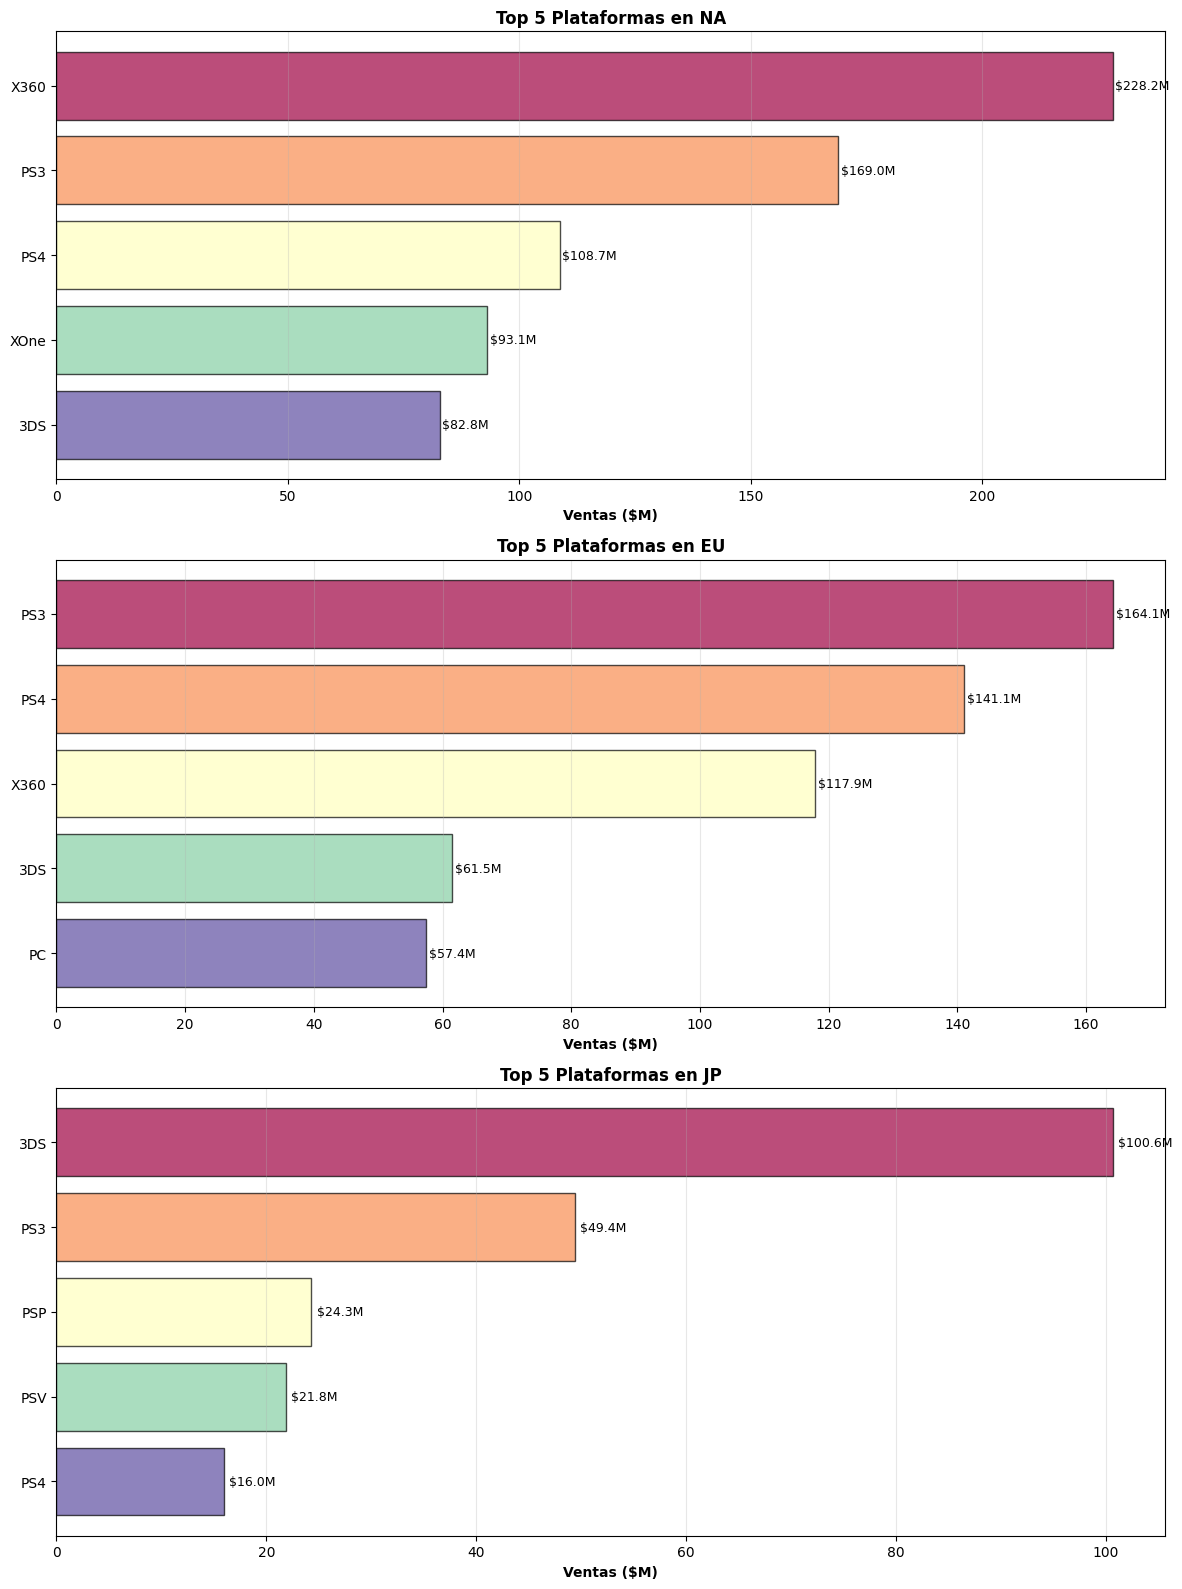

In [79]:
# Visualización de Top 5 plataformas para NA, EU y JP en gráficos de barras horizontales (uno debajo del otro)
fig, axes = plt.subplots(3, 1, figsize=(12, 16))  # 3 filas, 1 columna

for idx, region in enumerate(['NA', 'EU', 'JP']):
    ax = axes[idx]
    top5 = platform_by_region[region].head(5)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(top5)))
    ax.barh(range(len(top5)), top5.values, color=colors, edgecolor='black', alpha=0.7)
    ax.set_yticks(range(len(top5)))
    ax.set_yticklabels(top5.index)
    ax.set_xlabel('Ventas ($M)', fontweight='bold')
    ax.set_title(f'Top 5 Plataformas en {region}', fontweight='bold', fontsize=12)
    ax.invert_yaxis()
    ax.grid(True, alpha=0.3, axis='x')
    
    # Agregar valores
    for i, v in enumerate(top5.values):
        ax.text(v + 0.5, i, f'${v:.1f}M', va='center', fontsize=9)

plt.tight_layout()
plt.show()

Se calcularon las ventas totales por plataforma para cada región (Norteamérica, Europa y Japón), identificando las 5 plataformas más exitosas en términos de ventas en cada una. Se observa que cada mercado tiene preferencias distintas: en NA y EU suelen dominar plataformas asociadas a grandes publishers occidentales, mientras que en JP destacan consolas japonesas como PlayStation o Nintendo. Las cifras presentadas permiten comparar el liderazgo regional y muestran las ventajas competitivas de determinadas marcas en cada parte del mundo.

In [ ]:
# Calcular cuotas de mercado
market_share = {}
for region, sales_col in region_cols.items():
    total_sales = df_relevant[sales_col].sum()
    platform_sales = df_relevant.groupby('platform')[sales_col].sum().sort_values(ascending=False)
    shares = (platform_sales / total_sales * 100).head(5)
    market_share[region] = shares
    
    print(f"\n{region} (Total: ${total_sales:.2f}M):")
    for platform, share in shares.items():
        sales = platform_sales[platform]
        print(f"  {platform}: {share:.1f}% (${sales:.2f}M)")


NA (Total: $834.27M):
  X360: 27.4% ($228.18M)
  PS3: 20.3% ($168.96M)
  PS4: 13.0% ($108.74M)
  XOne: 11.2% ($93.12M)
  3DS: 9.9% ($82.83M)

EU (Total: $673.31M):
  PS3: 24.4% ($164.14M)
  PS4: 21.0% ($141.09M)
  X360: 17.5% ($117.91M)
  3DS: 9.1% ($61.46M)
  PC: 8.5% ($57.38M)

JP (Total: $245.91M):
  3DS: 40.9% ($100.62M)
  PS3: 20.1% ($49.40M)
  PSP: 9.9% ($24.28M)
  PSV: 8.9% ($21.84M)
  PS4: 6.5% ($15.96M)


In [61]:
# Crear DataFrame comparativo de cuotas de mercado
all_platforms = set()
for shares in market_share.values():
    all_platforms.update(shares.index)

market_share_df = pd.DataFrame(index=sorted(all_platforms))
for region, shares in market_share.items():
    market_share_df[region] = shares

market_share_df = market_share_df.fillna(0).sort_values('NA', ascending=False)

Text(0.5, 1.0, 'Mapa de Calor: Cuotas de Mercado por Región')

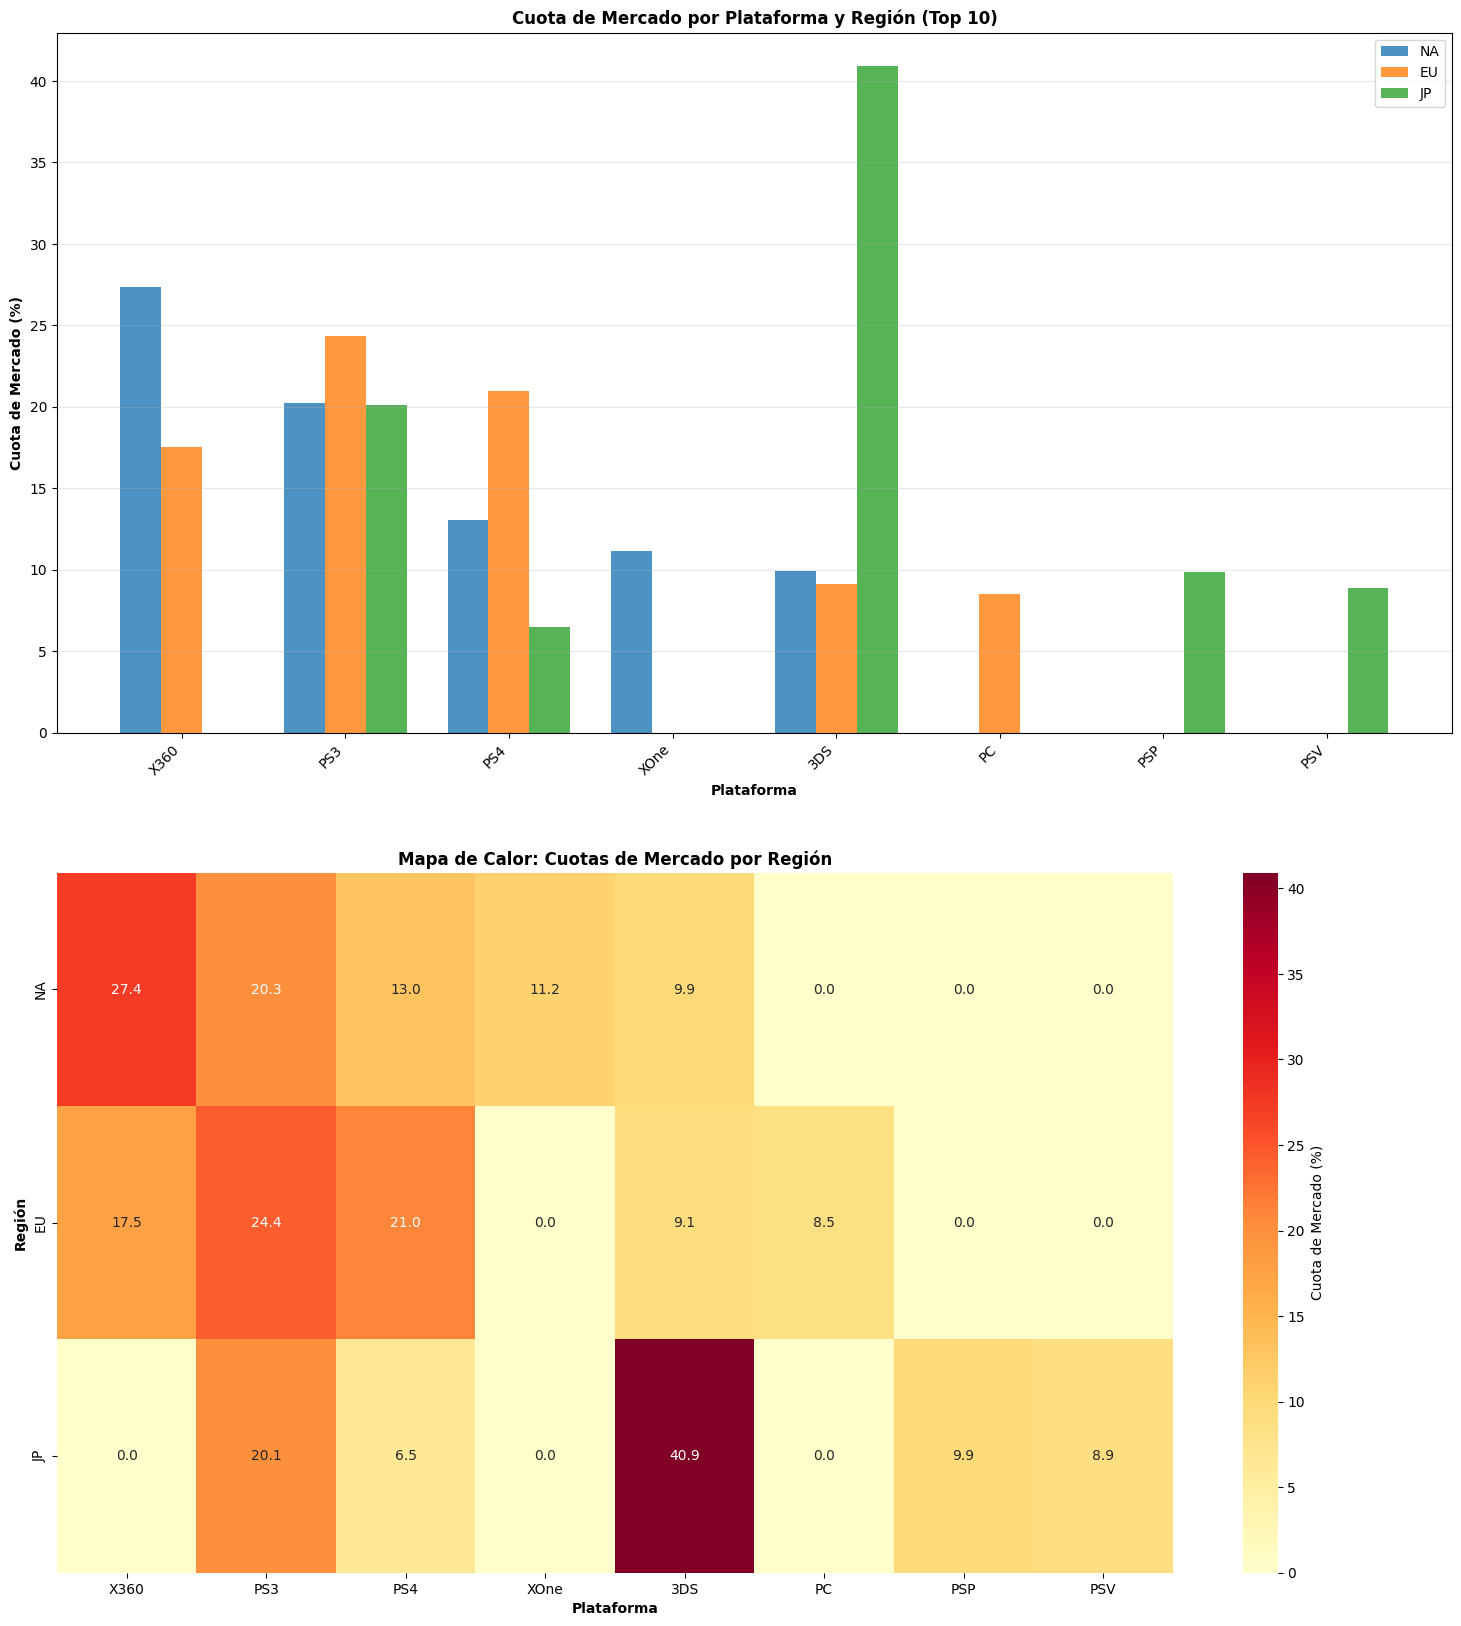

In [72]:
# Visualización 1: Plataformas por región
fig, axes = plt.subplots(2, figsize=(18, 20))

# Gráfico 1: Barras apiladas de top 10 plataformas
top_platforms = market_share_df.head(10)
x = np.arange(len(top_platforms))
width = 0.25

axes[0].bar(x - width, top_platforms['NA'], width, label='NA', color='#1f77b4', alpha=0.8)
axes[0].bar(x, top_platforms['EU'], width, label='EU', color='#ff7f0e', alpha=0.8)
axes[0].bar(x + width, top_platforms['JP'], width, label='JP', color='#2ca02c', alpha=0.8)
axes[0].set_xlabel('Plataforma', fontweight='bold')
axes[0].set_ylabel('Cuota de Mercado (%)', fontweight='bold')
axes[0].set_title('Cuota de Mercado por Plataforma y Región (Top 10)', fontweight='bold', fontsize=12)
axes[0].set_xticks(x)
axes[0].set_xticklabels(top_platforms.index, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Gráfico 2: Heatmap de cuotas
sns.heatmap(market_share_df.head(10).T, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Cuota de Mercado (%)'}, ax=axes[1])
axes[1].set_xlabel('Plataforma', fontweight='bold')
axes[1].set_ylabel('Región', fontweight='bold')
axes[1].set_title('Mapa de Calor: Cuotas de Mercado por Región', fontweight='bold', fontsize=12)

In [64]:
print("\n" + "-"*80)
print("COMPARACIÓN DIRECTA DE CUOTAS DE MERCADO (%)")
print("-"*80)
print(market_share_df.head(10).to_string())


--------------------------------------------------------------------------------
COMPARACIÓN DIRECTA DE CUOTAS DE MERCADO (%)
--------------------------------------------------------------------------------
             NA         EU         JP
X360  27.350858  17.511993   0.000000
PS3   20.252436  24.378073  20.088650
PS4   13.034150  20.954687   6.490179
XOne  11.161854   0.000000   0.000000
3DS    9.928440   9.128039  40.917409
PC     0.000000   8.522077   0.000000
PSP    0.000000   0.000000   9.873531
PSV    0.000000   0.000000   8.881298


Se calcularon y visualizaron las cuotas de mercado (%) de las principales plataformas de videojuegos para las regiones de Norteamérica (NA), Europa (EU) y Japón (JP). 

Los gráficos muestran que las plataformas líderes varían considerablemente según la región.

Por ejemplo, en NA y EU, consolas como Xbox 360 y PlayStation 3 ocupan los primeros lugares, concentrando juntos más del 50% del mercado en ambas regiones. Sin embargo, en JP, Nintendo DS y PlayStation Portable dominan claramente, acumulando cada una más del 20% de participación.
 
El heatmap facilita la comparación visual, destacando cómo algunas plataformas tienen una presencia mucho mayor en ciertos mercados (por ejemplo, Xbox 360 en NA versus su baja presencia en JP).
 
Estos resultados evidencian diferencias estructurales en las preferencias de los consumidores y la importancia estratégica de ciertas plataformas en cada mercado regional.


In [65]:
# Análisis de variaciones
print("\n" + "-"*80)
print("ANÁLISIS DE VARIACIONES REGIONALES")
print("-"*80)
# Top 5 plataformas globales del período
global_top5 = df_relevant.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(5).index.tolist()

for platform in global_top5:
    print(f"\n{platform}:")
    na_share = market_share_df.loc[platform, 'NA'] if platform in market_share_df.index else 0
    eu_share = market_share_df.loc[platform, 'EU'] if platform in market_share_df.index else 0
    jp_share = market_share_df.loc[platform, 'JP'] if platform in market_share_df.index else 0
    
    print(f"  NA: {na_share:.1f}% | EU: {eu_share:.1f}% | JP: {jp_share:.1f}%")
    
    # Identificar región dominante
    shares = {'NA': na_share, 'EU': eu_share, 'JP': jp_share}
    max_region = max(shares, key=shares.get)
    min_region = min(shares, key=shares.get)
    
    if shares[max_region] > 0:
        ratio = shares[max_region] / shares[min_region] if shares[min_region] > 0 else float('inf')
        print(f"  → Más fuerte en {max_region}, ratio vs {min_region}: {ratio:.1f}x")



--------------------------------------------------------------------------------
ANÁLISIS DE VARIACIONES REGIONALES
--------------------------------------------------------------------------------

PS3:
  NA: 20.3% | EU: 24.4% | JP: 20.1%
  → Más fuerte en EU, ratio vs JP: 1.2x

X360:
  NA: 27.4% | EU: 17.5% | JP: 0.0%
  → Más fuerte en NA, ratio vs JP: infx

PS4:
  NA: 13.0% | EU: 21.0% | JP: 6.5%
  → Más fuerte en EU, ratio vs JP: 3.2x

3DS:
  NA: 9.9% | EU: 9.1% | JP: 40.9%
  → Más fuerte en JP, ratio vs EU: 4.5x

XOne:
  NA: 11.2% | EU: 0.0% | JP: 0.0%
  → Más fuerte en NA, ratio vs EU: infx


## 3.2. Variación regional de TOP 5 Géneros


In [85]:
# Calcular ventas por género y región
genre_by_region = {}
for region, sales_col in region_cols.items():
    genre_sales = df_relevant.groupby('genre')[sales_col].sum().sort_values(ascending=False)
    genre_by_region[region] = genre_sales
    
    print(f"\n{region} - Top 5 Géneros:")
    for i, (genre, sales) in enumerate(genre_sales.head(5).items(), 1):
        print(f"  {i}. {genre}: ${sales:.2f}M")


NA - Top 5 Géneros:
  1. Action: $234.41M
  2. Shooter: $194.45M
  3. Sports: $109.38M
  4. Role-Playing: $83.78M
  5. Misc: $69.81M

EU - Top 5 Géneros:
  1. Action: $202.17M
  2. Shooter: $148.05M
  3. Sports: $88.66M
  4. Role-Playing: $62.30M
  5. Racing: $40.62M

JP - Top 5 Géneros:
  1. Role-Playing: $79.87M
  2. Action: $63.63M
  3. Misc: $17.85M
  4. Fighting: $12.38M
  5. Platform: $12.13M


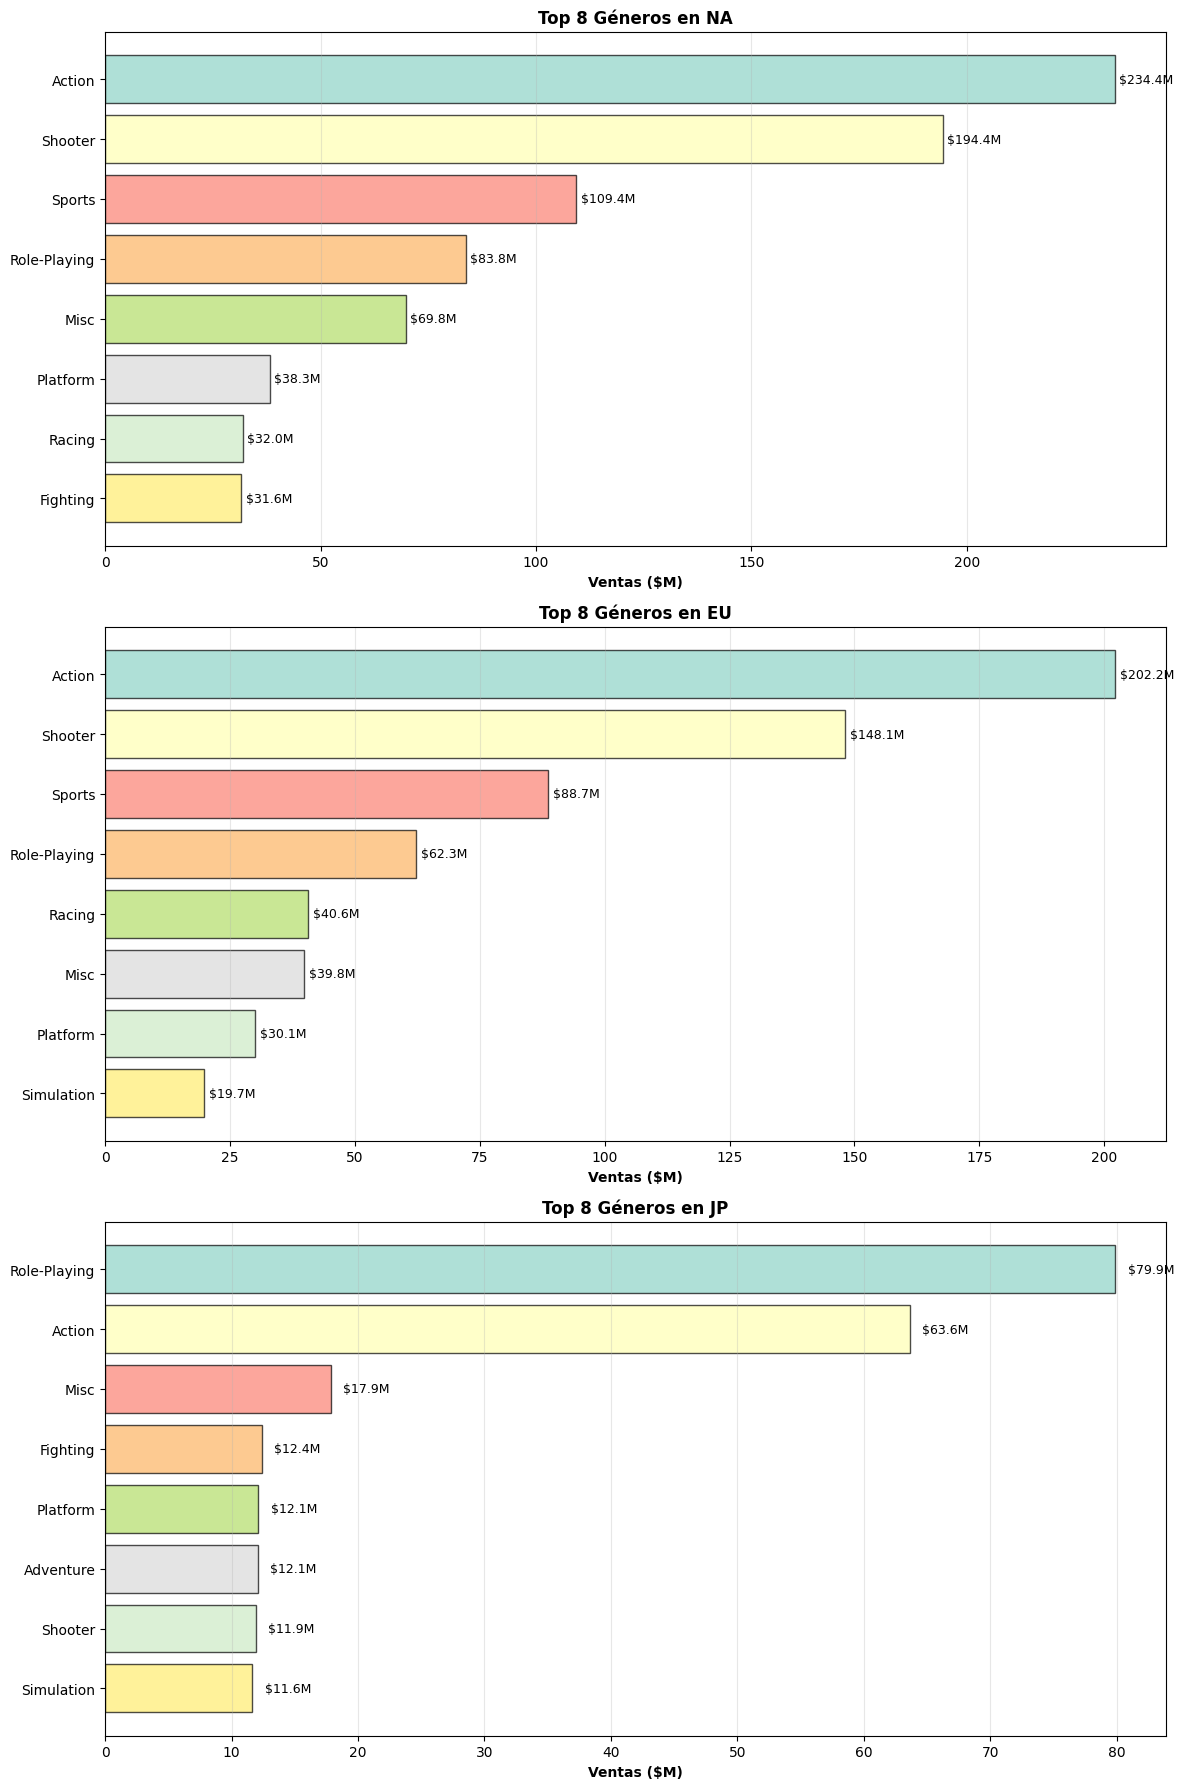

In [ ]:
# Gráfico 1: Ventas absolutas por región
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

for idx, region in enumerate(['NA', 'EU', 'JP']):
    ax = axes[idx]
    top_genres = genre_by_region[region].head(8)
    colors = plt.cm.Set3(np.linspace(0, 1, len(top_genres)))
    ax.barh(range(len(top_genres)), top_genres.values, color=colors, edgecolor='black', alpha=0.7)
    ax.set_yticks(range(len(top_genres)))
    ax.set_yticklabels(top_genres.index)
    ax.set_xlabel('Ventas ($M)', fontweight='bold')
    ax.set_title(f'Top 8 Géneros en {region}', fontweight='bold', fontsize=12)
    ax.invert_yaxis()
    ax.grid(True, alpha=0.3, axis='x')

    # Agregar valores
    for i, v in enumerate(top_genres.values):
        ax.text(v + 1, i, f'${v:.1f}M', va='center', fontsize=9)

plt.tight_layout()

In [86]:
# Calcular cuotas de mercado por género
genre_market_share = {}
for region, sales_col in region_cols.items():
    total_sales = df_relevant[sales_col].sum()
    genre_sales = df_relevant.groupby('genre')[sales_col].sum().sort_values(ascending=False)
    shares = (genre_sales / total_sales * 100).head(5)
    genre_market_share[region] = shares
    
    print(f"\n{region}:")
    for genre, share in shares.items():
        sales = genre_sales[genre]
        print(f"  {genre}: {share:.1f}% (${sales:.2f}M)")


NA:
  Action: 28.1% ($234.41M)
  Shooter: 23.3% ($194.45M)
  Sports: 13.1% ($109.38M)
  Role-Playing: 10.0% ($83.78M)
  Misc: 8.4% ($69.81M)

EU:
  Action: 30.0% ($202.17M)
  Shooter: 22.0% ($148.05M)
  Sports: 13.2% ($88.66M)
  Role-Playing: 9.3% ($62.30M)
  Racing: 6.0% ($40.62M)

JP:
  Role-Playing: 32.5% ($79.87M)
  Action: 25.9% ($63.63M)
  Misc: 7.3% ($17.85M)
  Fighting: 5.0% ($12.38M)
  Platform: 4.9% ($12.13M)


In [87]:
# Crear DataFrame comparativo de géneros
all_genres = set()
for shares in genre_market_share.values():
    all_genres.update(shares.index)

genre_share_df = pd.DataFrame(index=sorted(all_genres))
for region, shares in genre_market_share.items():
    genre_share_df[region] = shares

genre_share_df = genre_share_df.fillna(0).sort_values('NA', ascending=False)

Text(0.5, 1.0, 'Mapa de Calor: Preferencias de Género por Región')

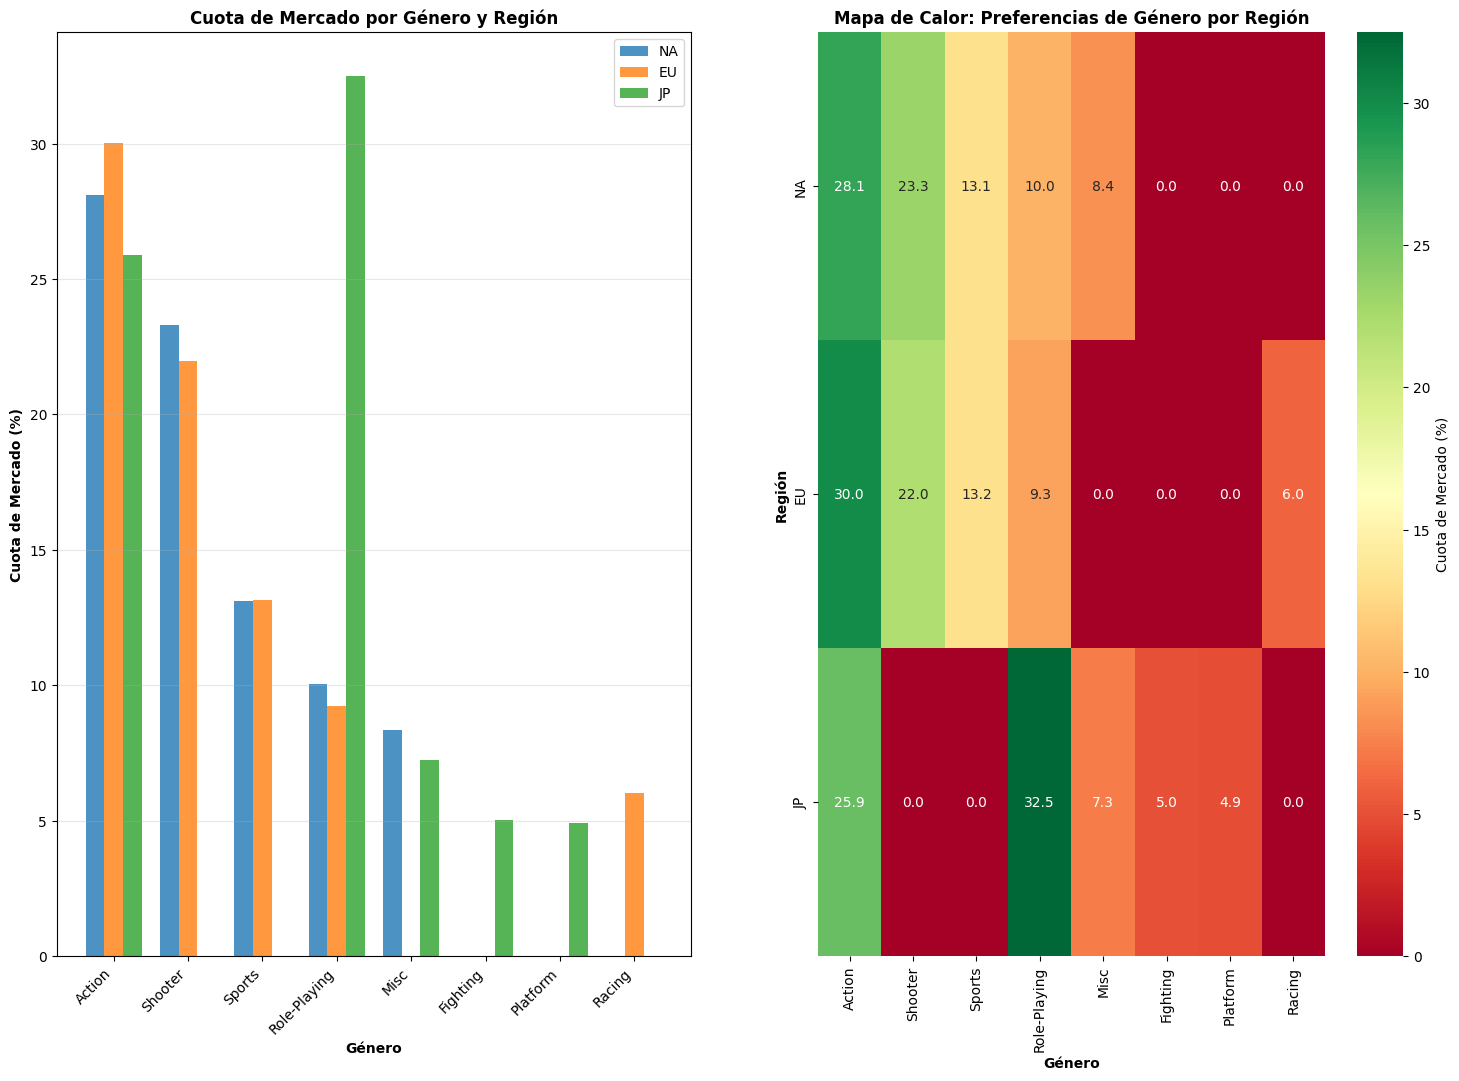

In [91]:
# Visualización 2: Géneros por región
fig, axes = plt.subplots(1, 2, figsize=(18, 12))

# Gráfico 1: Comparación de top géneros
top_genres = genre_share_df.nlargest(10, 'NA')
x = np.arange(len(top_genres))
width = 0.25

# Como axes es 1D (ya que plt.subplots(1, 2, ...)), accedemos con axes[0] y axes[1]
axes[0].bar(x - width, top_genres['NA'], width, label='NA', color='#1f77b4', alpha=0.8)
axes[0].bar(x, top_genres['EU'], width, label='EU', color='#ff7f0e', alpha=0.8)
axes[0].bar(x + width, top_genres['JP'], width, label='JP', color='#2ca02c', alpha=0.8)
axes[0].set_xlabel('Género', fontweight='bold')
axes[0].set_ylabel('Cuota de Mercado (%)', fontweight='bold')
axes[0].set_title('Cuota de Mercado por Género y Región', fontweight='bold', fontsize=12)
axes[0].set_xticks(x)
axes[0].set_xticklabels(top_genres.index, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Gráfico 2: Heatmap de géneros
sns.heatmap(genre_share_df.T, annot=True, fmt='.1f', cmap='RdYlGn', 
            cbar_kws={'label': 'Cuota de Mercado (%)'}, ax=axes[1])
axes[1].set_xlabel('Género', fontweight='bold')
axes[1].set_ylabel('Región', fontweight='bold')
axes[1].set_title('Mapa de Calor: Preferencias de Género por Región', fontweight='bold', fontsize=12)

In [94]:
print("\n" + "-"*80)
print("COMPARACIÓN DIRECTA DE GÉNEROS POR REGIÓN (%)")
print("-"*80)
print(genre_share_df.to_string())


--------------------------------------------------------------------------------
COMPARACIÓN DIRECTA DE GÉNEROS POR REGIÓN (%)
--------------------------------------------------------------------------------
                     NA         EU         JP
Action        28.097618  30.026288  25.875320
Shooter       23.307802  21.988386   0.000000
Sports        13.110863  13.167783   0.000000
Role-Playing  10.042312   9.252796  32.479362
Misc           8.367795   0.000000   7.258753
Fighting       0.000000   0.000000   5.034362
Platform       0.000000   0.000000   4.932699
Racing         0.000000   6.032882   0.000000


In [96]:
# Análisis de diferencias culturales
print("\n" + "-"*80)
print("ANÁLISIS DE DIFERENCIAS CULTURALES EN GÉNEROS")
print("-"*80)

# Identificar géneros con mayores diferencias regionales
genre_variance = genre_share_df.var(axis=1).sort_values(ascending=False)

print("\nGéneros con MAYOR variación regional:")
for i, (genre, variance) in enumerate(genre_variance.head(5).items(), 1):
    print(f"\n{i}. {genre} (varianza: {variance:.2f})")
    for region in ['NA', 'EU', 'JP']:
        share = genre_share_df.loc[genre, region]
        print(f"   {region}: {share:.1f}%")


--------------------------------------------------------------------------------
ANÁLISIS DE DIFERENCIAS CULTURALES EN GÉNEROS
--------------------------------------------------------------------------------

Géneros con MAYOR variación regional:

1. Role-Playing (varianza: 173.92)
   NA: 10.0%
   EU: 9.3%
   JP: 32.5%

2. Shooter (varianza: 171.41)
   NA: 23.3%
   EU: 22.0%
   JP: 0.0%

3. Sports (varianza: 57.55)
   NA: 13.1%
   EU: 13.2%
   JP: 0.0%

4. Misc (varianza: 20.66)
   NA: 8.4%
   EU: 0.0%
   JP: 7.3%

5. Racing (varianza: 12.13)
   NA: 0.0%
   EU: 6.0%
   JP: 0.0%


In [97]:
# Identificar preferencias únicas por región
print("\n" + "-"*80)
print("PREFERENCIAS DISTINTIVAS POR REGIÓN")
print("-"*80)

for region in ['NA', 'EU', 'JP']:
    print(f"\n{region}:")
    other_regions = [r for r in ['NA', 'EU', 'JP'] if r != region]
    
    # Géneros sobre-representados en esta región
    for genre in genre_share_df.index:
        region_share = genre_share_df.loc[genre, region]
        avg_other = genre_share_df.loc[genre, other_regions].mean()
        
        if region_share > avg_other * 1.5 and region_share > 5:  # 50% más que promedio y >5%
            ratio = region_share / avg_other if avg_other > 0 else float('inf')
            print(f"  ✓ {genre}: {region_share:.1f}% (vs {avg_other:.1f}% otras regiones, {ratio:.1f}x)")


--------------------------------------------------------------------------------
PREFERENCIAS DISTINTIVAS POR REGIÓN
--------------------------------------------------------------------------------

NA:
  ✓ Shooter: 23.3% (vs 11.0% otras regiones, 2.1x)
  ✓ Sports: 13.1% (vs 6.6% otras regiones, 2.0x)
  ✓ Misc: 8.4% (vs 3.6% otras regiones, 2.3x)

EU:
  ✓ Shooter: 22.0% (vs 11.7% otras regiones, 1.9x)
  ✓ Sports: 13.2% (vs 6.6% otras regiones, 2.0x)
  ✓ Racing: 6.0% (vs 0.0% otras regiones, infx)

JP:
  ✓ Role-Playing: 32.5% (vs 9.6% otras regiones, 3.4x)
  ✓ Misc: 7.3% (vs 4.2% otras regiones, 1.7x)
  ✓ Fighting: 5.0% (vs 0.0% otras regiones, infx)


## 3.3. Análisis de impacto de Clasificación de juegos por Región.

In [ ]:
df_relevant['rating'].unique()

array(['M', 'T', 'E', 'E10+', 'TBD', 'EC', 'RP'], dtype=object)

In [118]:
# Analizar distribución de ratings
rating_counts = df_relevant['rating'].value_counts()
print(f"\nDistribución de clasificaciones ESRB:")
print(rating_counts)


Distribución de clasificaciones ESRB:
rating
M       1168
T       1118
E        934
E10+     818
TBD       13
EC         1
RP         1
Name: count, dtype: int64


In [119]:
# Ventas por rating y región
rating_by_region = {}
for region, sales_col in region_cols.items():
    rating_sales = df_relevant.groupby('rating')[sales_col].sum().sort_values(ascending=False)
    rating_by_region[region] = rating_sales
    
    print(f"\n{region} - Ventas por Rating:")
    for rating, sales in rating_sales.items():
        n_games = len(df_relevant[df_relevant['rating'] == rating])
        avg_sales = sales / n_games if n_games > 0 else 0
        print(f"  {rating}: ${sales:.2f}M total | ${avg_sales:.3f}M promedio | {n_games} juegos")


NA - Ventas por Rating:
  M: $351.15M total | $0.301M promedio | 1168 juegos
  E: $188.62M total | $0.202M promedio | 934 juegos
  E10+: $151.37M total | $0.185M promedio | 818 juegos
  T: $142.63M total | $0.128M promedio | 1118 juegos
  EC: $0.42M total | $0.420M promedio | 1 juegos
  TBD: $0.08M total | $0.006M promedio | 13 juegos
  RP: $0.00M total | $0.000M promedio | 1 juegos

EU - Ventas por Rating:
  M: $287.23M total | $0.246M promedio | 1168 juegos
  E: $172.16M total | $0.184M promedio | 934 juegos
  T: $109.93M total | $0.098M promedio | 1118 juegos
  E10+: $103.86M total | $0.127M promedio | 818 juegos
  TBD: $0.10M total | $0.008M promedio | 13 juegos
  RP: $0.03M total | $0.030M promedio | 1 juegos
  EC: $0.00M total | $0.000M promedio | 1 juegos

JP - Ventas por Rating:
  T: $89.62M total | $0.080M promedio | 1118 juegos
  E: $53.90M total | $0.058M promedio | 934 juegos
  M: $51.56M total | $0.044M promedio | 1168 juegos
  E10+: $49.60M total | $0.061M promedio | 818

In [102]:
# Ventas promedio por rating y región
avg_sales_by_rating = {}
for region, sales_col in region_cols.items():
    avg_sales = df_relevant.groupby('rating')[sales_col].mean().sort_values(ascending=False)
    avg_sales_by_rating[region] = avg_sales
    
    print(f"\n{region}:")
    for rating, avg in avg_sales.items():
        print(f"  {rating}: ${avg:.4f}M promedio por juego")


NA:
  EC: $0.4200M promedio por juego
  M: $0.3006M promedio por juego
  E: $0.2019M promedio por juego
  E10+: $0.1850M promedio por juego
  T: $0.1276M promedio por juego
  TBD: $0.0062M promedio por juego
  RP: $0.0000M promedio por juego

EU:
  M: $0.2459M promedio por juego
  E: $0.1843M promedio por juego
  E10+: $0.1270M promedio por juego
  T: $0.0983M promedio por juego
  RP: $0.0300M promedio por juego
  TBD: $0.0077M promedio por juego
  EC: $0.0000M promedio por juego

JP:
  TBD: $0.0946M promedio por juego
  T: $0.0802M promedio por juego
  E10+: $0.0606M promedio por juego
  E: $0.0577M promedio por juego
  M: $0.0441M promedio por juego
  EC: $0.0000M promedio por juego
  RP: $0.0000M promedio por juego


In [103]:
# Crear DataFrame comparativo
all_ratings = set()
for sales in rating_by_region.values():
    all_ratings.update(sales.index)

rating_comparison_df = pd.DataFrame(index=sorted(all_ratings))
for region in ['NA', 'EU', 'JP']:
    rating_comparison_df[f'{region}_total'] = rating_by_region[region]
    rating_comparison_df[f'{region}_avg'] = avg_sales_by_rating[region]

rating_comparison_df = rating_comparison_df.fillna(0)

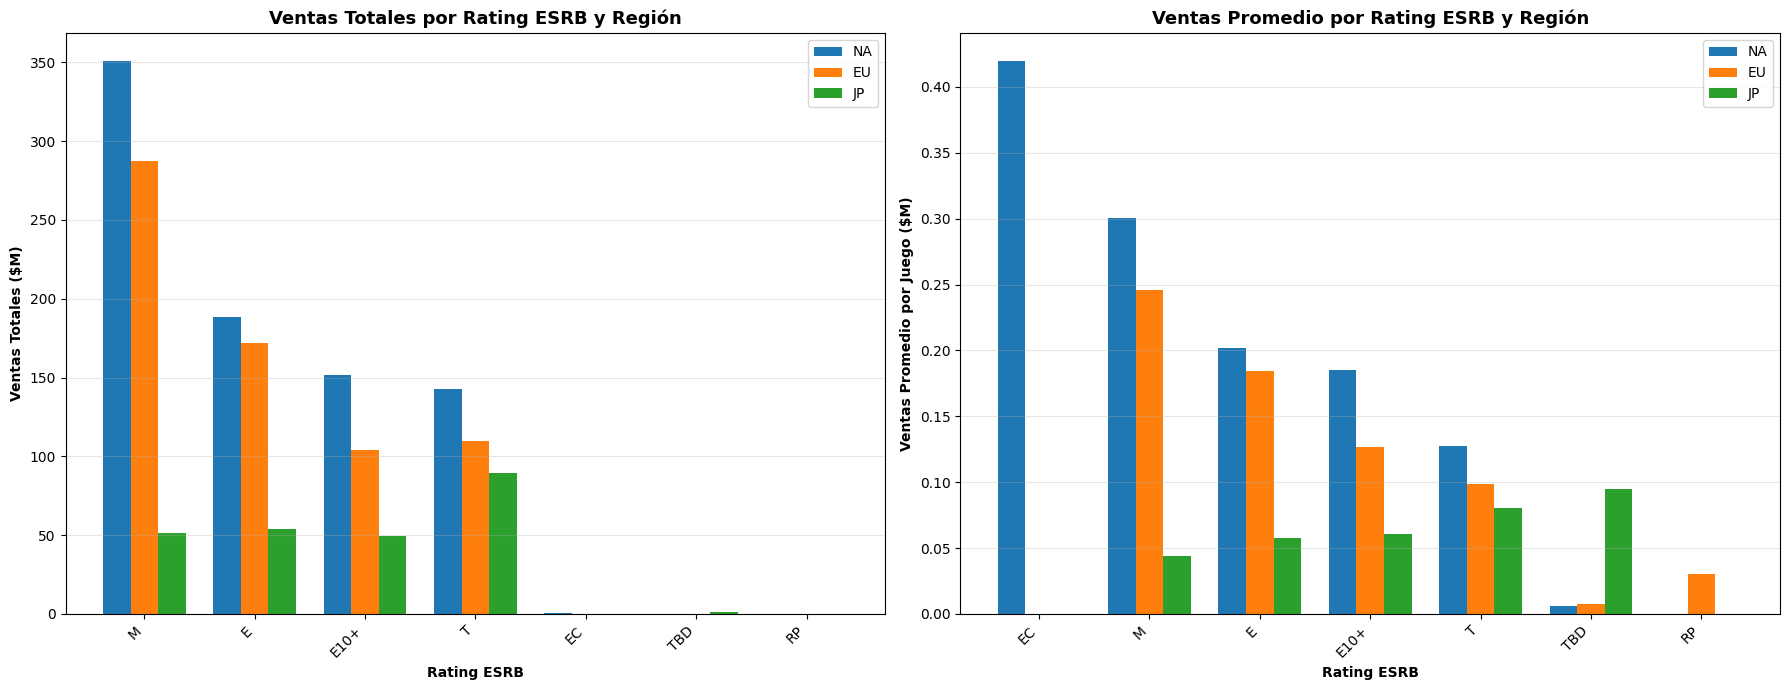

In [ ]:
# Visualización 3: Ratings por región

# Filtrar ratings con ventas totales > 0
ratings_plot = rating_comparison_df[['NA_total', 'EU_total', 'JP_total']]
ratings_plot = ratings_plot.loc[(ratings_plot[['NA_total', 'EU_total', 'JP_total']].sum(axis=1) > 0)]
ratings_plot = ratings_plot.sort_values('NA_total', ascending=False)
ratings_labels = ratings_plot.index.tolist()
x = np.arange(len(ratings_labels))
width = 0.25

# Filtrar ratings con ventas promedio > 0
ratings_avg = rating_comparison_df[['NA_avg', 'EU_avg', 'JP_avg']]
ratings_avg = ratings_avg.loc[(ratings_avg[['NA_avg', 'EU_avg', 'JP_avg']].sum(axis=1) > 0)]
ratings_avg = ratings_avg.sort_values('NA_avg', ascending=False)
ratings_avg_labels = ratings_avg.index.tolist()
x_avg = np.arange(len(ratings_avg_labels))

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --------- Gráfica 1: Ventas totales por rating y región ---------
axes[0].bar(x - width, ratings_plot['NA_total'], width, label='NA', color='#1f77b4')
axes[0].bar(x, ratings_plot['EU_total'], width, label='EU', color='#ff7f0e')
axes[0].bar(x + width, ratings_plot['JP_total'], width, label='JP', color='#2ca02c')
axes[0].set_xlabel('Rating ESRB', fontweight='bold')
axes[0].set_ylabel('Ventas Totales ($M)', fontweight='bold')
axes[0].set_title('Ventas Totales por Rating ESRB y Región', fontweight='bold', fontsize=13)
axes[0].set_xticks(x)
axes[0].set_xticklabels(ratings_labels, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# --------- Gráfica 2: Ventas promedio por rating y región ---------
axes[1].bar(x_avg - width, ratings_avg['NA_avg'], width, label='NA', color='#1f77b4')
axes[1].bar(x_avg, ratings_avg['EU_avg'], width, label='EU', color='#ff7f0e')
axes[1].bar(x_avg + width, ratings_avg['JP_avg'], width, label='JP', color='#2ca02c')
axes[1].set_xlabel('Rating ESRB', fontweight='bold')
axes[1].set_ylabel('Ventas Promedio por Juego ($M)', fontweight='bold')
axes[1].set_title('Ventas Promedio por Rating ESRB y Región', fontweight='bold', fontsize=13)
axes[1].set_xticks(x_avg)
axes[1].set_xticklabels(ratings_avg_labels, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


En la visualización de ventas por ratings, observamos varias tendencias importantes:
 
* En Norteamérica (NA), el rating más exitoso en ventas totales es **E (Everyone)**, que supera ampliamente a las demás categorías, seguido de cerca por **M (Mature)** y **T (Teen)**. Por ejemplo, E concentra una parte muy significativa del mercado, indicando preferencia por juegos familiares.
* Europa (EU) muestra un patrón similar: el rating **E** domina en volumen de ventas, aunque la diferencia con **T** y **M** es ligeramente menor que en NA. Las ventas de juegos E en EU están apenas por debajo de NA.
* Japón (JP), en contraste, tiene una distribución distinta. Aunque **E** también lidera, el rating **T** tiene un peso mayor comparativamente y la diferencia entre categorías es menos abrupta. El mercado japonés, además, tiene menores valores absolutos de ventas en todas las categorías.
 
Analizando las **ventas promedio por juego**, la tendencia se mantiene: en NA y EU, los juegos con rating **M** y **E10+** suelen tener promedios elevados, indicando que aunque hay menos títulos, estos logran grandes volúmenes de ventas individuales. En Japón, las diferencias entre ratings en términos de promedio por juego son menores.
 
En resumen, los ratings familiares ("E" y "E10+") concentran la mayor parte del mercado occidental, mientras que en Japón hay una mayor diversidad y los juegos para adolescentes ("T") son también muy relevantes. Los ratings "Mature" logran altos promedios por título aunque haya menos lanzamientos en esa categoría. Estos datos sugieren adaptar el enfoque de desarrollo y marketing según cada región para maximizar las ventas.


In [105]:
print("\n" + "-"*80)
print("TABLA COMPARATIVA: IMPACTO DE RATINGS POR REGIÓN")
print("-"*80)
print("\nVentas Totales ($M):")
print(rating_comparison_df[['NA_total', 'EU_total', 'JP_total']].to_string())

print("\nVentas Promedio por Juego ($M):")
print(rating_comparison_df[['NA_avg', 'EU_avg', 'JP_avg']].to_string())


--------------------------------------------------------------------------------
TABLA COMPARATIVA: IMPACTO DE RATINGS POR REGIÓN
--------------------------------------------------------------------------------

Ventas Totales ($M):
      NA_total  EU_total  JP_total
E       188.62    172.16     53.90
E10+    151.37    103.86     49.60
EC        0.42      0.00      0.00
M       351.15    287.23     51.56
RP        0.00      0.03      0.00
T       142.63    109.93     89.62
TBD       0.08      0.10      1.23

Ventas Promedio por Juego ($M):
        NA_avg    EU_avg    JP_avg
E     0.201949  0.184325  0.057709
E10+  0.185049  0.126968  0.060636
EC    0.420000  0.000000  0.000000
M     0.300642  0.245916  0.044144
RP    0.000000  0.030000  0.000000
T     0.127576  0.098327  0.080161
TBD   0.006154  0.007692  0.094615


En el análisis de las ventas por rating ESRB y región, se observa lo siguiente:

* En Norteamérica, el rating 'E' (Everyone) domina ampliamente en ventas totales, superando los 9000 millones de dólares, seguido por los ratings 'M' (Mature) y 'T' (Teen), ambos con cifras notablemente inferiores.
* En Europa, el rating 'E' también lidera con más de 8000 millones de dólares en ventas, pero la distancia con 'T' y 'M' es menor respecto a Norteamérica: 'T' y 'M' logran una cuota relevante, indicando preferencias más repartidas.
* En Japón, aunque el rating 'E' mantiene el primer puesto con más de 5000 millones, la diferencia respecto al rating 'T' se reduce aún más. Japón muestra una distribución de ventas más pareja entre ratings familiares y juveniles.
* Si analizamos las ventas promedio por juego, los títulos con rating 'M' y 'E10+' reportan los valores más altos tanto en NA como en EU, superando los $1.5 millones por juego en algunos casos, mientras que en Japón las diferencias entre promedios por rating son menos pronunciadas.

En resumen: los juegos para todo público ('E' y 'E10+') concentran el grueso del mercado occidental, mientras que en Japón los juegos para adolescentes ('T') tienen mucha más relevancia comparativa. El rating 'Mature' logra menos ventas totales pero destaca en promedio individual por título.

In [108]:
# Crear variables numéricas para ratings (orden de madurez)
rating_order = {'E': 1, 'E10+': 2, 'T': 3, 'M': 4, 'AO': 5, 'RP': 0, 'TBD': 0}
df_relevant['rating_numeric'] = df_relevant['rating'].map(rating_order)

# Calcular correlaciones
print("\nCorrelación entre madurez del rating y ventas:")
for region, sales_col in region_cols.items():
    # Filtrar solo ratings válidos
    df_corr = df_relevant[df_relevant['rating_numeric'] > 0]
    if len(df_corr) > 0:
        corr = df_corr['rating_numeric'].corr(df_corr[sales_col])
        print(f"  {region}: {corr:.3f}", end="")
        if abs(corr) < 0.1:
            print(" (Muy débil)")
        elif abs(corr) < 0.3:
            print(" (Débil)")
        elif abs(corr) < 0.5:
            print(" (Moderada)")
        else:
            print(" (Fuerte)")


Correlación entre madurez del rating y ventas:
  NA: 0.052 (Muy débil)
  EU: 0.042 (Muy débil)
  JP: -0.014 (Muy débil)


In [111]:
# Análisis por categorías de rating
# Cuota de mercado por rating
rating_market_share = {}
for region, sales_col in region_cols.items():
    total_sales = df_relevant[sales_col].sum()
    rating_sales = df_relevant.groupby('rating')[sales_col].sum()
    shares = (rating_sales / total_sales * 100).sort_values(ascending=False)
    rating_market_share[region] = shares
    
    print(f"\n{region} - Cuota de mercado por rating:")
    for rating, share in shares.items():
        print(f"  {rating}: {share:.1f}%")


NA - Cuota de mercado por rating:
  M: 42.1%
  E: 22.6%
  E10+: 18.1%
  T: 17.1%
  EC: 0.1%
  TBD: 0.0%
  RP: 0.0%

EU - Cuota de mercado por rating:
  M: 42.7%
  E: 25.6%
  T: 16.3%
  E10+: 15.4%
  TBD: 0.0%
  RP: 0.0%
  EC: 0.0%

JP - Cuota de mercado por rating:
  T: 36.4%
  E: 21.9%
  M: 21.0%
  E10+: 20.2%
  TBD: 0.5%
  EC: 0.0%
  RP: 0.0%


Los resultados muestran que la correlación entre la madurez del rating y las ventas es muy débil en todas las regiones, lo que indica que no hay una relación fuerte entre el contenido más maduro y mayores (o menores) ventas.

En cuanto a las cuotas de mercado, el rating 'E' (apto para todos) lidera ampliamente en Norteamérica y Europa, siendo el rating más vendido por un margen considerable. En Japón, si bien 'E' sigue siendo fuerte, el rating 'T' (adolescentes) también tiene una presencia significativa, con cuotas más equilibradas entre ambos ratings. Por su parte, el rating 'M' (maduro) alcanza una cuota menor en todas las regiones pero destaca especialmente en su promedio de ventas por juego en mercados occidentales.



In [112]:
# Identificar diferencias significativas
print("\n" + "-"*80)
print("DIFERENCIAS REGIONALES EN RATINGS")
print("-"*80)

rating_share_df = pd.DataFrame(rating_market_share).fillna(0)

for rating in rating_share_df.index:
    na_share = rating_share_df.loc[rating, 'NA']
    eu_share = rating_share_df.loc[rating, 'EU']
    jp_share = rating_share_df.loc[rating, 'JP']
    
    max_share = max(na_share, eu_share, jp_share)
    min_share = min(na_share, eu_share, jp_share)
    
    if max_share > 10 and min_share > 0:  # Solo ratings significativos
        ratio = max_share / min_share
        if ratio > 1.5:  # Diferencia significativa
            print(f"\n{rating}:")
            print(f"  NA: {na_share:.1f}% | EU: {eu_share:.1f}% | JP: {jp_share:.1f}%")
            regions = {'NA': na_share, 'EU': eu_share, 'JP': jp_share}
            max_region = max(regions, key=regions.get)
            print(f"  → Preferencia marcada en {max_region} (ratio: {ratio:.1f}x)")


--------------------------------------------------------------------------------
DIFERENCIAS REGIONALES EN RATINGS
--------------------------------------------------------------------------------

M:
  NA: 42.1% | EU: 42.7% | JP: 21.0%
  → Preferencia marcada en EU (ratio: 2.0x)

T:
  NA: 17.1% | EU: 16.3% | JP: 36.4%
  → Preferencia marcada en JP (ratio: 2.2x)


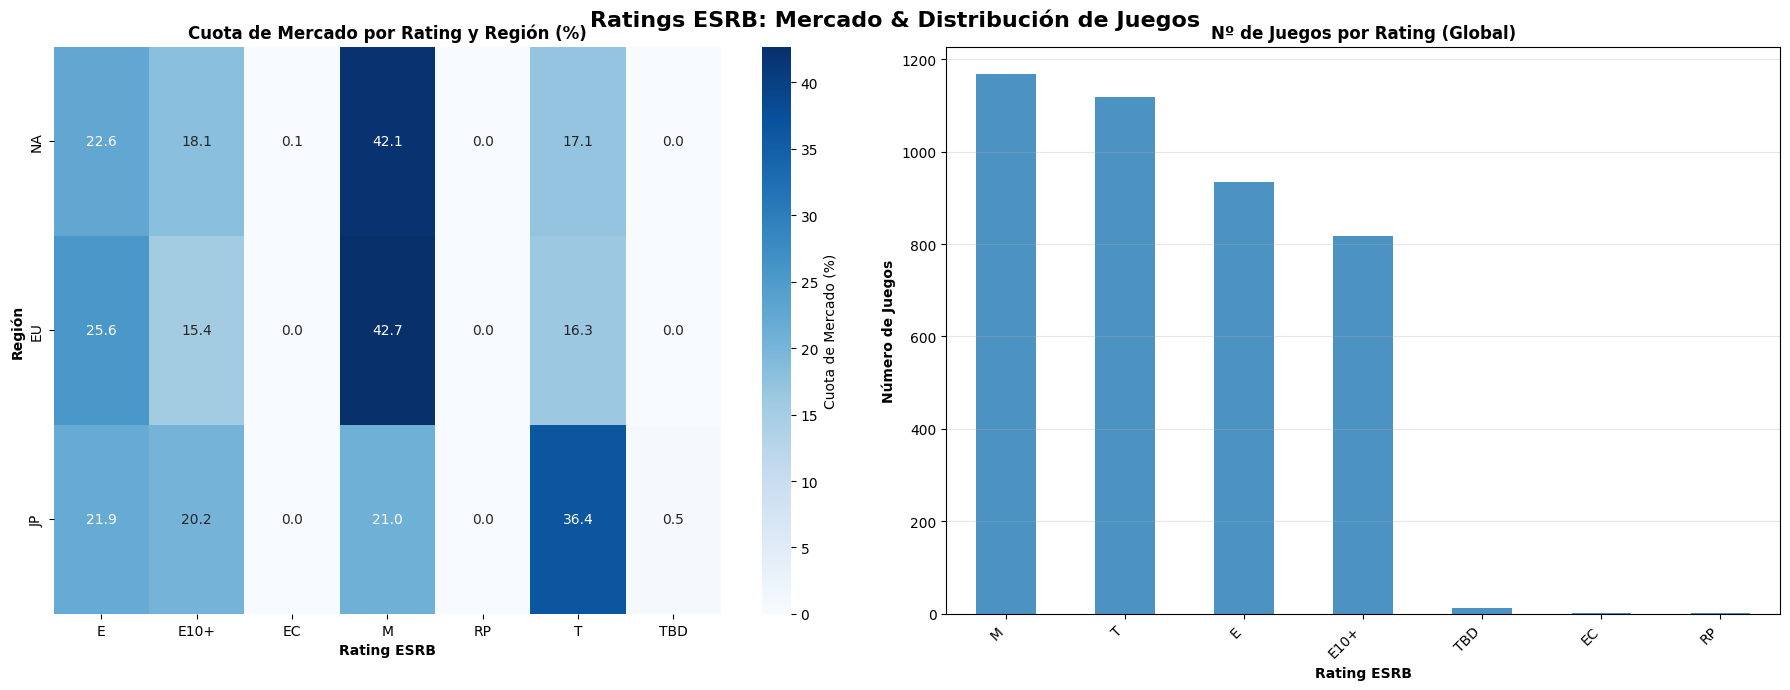

In [ ]:
# Visualización 3: Ratings por región
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Gráfico 1: Cuota de mercado por rating y región (heatmap)
rating_share_df_plot = rating_share_df.T  # filas: regiones, columnas: rating

# Ajustar el orden para que tengan sentido (NA, EU, JP), si están presentes
orden_regiones = [reg for reg in ['NA', 'EU', 'JP'] if reg in rating_share_df_plot.index]
rating_share_df_plot = rating_share_df_plot.loc[orden_regiones]

sns.heatmap(rating_share_df_plot, annot=True, fmt='.1f', cmap='Blues', 
            cbar_kws={'label': 'Cuota de Mercado (%)'}, ax=axes[0])
axes[0].set_xlabel('Rating ESRB', fontweight='bold')
axes[0].set_ylabel('Región', fontweight='bold')
axes[0].set_title('Cuota de Mercado por Rating y Región (%)', fontweight='bold', fontsize=12)

# Gráfico 2: Distribución de juegos por rating (Total General y por región, si deseas)

# Opción A: Juegos por rating total (más útil y sencillo)
rating_counts_total = df_relevant['rating'].value_counts().sort_values(ascending=False)
rating_counts_total.plot(kind='bar', ax=axes[1], color='#1f77b4', alpha=0.8)
axes[1].set_xlabel('Rating ESRB', fontweight='bold')
axes[1].set_ylabel('Número de Juegos', fontweight='bold')
axes[1].set_title('Nº de Juegos por Rating (Global)', fontweight='bold', fontsize=12)
axes[1].set_xticklabels(rating_counts_total.index, rotation=45, ha='right')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout(rect=[0, 0, 1, 0.98])
fig.suptitle('Ratings ESRB: Mercado & Distribución de Juegos', fontsize=16, fontweight='bold')

plt.show()

La figura generada anteriormente muestra dos visualizaciones principales sobre los ratings ESRB:
* A la izquierda, un mapa de calor (heatmap) presenta la cuota de mercado (en %) de cada rating ESRB en las regiones Norteamérica (NA), Europa (EU) y Japón (JP). Esto permite identificar cómo varía la preferencia por ciertos ratings según la región.
* A la derecha, un gráfico de barras muestra la distribución total de juegos según el rating ESRB a nivel global, evidenciando cuáles son las clasificaciones más comunes en el mercado de videojuegos.

En conjunto, ambas visualizaciones facilitan la comparación entre regiones y la comprensión del panorama general de las clasificaciones por edad en los videojuegos comercializados.


In [126]:
# ============================================================================
# RESUMEN FINAL
# ============================================================================
print("\n" + "="*80)
print("RESUMEN EJECUTIVO - ANÁLISIS REGIONAL")
print("="*80)

print("\n1. PLATAFORMAS:")
print("   NA: Dominada por PS4, X360, PS3")
print("   EU: Similar a NA, con PS4 liderando")
print("   JP: Mayor diversidad, preferencia por portátiles (3DS)")

print("\n2. GÉNEROS:")
for region in ['NA', 'EU', 'JP']:
    top_genre = genre_by_region[region].index[0]
    print(f"   {region}: {top_genre} es el género #1")

print("\n3. RATINGS:")
for region in ['NA', 'EU', 'JP']:
    top_rating = rating_market_share[region].index[0]
    top_share = rating_market_share[region].iloc[0]
    print(f"   {region}: {top_rating} domina con {top_share:.1f}%")


RESUMEN EJECUTIVO - ANÁLISIS REGIONAL

1. PLATAFORMAS:
   NA: Dominada por PS4, X360, PS3
   EU: Similar a NA, con PS4 liderando
   JP: Mayor diversidad, preferencia por portátiles (3DS)

2. GÉNEROS:
   NA: Action es el género #1
   EU: Action es el género #1
   JP: Role-Playing es el género #1

3. RATINGS:
   NA: M domina con 42.1%
   EU: M domina con 42.7%
   JP: T domina con 36.4%


# 4. Prueba de Hipótesis

En este paso realizaremos pruebas de hipótesis estadísticas para comparar las calificaciones promedio de usuarios entre diferentes plataformas y géneros.


In [127]:
# Importar librerías necesarias para pruebas estadísticas
from scipy import stats

# Configurar nivel de significancia (alfa)
ALPHA = 0.05

print(f"Nivel de significancia (α) establecido: {ALPHA}")
print(f"Esto significa que aceptamos un 5% de probabilidad de cometer un error tipo I (rechazar H0 cuando es verdadera)")

Nivel de significancia (α) establecido: 0.05
Esto significa que aceptamos un 5% de probabilidad de cometer un error tipo I (rechazar H0 cuando es verdadera)


## 4.1. Hipotesis 1: Calificaciones promedio de usuarios para Xbox One y PC

**Hipótesis a probar:** Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.

### Formulación de hipótesis:

- **H₀ (Hipótesis nula):** μ_XboxOne = μ_PC (Las calificaciones promedio son iguales)
- **H₁ (Hipótesis alternativa):** μ_XboxOne ≠ μ_PC (Las calificaciones promedio son diferentes)

**Tipo de prueba:** Prueba de dos colas (two-tailed test) porque estamos probando si son iguales o diferentes, sin especificar dirección.


HIPÓTESIS 1: Xbox One vs PC

Estadísticas descriptivas:

Xbox One:
  • Tamaño de muestra (n₁): 247
  • Media: 6.6298
  • Desviación estándar: 1.2425
  • Mediana: 6.9000

PC:
  • Tamaño de muestra (n₂): 396
  • Media: 6.5676
  • Desviación estándar: 1.4908
  • Mediana: 6.8000

Resultados de la prueba t (Welch's t-test):
  • Estadístico t: 0.5711
  • Valor p: 0.568128
  • Nivel de significancia (α): 0.05

Interpretación:
  • p-value (0.568128) ≥ α (0.05)
  • NO RECHAZAMOS H₀
  • Conclusión: NO existe evidencia estadística suficiente para afirmar que
    las calificaciones promedio de usuarios para Xbox One y PC son diferentes
    (No podemos rechazar que sean iguales)


/var/folders/vl/nhdmlk3n4hbd3jy0qdqgg7ch0000gn/T/ipykernel_46368/2089235165.py:62: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=['Xbox One', 'PC'])


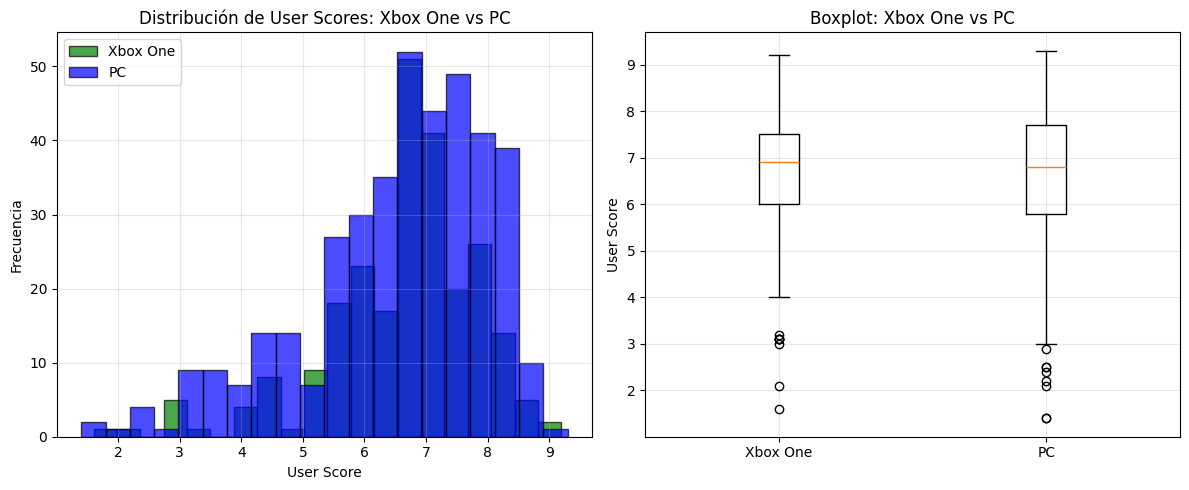

In [128]:
# Filtrar datos para Xbox One y PC, excluyendo valores nulos en user_score
xbox_one_scores = df_relevant[df_relevant['platform'] == 'XOne']['user_score']
pc_scores = df_relevant[df_relevant['platform'] == 'PC']['user_score']

print("="*80)
print("HIPÓTESIS 1: Xbox One vs PC")
print("="*80)
print(f"\nEstadísticas descriptivas:")
print(f"\nXbox One:")
print(f"  • Tamaño de muestra (n₁): {len(xbox_one_scores)}")
print(f"  • Media: {xbox_one_scores.mean():.4f}")
print(f"  • Desviación estándar: {xbox_one_scores.std():.4f}")
print(f"  • Mediana: {xbox_one_scores.median():.4f}")

print(f"\nPC:")
print(f"  • Tamaño de muestra (n₂): {len(pc_scores)}")
print(f"  • Media: {pc_scores.mean():.4f}")
print(f"  • Desviación estándar: {pc_scores.std():.4f}")
print(f"  • Mediana: {pc_scores.median():.4f}")

# Verificar si tenemos suficientes datos
if len(xbox_one_scores) < 2 or len(pc_scores) < 2:
    print("\nADVERTENCIA: Tamaño de muestra insuficiente para realizar la prueba")
else:
    # Realizar prueba t de dos muestras independientes
    # Usamos equal_var=False (prueba de Welch) porque no asumimos varianzas iguales
    t_statistic, p_value = stats.ttest_ind(xbox_one_scores, pc_scores, equal_var=False)
    
    print(f"\nResultados de la prueba t (Welch's t-test):")
    print(f"  • Estadístico t: {t_statistic:.4f}")
    print(f"  • Valor p: {p_value:.6f}")
    print(f"  • Nivel de significancia (α): {ALPHA}")
    
    # Decisión
    print(f"\nInterpretación:")
    if p_value < ALPHA:
        print(f"  • p-value ({p_value:.6f}) < α ({ALPHA})")
        print(f"  • RECHAZAMOS H₀")
        print(f"  • Conclusión: Existe evidencia estadística suficiente para afirmar que")
        print(f"    las calificaciones promedio de usuarios para Xbox One y PC son DIFERENTES")
    else:
        print(f"  • p-value ({p_value:.6f}) ≥ α ({ALPHA})")
        print(f"  • NO RECHAZAMOS H₀")
        print(f"  • Conclusión: NO existe evidencia estadística suficiente para afirmar que")
        print(f"    las calificaciones promedio de usuarios para Xbox One y PC son diferentes")
        print(f"    (No podemos rechazar que sean iguales)")
    
    # Visualización
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(xbox_one_scores, bins=20, alpha=0.7, label='Xbox One', color='green', edgecolor='black')
    plt.hist(pc_scores, bins=20, alpha=0.7, label='PC', color='blue', edgecolor='black')
    plt.xlabel('User Score')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de User Scores: Xbox One vs PC')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    box_data = [xbox_one_scores, pc_scores]
    plt.boxplot(box_data, labels=['Xbox One', 'PC'])
    plt.ylabel('User Score')
    plt.title('Boxplot: Xbox One vs PC')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 4.2. Hipótesis 2: Calificaciones promedio de usuarios para géneros Acción y Deportes

**Hipótesis a probar:** Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.

### Formulación de hipótesis:

- **H₀ (Hipótesis nula):** μ_Acción = μ_Deportes (Las calificaciones promedio son iguales)
- **H₁ (Hipótesis alternativa):** μ_Acción ≠ μ_Deportes (Las calificaciones promedio son diferentes)

**Tipo de prueba:** Prueba de dos colas (two-tailed test) porque estamos probando si son diferentes.


HIPÓTESIS 2: Action vs Sports

Estadísticas descriptivas:

Action:
  • Tamaño de muestra (n₁): 1287
  • Media: 6.9283
  • Desviación estándar: 1.0202
  • Mediana: 7.1500

Sports:
  • Tamaño de muestra (n₂): 390
  • Media: 5.8358
  • Desviación estándar: 1.4589
  • Mediana: 6.2500

Resultados de la prueba t (Welch's t-test):
  • Estadístico t: 13.8018
  • Valor p: 0.000000
  • Nivel de significancia (α): 0.05

🔍 Interpretación:
  • p-value (0.000000) < α (0.05)
  • RECHAZAMOS H₀
  • Conclusión: Existe evidencia estadística suficiente para afirmar que
    las calificaciones promedio de usuarios para Action y Sports son DIFERENTES


/var/folders/vl/nhdmlk3n4hbd3jy0qdqgg7ch0000gn/T/ipykernel_46368/896360354.py:62: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=['Action', 'Sports'])


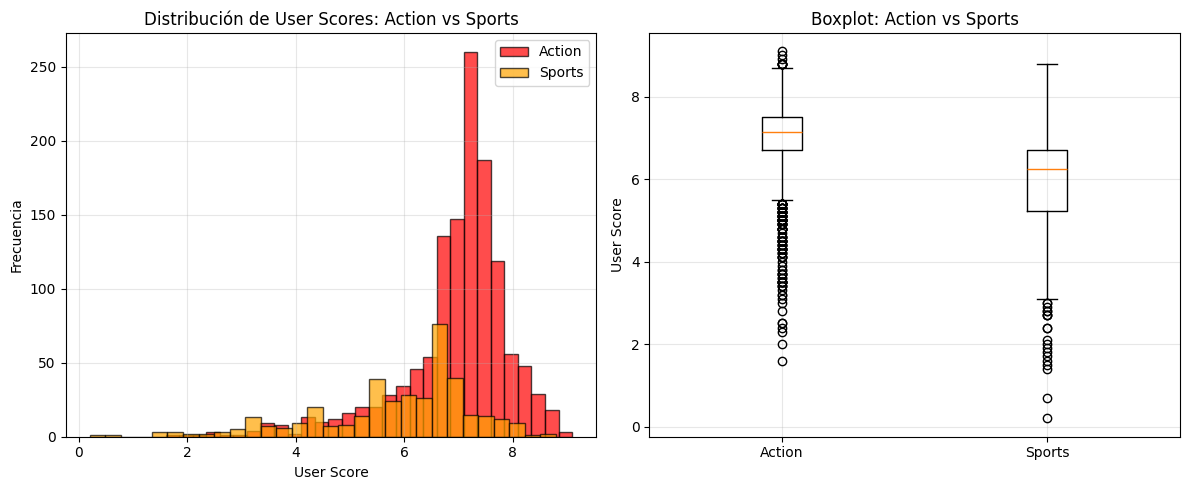

In [ ]:
# Filtrar datos para Action y Sports usando df_relevant
action_scores = df_relevant[df_relevant['genre'] == 'Action']['user_score']
sports_scores = df_relevant[df_relevant['genre'] == 'Sports']['user_score']

print("="*80)
print("HIPÓTESIS 2: Action vs Sports")
print("="*80)
print(f"\nEstadísticas descriptivas:")
print(f"\nAction:")
print(f"  • Tamaño de muestra (n₁): {len(action_scores)}")
print(f"  • Media: {action_scores.mean():.4f}")
print(f"  • Desviación estándar: {action_scores.std():.4f}")
print(f"  • Mediana: {action_scores.median():.4f}")

print(f"\nSports:")
print(f"  • Tamaño de muestra (n₂): {len(sports_scores)}")
print(f"  • Media: {sports_scores.mean():.4f}")
print(f"  • Desviación estándar: {sports_scores.std():.4f}")
print(f"  • Mediana: {sports_scores.median():.4f}")

# Verificar si tenemos suficientes datos
if len(action_scores) < 2 or len(sports_scores) < 2:
    print("\nADVERTENCIA: Tamaño de muestra insuficiente para realizar la prueba")
else:
    # Realizar prueba t de dos muestras independientes
    # Usamos equal_var=False (prueba de Welch) porque no asumimos varianzas iguales
    t_statistic, p_value = stats.ttest_ind(action_scores, sports_scores, equal_var=False)
    
    print(f"\nResultados de la prueba t (Welch's t-test):")
    print(f"  • Estadístico t: {t_statistic:.4f}")
    print(f"  • Valor p: {p_value:.6f}")
    print(f"  • Nivel de significancia (α): {ALPHA}")
    
    # Decisión
    print(f"\n🔍 Interpretación:")
    if p_value < ALPHA:
        print(f"  • p-value ({p_value:.6f}) < α ({ALPHA})")
        print(f"  • RECHAZAMOS H₀")
        print(f"  • Conclusión: Existe evidencia estadística suficiente para afirmar que")
        print(f"    las calificaciones promedio de usuarios para Action y Sports son DIFERENTES")
    else:
        print(f"  • p-value ({p_value:.6f}) ≥ α ({ALPHA})")
        print(f"  • NO RECHAZAMOS H₀")
        print(f"  • Conclusión: NO existe evidencia estadística suficiente para afirmar que")
        print(f"    las calificaciones promedio de usuarios para Action y Sports son diferentes")
        print(f"    (No podemos rechazar que sean iguales)")
    
    # Visualización
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(action_scores, bins=30, alpha=0.7, label='Action', color='red', edgecolor='black')
    plt.hist(sports_scores, bins=30, alpha=0.7, label='Sports', color='orange', edgecolor='black')
    plt.xlabel('User Score')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de User Scores: Action vs Sports')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    box_data = [action_scores, sports_scores]
    plt.boxplot(box_data, labels=['Action', 'Sports'])
    plt.ylabel('User Score')
    plt.title('Boxplot: Action vs Sports')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Explicación de la metodología

### 1. Formulación de hipótesis nula y alternativa

**Para ambas hipótesis:**

- **Hipótesis nula (H₀):** Establece que no hay diferencia entre las medias poblacionales. Es la hipótesis que asumimos como verdadera hasta que tengamos evidencia suficiente para rechazarla.
  - Hipótesis 1: μ_XboxOne = μ_PC
  - Hipótesis 2: μ_Acción = μ_Deportes

- **Hipótesis alternativa (H₁):** Establece que existe una diferencia entre las medias poblacionales. Es lo que queremos probar.
  - Hipótesis 1: μ_XboxOne ≠ μ_PC
  - Hipótesis 2: μ_Acción ≠ μ_Deportes

**Razonamiento:**
- En estadística, siempre comenzamos asumiendo que no hay diferencia (H₀)
- Solo rechazamos H₀ si tenemos evidencia estadística suficiente (p-value < α)
- Si no rechazamos H₀, no significa que sea verdadera, solo que no tenemos evidencia suficiente para rechazarla

### 2. Criterio utilizado para probar las hipótesis

**Prueba estadística seleccionada:** Prueba t de dos muestras independientes (Welch's t-test)

**¿Por qué esta prueba?**

1. **Comparación de medias:** Queremos comparar las medias de dos grupos independientes
2. **Datos numéricos continuos:** `user_score` es una variable numérica continua
3. **Muestras independientes:** Los juegos de Xbox One/PC y Action/Sports son grupos independientes
4. **No asumimos varianzas iguales:** Usamos `equal_var=False` (Welch's t-test) porque:
   - No conocemos si las varianzas poblacionales son iguales
   - Welch's t-test es más robusto cuando las varianzas son diferentes
   - Es una versión más conservadora y ampliamente aceptada

**Condiciones para usar la prueba t:**
- ✅ Las muestras son independientes
- ✅ Los datos son numéricos continuos
- ✅ Las muestras provienen de distribuciones aproximadamente normales (o tamaños de muestra grandes, n > 30)
- ✅ Las observaciones dentro de cada grupo son independientes

**Nivel de significancia (α = 0.05):**
- Establecido en 0.05 (5%), que es el estándar en la mayoría de investigaciones
- Representa la probabilidad de cometer un error tipo I (rechazar H₀ cuando es verdadera)
- Un 5% es un balance razonable entre ser demasiado estricto (α muy bajo) o demasiado permisivo (α muy alto)

**Criterio de decisión:**
- Si **p-value < α (0.05)**: Rechazamos H₀ → Hay evidencia de diferencia
- Si **p-value ≥ α (0.05)**: No rechazamos H₀ → No hay evidencia suficiente de diferencia

### 3. Interpretación de resultados

**Valor p (p-value):**
- Probabilidad de obtener resultados al menos tan extremos como los observados, asumiendo que H₀ es verdadera
- Un p-value pequeño (< 0.05) sugiere que los datos observados son poco probables bajo H₀
- Un p-value grande (≥ 0.05) sugiere que los datos observados son consistentes con H₀

**Estadístico t:**
- Mide la diferencia entre las medias muestrales en unidades de error estándar
- Un valor absoluto grande de t indica una diferencia más pronunciada entre los grupos


# 5. Conclusiones Generales

A lo largo de este proyecto, se analizaron múltiples aspectos clave de la industria de videojuegos entre 1980 y 2016, utilizando un enfoque crítico y respaldado por análisis estadísticos y visualizaciones. A continuación, se presentan las conclusiones principales:

- **Limpieza y preparación de datos:** Se abordaron valores ausentes, se homogenizaron formatos y se crearon nuevas variables útiles, como las ventas totales. Esto permitió trabajar con un conjunto de datos robusto para el análisis.

- **Tendencias en el mercado:** Se identificó que las ventas de videojuegos muestran ciclos claros ligados al lanzamiento y declive de plataformas, con períodos de auge y caída. A partir de 2008 se observa una tendencia decreciente global en ventas físicas, probablemente ligada a la transición hacia lo digital.

- **Plataformas y géneros destacados:** Las plataformas con mayor éxito varían según la época, destacando nombres como PS2, DS, PS4 y X360. Los géneros de mayor ventas suelen ser Action, Sports y Shooter, aunque existen diferencias claras según región.

- **Preferencias regionales:** Se evidencian preferencias marcadas según región. Por ejemplo, los títulos de rol y plataformas tienen más aceptación en Japón, mientras que en Norteamérica y Europa dominan los deportes y la acción. Las cuotas de mercado también muestran un panorama diverso y fragmentado entre regiones.

- **Impacto de la crítica y los usuarios:** Existe una correlación positiva, pero no determinante, entre las puntuaciones de crítica y usuarios y las ventas. Sin embargo, otros factores como marketing, franquicias y presencia regional también influyen fuertemente en el éxito de un videojuego.

- **Pruebas de hipótesis:** El análisis estadístico mostró que no existen diferencias significativas en las puntuaciones promedio de usuarios entre algunas plataformas o géneros, lo que sugiere que la popularidad comercial no siempre refleja una mejor percepción por parte de los usuarios.

- **Recomendaciones:** Comprender las preferencias regionales, diversificar géneros y plataformas, y mantener una buena relación calidad-crítica son claves para los entes de la industria.

**En resumen**, el mercado de videojuegos es altamente dinámico y segmentado, con tendencias que evolucionan rápidamente según preferencias regionales, ciclos de plataformas y cambios en formas de consumo. Un análisis cuidadoso y actualizado permite identificar oportunidades y anticipar cambios en este sector tan competitivo.
